## LightGBM 적용 – 위스콘신 Breast Cancer Prediction

#### LightGBM 장단점
\
* LightGBM의 장점

\- XGBoost 대비 더 빠른 학습과 예측 수행 시간

\- 더 작은 메모리 사용량

\- 카테고리형 피처의 자동 변환과 최적 분할

: 원-핫인코딩 등을 사용하지 않고도 카테고리형 피처를 최적으로 변환하고 이에 따른 노드분할 수행

\
* LightGBM의 단점

적은 데이터 세트에 적용할 경우 과적합이 발생하기 쉽다.

(공식 문서상 대략 10,000건 이하의 데이터 세트)

\
* 기존 GBM과의 차이점

\- 일반적인 균형트리분할 (Level Wise) 방식과 달리 **리프중심 트리분할(Leaf Wise)** 방식을 사용

\- 균형트리분할은 최대한 균형 잡힌 트리를 유지하며 분할하여 트리의 깊이를 최소화하여
오버피팅에 강한구조이지만 균형을 맞추기 위한 시간이 필요


\- **트리의 균형을 맞추지 않고 최대 손실값(max delta loss)를 가지는 리프 노드를 지속적으로 분할하며 트리 깊이 확장하면서 트리의 깊이가 깊어지고 비대칭적 규칙 트리가 생성**

\- 이로써 예측 오류 손실 최소화 목표

#### LightGBM의 하이퍼 파라미터

> <과적합 제어 파라미터>
\
max_depth : 0보다 작은 값을 지정하면 깊이에 제한이 없다
\
min_data_in_leaf : 리프 노드가 되기 위한 최소한의 레코드 수에 해당



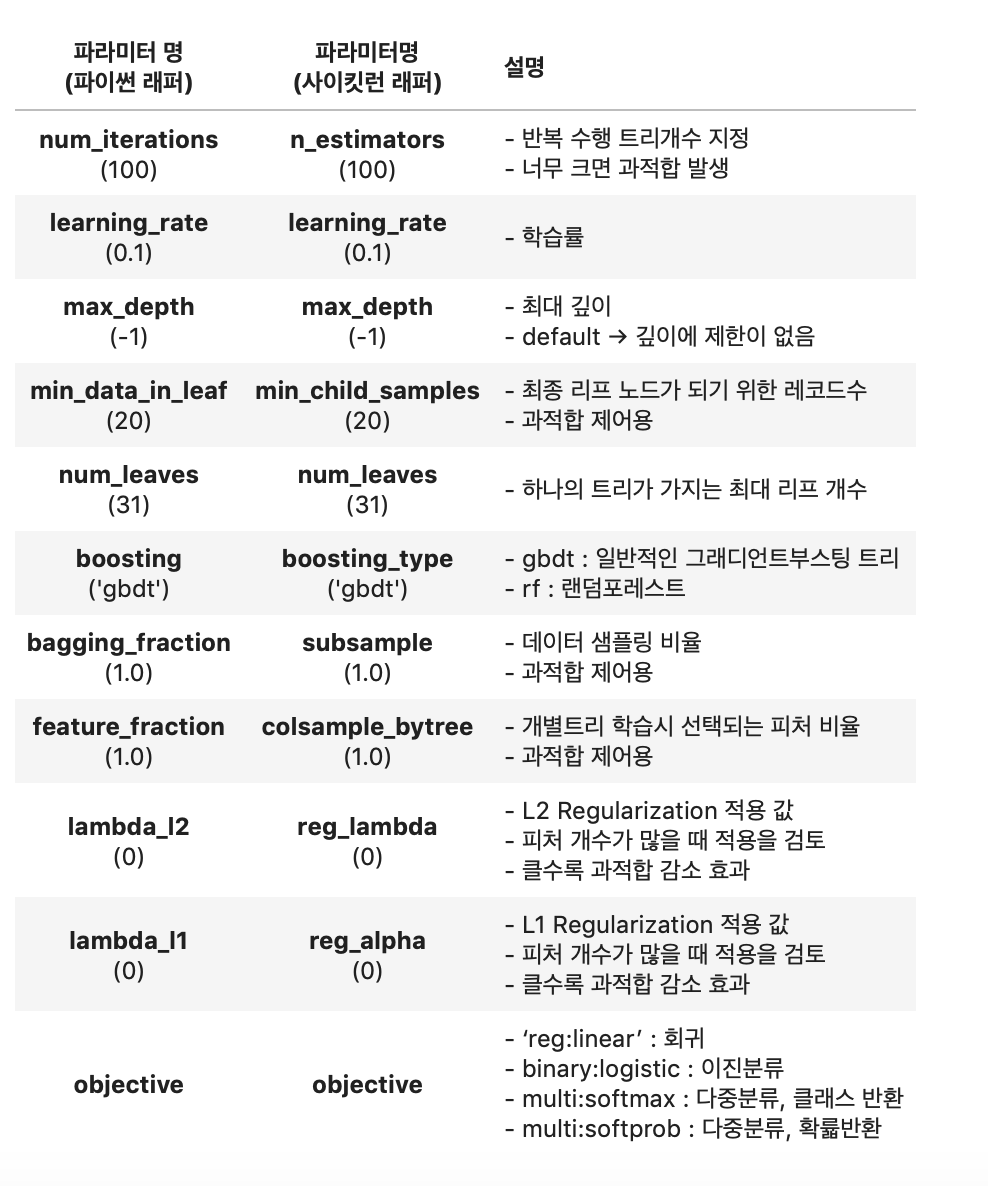

In [4]:
import lightgbm

print(lightgbm.__version__)

3.3.5


In [5]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정.
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

학습된 LightGBM 모델을 기반으로 예측 성능을 평가

In [7]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9877


* 피처 중요도를 시각화

LightGBM도 plot_importance() 를 통해 시각화 가능

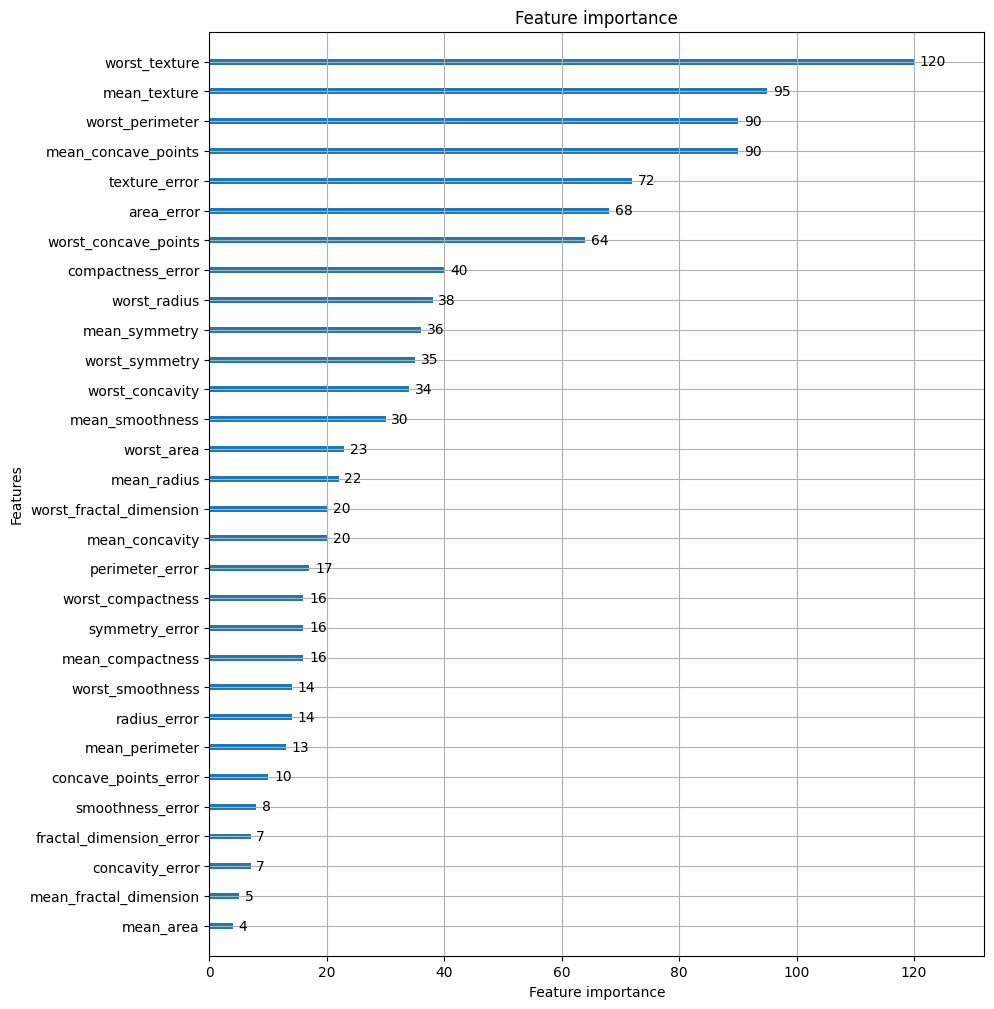

In [8]:
# plot_importance( )를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)
plt.savefig('lightgbm_feature_importance.tif', format='tif', dpi=300, bbox_inches='tight')

#### 베이지안 최적화

\
1. 랜덤하게 하이퍼 파라미터를 샘플링하고 성능 결과 관측

2. 관측된 값을 기반으로 대체 모델은 최적 함수 및 신뢰 구간 (= 결과 오류 편차 = 추정 함수의 불확실성을 의미) 를 추정

3. 추정된 최적 함수를 기반으로 획득 함수는 다음으로 관찰할 하이퍼 파라미터를 계산 후 이를 대체 모델에 전달

4. 획득 함수로부터 전달된 하이퍼 파라미터를 수행하여 관측된 값을 기반으로 대체 모델 다시 갱신

5. 2번 ~ 4번을 반복하며 대체 모델의 불확실성 개선 및 점차 정확한 최적 함수 추정 가능

In [9]:
#pip install hyperopt

In [10]:
import hyperopt

print(hyperopt.__version__)

0.2.7


In [11]:
from hyperopt import hp

# -10 ~ 10까지 1간격을 가지는 입력 변수 x와 -15 ~ 15까지 1간격으로 입력 변수 y 설정.
search_space = {'x': hp.quniform('x', -10, 10, 1), 'y': hp.quniform('y', -15, 15, 1) }

* 목적 함수 생성

In [12]:
from hyperopt import STATUS_OK

# 목적 함수를 생성. 변숫값과 변수 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정 값을 반환
def objective_func(search_space):
    x = search_space['x']
    y = search_space['y']
    retval = x**2 - 20*y
    
    return retval

* 목적 함수의 반환 값이 최소가 될 수 있는 최적의 입력 값을 베이지안 최적화 기법에 기반하여 찾아야 함

* HyperOpt는 이러한 기능을 fmin() 함수를 통해 제공함

In [13]:
from hyperopt import fmin, tpe, Trials
import numpy as np

# 입력 결괏값을 저장한 Trials 객체값 생성.
trial_val = Trials()

# 목적 함수의 최솟값을 반환하는 최적 입력 변숫값을 5번의 입력값 시도(max_evals=5)로 찾아냄.
best_01 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=5
               , trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_01)

100%|██████████| 5/5 [00:00<00:00, 279.42trial/s, best loss: -224.0]
best: {'x': -4.0, 'y': 12.0}


In [14]:
trial_val = Trials()

# max_evals를 20회로 늘려서 재테스트
best_02 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=20
               , trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_02)

100%|██████████| 20/20 [00:00<00:00, 525.16trial/s, best loss: -296.0]
best: {'x': 2.0, 'y': 15.0}


In [15]:
# fmin( )에 인자로 들어가는 Trials 객체의 result 속성에 파이썬 리스트로 목적 함수 반환값들이 저장됨
# 리스트 내부의 개별 원소는 {'loss':함수 반환값, 'status':반환 상태값} 와 같은 딕셔너리임. 
print(trial_val.results)

[{'loss': -64.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 281.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': -164.0, 'status': 'ok'}, {'loss': 21.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 284.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': -171.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]


In [16]:
# Trials 객체의 vals 속성에 {'입력변수명':개별 수행 시마다 입력된 값 리스트} 형태로 저장됨.
print(trial_val.vals)

{'x': [-6.0, -4.0, 4.0, -4.0, 9.0, 2.0, 10.0, -9.0, -8.0, -0.0, -0.0, 1.0, 9.0, 6.0, 9.0, 2.0, -2.0, -4.0, 7.0, -0.0], 'y': [5.0, 10.0, -2.0, 12.0, 1.0, 15.0, 7.0, -10.0, 0.0, -5.0, -3.0, 2.0, 4.0, 10.0, 3.0, 3.0, -14.0, -8.0, 11.0, -0.0]}


In [17]:
import pandas as pd

# results에서 loss 키값에 해당하는 밸류들을 추출하여 list로 생성. 
losses = [loss_dict['loss'] for loss_dict in trial_val.results]

# DataFrame으로 생성.
result_df = pd.DataFrame({'x': trial_val.vals['x'], 'y': trial_val.vals['y'], 'losses': losses})
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


## HyperOpt를 이용한 XGBoost 하이퍼 파라미터 최적화

Grid Search 방식의 장단점

장점 : 성능이 매우 뛰어남

단점 : 튜닝해야 할 파라미터 개수가 많을 경우, 수행 시간이 매우 오래 걸림

* **베이지안 최적화 단계**

\
1. 랜덤하게 하이퍼 파라미터를 샘플링하고 성능 결과 관측

2. 관측된 값을 기반으로 대체 모델은 최적 함수 및 신뢰 구간 (= 결과값 오류 편차 = 추정 함수의 불확실성) 를 추정

3. 추정된 최적 함수를 기반으로 획득 함수는 다음으로 관찰할 하이퍼 파라미터를 계산 후 이를 대체 모델에 전달

4. 획득 함수로는 다음으로 관측할 하이퍼 파라미터 값을 계산 -> 다음에 관측할 하이퍼 파라미터를 대체 모델에 전달

HyperOpt를 사용하여 XGBoost 하이퍼 파라미터를 최적화 해본다.

\
* 과정

\
1. 검색 공간 설정

2. 목적 함수 설정

3. fmin() 적용 -> 최적 하이퍼 파라미터 도출

\
주의사항은 아래와 같다.

\
* HyperOpt는 입력 값과 반환 값이 모두 실수형이기 때문에 정수형 하이퍼 파라미터 입력 시 형변환 필요

* HyperOpt는 목적 함수의 최솟값을 반환할 수 있도록 최적화하는 것이기 때문에 성능 값이 클수록 좋은 성능 지표일 경우 -1을 곱해주어야 함

In [18]:
# 아래 코드는 이전에 수록된 코드라 책에는 싣지 않았습니다. 
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

In [19]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

# 앞에서 추출한 학습 데이터를 다시 학습과 검증 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

* 하이퍼 파라미터 검색 공간 설정

In [20]:
from hyperopt import hp

# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색.
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 20, 1), 
                    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                   }

* 목적 함수를 설정

In [21]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임.
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함.
# 정확도는 높을수록 더 좋은 수치임. -1 * 정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환
def objective_func(search_space):
    # 수행 시간 절약을 위해 nestimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            learning_rate=search_space['learning_rate'],
                            colsample_bytree=search_space['colsample_bytree'],
                            eval_metric='logloss')
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)
    
    # accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함.
    return {'loss':-1 * np.mean(accuracy), 'status': STATUS_OK}


* fmin()을 이용해 최적 하이퍼 파라미터 도출

In [22]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trial_val, rstate=np.random.default_rng(seed=9))
print('best:', best)


100%|██████████| 50/50 [00:18<00:00,  2.76trial/s, best loss: -0.9670616939700244]
best: {'colsample_bytree': 0.9599446282177103, 'learning_rate': 0.15480405522751015, 'max_depth': 6.0, 'min_child_weight': 2.0}


* 추출된 최적 하이퍼 파라미터를 직접 XGBClassifier에 인자로 입력하기 전 변환

\- 정수형 하이퍼 파라미터는 정수형으로 형 변환

\- 실수형 파라미터는 소수점 5자리까지만 변환 후 확인

In [23]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(
    round(best['colsample_bytree'], 5), round(best['learning_rate'], 5),
    int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.95994, learning_rate:0.1548, max_depth:6, min_child_weight:2


* 모델을 재학습

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

* 모델 성능 평가

In [ ]:
xgb_wrapper = XGBClassifier(n_estimators=400,
                            learning_rate=round(best['learning_rate'], 5),
                            max_depth=int(best['max_depth']),
                            min_child_weight=int(best['min_child_weight']),
                            colsample_bytree=round(best['colsample_bytree'], 5)
                           )

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss',
                eval_set=evals, verbose=True)

preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, preds, pred_proba)


## 캐글 산탄데르 고객 만족 예측

### 데이터 전처리

* 데이터 로딩

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

cust_df = pd.read_csv('/대학/CUAI/train_santander.csv', encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


* 데이터 확인


\- 370개의 feature, 1개의 class 열로 구성된 dataframe

\- 260개의 정수형 feature, 111개의 실수형 feature로 구성됨

\- 결측값은 없음

In [ ]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [ ]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


* describe()를 이용하여 각 피처의 값 분포를 간단히 확인

\
var3의 경우 min 값이 -999999

해당 값은 NaN 또는 이상치 값에 해당되므로 최빈값인 2로 변환

In [ ]:
cust_df.describe( )

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [ ]:
cust_df['var3'].value_counts()

 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 231           1
 188           1
 168           1
 135           1
 87            1
Name: var3, Length: 208, dtype: int64

In [ ]:
# var3 피처 값 대체 및 ID 피처 드롭
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

# 피처 세트와 레이블 세트분리. 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))


피처 데이터 shape:(76020, 369)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [ ]:
# X_train, y_train을 다시 학습과 검증 데이터 세트로 분리. 
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.3, random_state=0)

### XGBoost 모델 학습과 하이퍼 파라미터 튜닝

* XGBClassifier를 기반으로 학습을 수행

학습을 진행한 뒤 데이터 세트로 평가된 ROC-AUC 값을 확인하기

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, learning_rate 0.05, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정. 
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행. 
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.99349	validation_1-auc:0.93137
[1]	validation_0-auc:0.99387	validation_1-auc:0.93274
[2]	validation_0-auc:0.99399	validation_1-auc:0.93263
[3]	validation_0-auc:0.99374	validation_1-auc:0.93171
[4]	validation_0-auc:0.99761	validation_1-auc:0.94152
[5]	validation_0-auc:0.99744	validation_1-auc:0.94129
[6]	validation_0-auc:0.99784	validation_1-auc:0.94129
[7]	validation_0-auc:0.99805	validation_1-auc:0.95406
[8]	validation_0-auc:0.99809	validation_1-auc:0.95406
[9]	validation_0-auc:0.99817	validation_1-auc:0.95497
[10]	validation_0-auc:0.99838	validation_1-auc:0.95748
[11]	validation_0-auc:0.99846	validation_1-auc:0.95702
[12]	validation_0-auc:0.99850	validation_1-auc:0.95600
[13]	validation_0-auc:0.99892	validation_1-auc:0.96329
[14]	validation_0-auc:0.99900	validation_1-auc:0.96398
[15]	validation_0-auc:0.99888	validation_1-auc:0.96352
[16]	validation_0-auc:0.99917	validation_1-auc:0.96591
[17]	validation_0-auc:0.99904	validation_1-auc:0.96591
[18]	validation_0-au

* HyperOpt를 이용하여 베이지안 최적화 기반으로 XGBoost의 하이퍼 파라미터 튜닝을 수행

In [ ]:
from hyperopt import hp

# max_depth는 5에서 15까지 1간격으로, min_child_weight는 1에서 6까지 1간격으로
# colsample_bytree는 0.5에서 0.95사이, learning_rate는 0.01에서 0.2사이 정규 분포된 값으로 검색. 

xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 15, 1), 
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
}

* 목적 함수 생성

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# 목적 함수 설정. 
# 추후 fmin()에서 입력된 search_space값으로 XGBClassifier 교차 검증 학습 후 -1* roc_auc 평균 값을 반환.  
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            colsample_bytree=search_space['colsample_bytree'],
                            learning_rate=search_space['learning_rate']
                           )
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list= []
    
    # 3개 k-fold방식 적용 
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리 
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행. 
        xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric='auc',
                   eval_set=[(X_tr, y_tr), (X_val, y_val)])
    
        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음. 
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)
        
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되, 
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환. 
    return -1 * np.mean(roc_auc_list)

* fmin() 함수를 호출해 max_eval=50회만큼 반복하면서 최적의 하이퍼 파라미터를 도출

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[62]	validation_0-auc:0.99995	validation_1-auc:0.99271
[63]	validation_0-auc:0.99995	validation_1-auc:0.99271
[64]	validation_0-auc:0.99995	validation_1-auc:0.99289
[65]	validation_0-auc:0.99995	validation_1-auc:0.99271
[66]	validation_0-auc:0.99995	validation_1-auc:0.99253
[67]	validation_0-auc:0.99995	validation_1-auc:0.99253
[68]	validation_0-auc:0.99995	validation_1-auc:0.99253
[69]	validation_0-auc:0.99995	validation_1-auc:0.99253
[70]	validation_0-auc:0.99995	validation_1-auc:0.99289
[71]	validation_0-auc:0.99995	validation_1-auc:0.99289
[72]	validation_0-auc:0.99995	validation_1-auc:0.99289
[73]	validation_0-auc:0.99995	validation_1-auc:0.99289
[74]	validation_0-auc:0.99995	validation_1-auc:0.99289
[75]	validation_0-auc:0.99995	validation_1-auc:0.99289
[76]	validation_0-auc:0.99995	validation_1-auc:0.99289
[77]	validation_0-auc:0.99995	validation_1-auc:0.99307
[78]	validation_0-auc:0.99995	validation_1-auc:0.99307
[79]	validation_0-auc:0.99995

* 도출된 최적 하이퍼 파라미터를 기반으로 XGBClassifier를 재학습

* 테스트 데이터 세트에서 ROC AUC를 측정

* n_estimater는 500으로 증가

In [ ]:
# n_estimators를 500증가 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행.
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=round(best['learning_rate'], 5),
                        max_depth=int(best['max_depth']), min_child_weight=int(best['min_child_weight']), 
                        colsample_bytree=round(best['colsample_bytree'], 5)   
                       )

# evaluation metric을 auc로, early stopping은 100 으로 설정하고 학습 수행. 
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, 
            eval_metric="auc",eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.98753	validation_1-auc:0.92750
[1]	validation_0-auc:0.99102	validation_1-auc:0.95052
[2]	validation_0-auc:0.99591	validation_1-auc:0.96717
[3]	validation_0-auc:0.99611	validation_1-auc:0.97572
[4]	validation_0-auc:0.99792	validation_1-auc:0.97629
[5]	validation_0-auc:0.99763	validation_1-auc:0.97800
[6]	validation_0-auc:0.99817	validation_1-auc:0.97629
[7]	validation_0-auc:0.99800	validation_1-auc:0.97948
[8]	validation_0-auc:0.99850	validation_1-auc:0.97880
[9]	validation_0-auc:0.99838	validation_1-auc:0.97994
[10]	validation_0-auc:0.99846	validation_1-auc:0.98039
[11]	validation_0-auc:0.99867	validation_1-auc:0.98723
[12]	validation_0-auc:0.99846	validation_1-auc:0.98814
[13]	validation_0-auc:0.99842	validation_1-auc:0.98837
[14]	validation_0-auc:0.99867	validation_1-auc:0.98746
[15]	validation_0-auc:0.99879	validation_1-auc:0.98860
[16]	validation_0-auc:0.99900	validation_1-auc:0.98883
[17]	validation_0-auc:0.99904	validation_1-auc:0.98860
[18]	validation_0-au

* 각 피처의 중요도를 피처 중요도 그래프로 나타내기

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

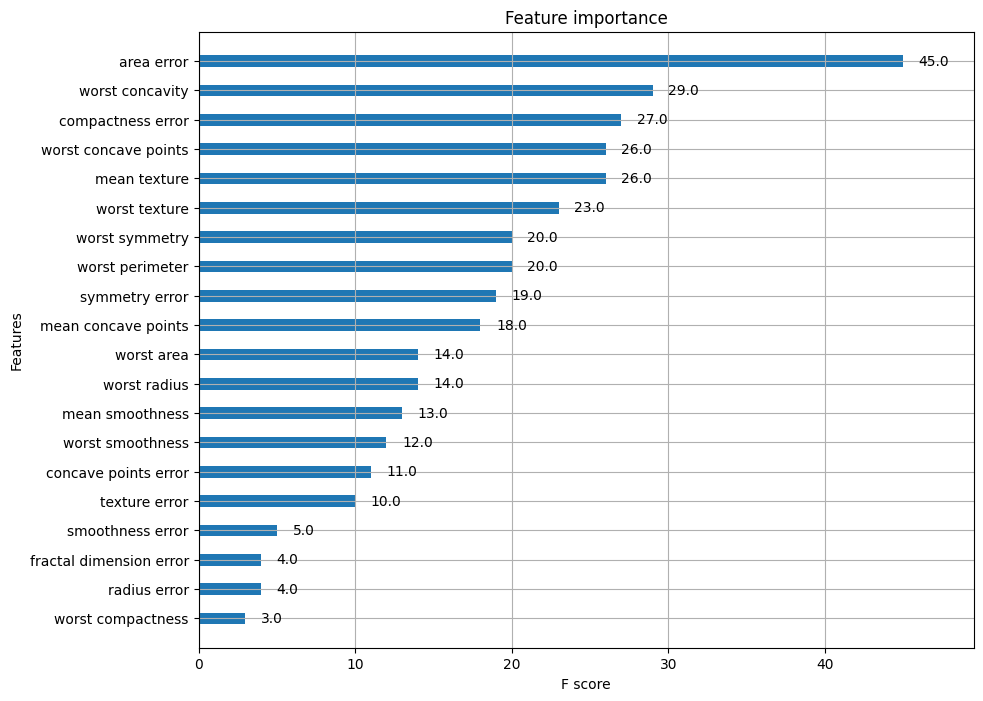

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax , max_num_features=20,height=0.4)

### LightGBM 모델 학습과 하이퍼 파라미터 튜닝

* 학습 및 ROC-AUC 값 확인

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

eval_set=[(X_tr, y_tr), (X_val, y_val)]
lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric="auc", eval_set=eval_set)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	training's auc: 0.82625	training's binary_logloss: 0.15523	valid_1's auc: 0.809814	valid_1's binary_logloss: 0.15774
[2]	training's auc: 0.833899	training's binary_logloss: 0.149581	valid_1's auc: 0.81222	valid_1's binary_logloss: 0.153275
[3]	training's auc: 0.841789	training's binary_logloss: 0.145416	valid_1's auc: 0.814833	valid_1's binary_logloss: 0.149999
[4]	training's auc: 0.847243	training's binary_logloss: 0.14212	valid_1's auc: 0.819406	valid_1's binary_logloss: 0.147524
[5]	training's auc: 0.849589	training's binary_logloss: 0.139438	valid_1's auc: 0.821869	valid_1's binary_logloss: 0.145464
[6]	training's auc: 0.853413	training's binary_logloss: 0.137254	valid_1's auc: 0.820878	valid_1's binary_logloss: 0.143973
[7]	training's auc: 0.85551	training's binary_logloss: 0.1354	valid_1's auc: 0.821815	valid_1's binary_logloss: 0.142746
[8]	training's auc: 0.858698	training's binary_logloss: 0.133561	valid_1's auc: 0.823733	valid_1's binary_logloss: 0.141592
[9]	training's a

[92]	training's auc: 0.933882	training's binary_logloss: 0.100834	valid_1's auc: 0.830966	valid_1's binary_logloss: 0.13606
[93]	training's auc: 0.934042	training's binary_logloss: 0.100677	valid_1's auc: 0.830691	valid_1's binary_logloss: 0.136126
[94]	training's auc: 0.934515	training's binary_logloss: 0.100417	valid_1's auc: 0.830759	valid_1's binary_logloss: 0.136153
[95]	training's auc: 0.934868	training's binary_logloss: 0.100212	valid_1's auc: 0.830436	valid_1's binary_logloss: 0.136221
[96]	training's auc: 0.935009	training's binary_logloss: 0.1001	valid_1's auc: 0.830566	valid_1's binary_logloss: 0.136227
[97]	training's auc: 0.935251	training's binary_logloss: 0.0999167	valid_1's auc: 0.830664	valid_1's binary_logloss: 0.13623
[98]	training's auc: 0.935506	training's binary_logloss: 0.0997379	valid_1's auc: 0.830618	valid_1's binary_logloss: 0.13627
[99]	training's auc: 0.935882	training's binary_logloss: 0.0995979	valid_1's auc: 0.830275	valid_1's binary_logloss: 0.136349
[1

* 검색 공간 설정

In [ ]:
lgbm_search_space = {'num_leaves': hp.quniform('num_leaves', 32, 64, 1),
                     'max_depth': hp.quniform('max_depth', 100, 160, 1),
                     'min_child_samples': hp.quniform('min_child_samples', 60, 100, 1),
                     'subsample': hp.uniform('subsample', 0.7, 1),
                     'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
                    }

* 목적 함수를 생성

앞의 XGBoost와 크게 다르지 않음
LGBMClassifier 객체를 생성하는 부분만 달라짐

In [ ]:
def objective_func(search_space):
    lgbm_clf =  LGBMClassifier(n_estimators=100, num_leaves=int(search_space['num_leaves']),
                               max_depth=int(search_space['max_depth']),
                               min_child_samples=int(search_space['min_child_samples']), 
                               subsample=search_space['subsample'],
                               learning_rate=search_space['learning_rate'])
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []
    
    # 3개 k-fold방식 적용 
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리 
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행. 
        lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_tr, y_tr), (X_val, y_val)])

        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음.
        score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:, 1]) 
        roc_auc_list.append(score)
    
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되, 
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
    return -1*np.mean(roc_auc_list)

* fmin()함수를 호출, 최적 하이퍼 파라미터 도출

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출. 
best = fmin(fn=objective_func, space=lgbm_search_space, algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

[1]	training's auc: 0.82736	training's binary_logloss: 0.162294	valid_1's auc: 0.804818	valid_1's binary_logloss: 0.163544
[2]	training's auc: 0.828309	training's binary_logloss: 0.160269	valid_1's auc: 0.804585	valid_1's binary_logloss: 0.161866
[3]	training's auc: 0.833368	training's binary_logloss: 0.158478	valid_1's auc: 0.806871	valid_1's binary_logloss: 0.16038
[4]	training's auc: 0.834671	training's binary_logloss: 0.156852	valid_1's auc: 0.80706	valid_1's binary_logloss: 0.159053
[5]	training's auc: 0.837783	training's binary_logloss: 0.155354	valid_1's auc: 0.811645	valid_1's binary_logloss: 0.157793
[6]	training's auc: 0.839052	training's binary_logloss: 0.153966	valid_1's auc: 0.81271	valid_1's binary_logloss: 0.156635
[7]	training's auc: 0.841216	training's binary_logloss: 0.152691	valid_1's auc: 0.815103	valid_1's binary_logloss: 0.155585
[8]	training's auc: 0.841859	training's binary_logloss: 0.151499	valid_1's auc: 0.814773	valid_1's binary_logloss: 0.154617
[9]	training

[66]	training's auc: 0.876244	training's binary_logloss: 0.126639	valid_1's auc: 0.829919	valid_1's binary_logloss: 0.137223
[67]	training's auc: 0.876733	training's binary_logloss: 0.126457	valid_1's auc: 0.829943	valid_1's binary_logloss: 0.137148
[68]	training's auc: 0.877004	training's binary_logloss: 0.126282	valid_1's auc: 0.829954	valid_1's binary_logloss: 0.137083
[69]	training's auc: 0.87756	training's binary_logloss: 0.1261	valid_1's auc: 0.830128	valid_1's binary_logloss: 0.137018
[70]	training's auc: 0.87797	training's binary_logloss: 0.12593	valid_1's auc: 0.830009	valid_1's binary_logloss: 0.136959
[71]	training's auc: 0.878271	training's binary_logloss: 0.125757	valid_1's auc: 0.83006	valid_1's binary_logloss: 0.136874
[72]	training's auc: 0.878636	training's binary_logloss: 0.125587	valid_1's auc: 0.830076	valid_1's binary_logloss: 0.136826
[73]	training's auc: 0.879184	training's binary_logloss: 0.125399	valid_1's auc: 0.830085	valid_1's binary_logloss: 0.136789
[74]	t

[31]	training's auc: 0.860346	training's binary_logloss: 0.138259	valid_1's auc: 0.835652	valid_1's binary_logloss: 0.137767
[32]	training's auc: 0.860623	training's binary_logloss: 0.137851	valid_1's auc: 0.835706	valid_1's binary_logloss: 0.137481
[33]	training's auc: 0.861233	training's binary_logloss: 0.137451	valid_1's auc: 0.835552	valid_1's binary_logloss: 0.137215
[34]	training's auc: 0.861685	training's binary_logloss: 0.137067	valid_1's auc: 0.835533	valid_1's binary_logloss: 0.136967
[35]	training's auc: 0.862184	training's binary_logloss: 0.136698	valid_1's auc: 0.835406	valid_1's binary_logloss: 0.136728
[36]	training's auc: 0.862667	training's binary_logloss: 0.136338	valid_1's auc: 0.835312	valid_1's binary_logloss: 0.136482
[37]	training's auc: 0.862991	training's binary_logloss: 0.135983	valid_1's auc: 0.835197	valid_1's binary_logloss: 0.136257
[38]	training's auc: 0.863528	training's binary_logloss: 0.135648	valid_1's auc: 0.835072	valid_1's binary_logloss: 0.136031


[34]	training's auc: 0.858306	training's binary_logloss: 0.13423	valid_1's auc: 0.831793	valid_1's binary_logloss: 0.143018
[35]	training's auc: 0.858929	training's binary_logloss: 0.133883	valid_1's auc: 0.831932	valid_1's binary_logloss: 0.142746
[36]	training's auc: 0.859609	training's binary_logloss: 0.133542	valid_1's auc: 0.832139	valid_1's binary_logloss: 0.142495
[37]	training's auc: 0.860114	training's binary_logloss: 0.133199	valid_1's auc: 0.832296	valid_1's binary_logloss: 0.142265
[38]	training's auc: 0.860777	training's binary_logloss: 0.132855	valid_1's auc: 0.832378	valid_1's binary_logloss: 0.142016
[39]	training's auc: 0.861056	training's binary_logloss: 0.132533	valid_1's auc: 0.832541	valid_1's binary_logloss: 0.141797
[40]	training's auc: 0.861747	training's binary_logloss: 0.132224	valid_1's auc: 0.832606	valid_1's binary_logloss: 0.141578
[41]	training's auc: 0.862158	training's binary_logloss: 0.131929	valid_1's auc: 0.832747	valid_1's binary_logloss: 0.141381
[

[99]	training's auc: 0.885685	training's binary_logloss: 0.121466	valid_1's auc: 0.837478	valid_1's binary_logloss: 0.136439
[100]	training's auc: 0.886052	training's binary_logloss: 0.121345	valid_1's auc: 0.837486	valid_1's binary_logloss: 0.136434
[1]	training's auc: 0.840138	training's binary_logloss: 0.15221	valid_1's auc: 0.812785	valid_1's binary_logloss: 0.155558
[2]	training's auc: 0.84777	training's binary_logloss: 0.145745	valid_1's auc: 0.815828	valid_1's binary_logloss: 0.150616
[3]	training's auc: 0.857571	training's binary_logloss: 0.141216	valid_1's auc: 0.821962	valid_1's binary_logloss: 0.147259
[4]	training's auc: 0.861358	training's binary_logloss: 0.137643	valid_1's auc: 0.824181	valid_1's binary_logloss: 0.144869
[5]	training's auc: 0.866559	training's binary_logloss: 0.134811	valid_1's auc: 0.825962	valid_1's binary_logloss: 0.14308
[6]	training's auc: 0.869278	training's binary_logloss: 0.132436	valid_1's auc: 0.827506	valid_1's binary_logloss: 0.141548
[7]	trai

[26]	training's auc: 0.912142	training's binary_logloss: 0.113763	valid_1's auc: 0.834075	valid_1's binary_logloss: 0.131343
[27]	training's auc: 0.913719	training's binary_logloss: 0.113067	valid_1's auc: 0.833813	valid_1's binary_logloss: 0.131392
[28]	training's auc: 0.915337	training's binary_logloss: 0.112479	valid_1's auc: 0.83399	valid_1's binary_logloss: 0.131391
[29]	training's auc: 0.917253	training's binary_logloss: 0.11188	valid_1's auc: 0.833599	valid_1's binary_logloss: 0.131448
[30]	training's auc: 0.918443	training's binary_logloss: 0.111286	valid_1's auc: 0.833538	valid_1's binary_logloss: 0.131427
[31]	training's auc: 0.919457	training's binary_logloss: 0.110746	valid_1's auc: 0.833293	valid_1's binary_logloss: 0.131479
[32]	training's auc: 0.920976	training's binary_logloss: 0.110085	valid_1's auc: 0.833202	valid_1's binary_logloss: 0.131461
[33]	training's auc: 0.922191	training's binary_logloss: 0.109456	valid_1's auc: 0.83292	valid_1's binary_logloss: 0.13157
[34]

[5]	training's auc: 0.855483	training's binary_logloss: 0.145139	valid_1's auc: 0.820538	valid_1's binary_logloss: 0.149919
[6]	training's auc: 0.856827	training's binary_logloss: 0.14298	valid_1's auc: 0.821063	valid_1's binary_logloss: 0.148333
[7]	training's auc: 0.858639	training's binary_logloss: 0.14107	valid_1's auc: 0.821902	valid_1's binary_logloss: 0.146983
[8]	training's auc: 0.859908	training's binary_logloss: 0.139361	valid_1's auc: 0.822497	valid_1's binary_logloss: 0.145726
[9]	training's auc: 0.863745	training's binary_logloss: 0.137787	valid_1's auc: 0.824282	valid_1's binary_logloss: 0.14463
[10]	training's auc: 0.864538	training's binary_logloss: 0.136428	valid_1's auc: 0.825618	valid_1's binary_logloss: 0.143613
[11]	training's auc: 0.866724	training's binary_logloss: 0.135202	valid_1's auc: 0.826482	valid_1's binary_logloss: 0.142771
[12]	training's auc: 0.867727	training's binary_logloss: 0.134076	valid_1's auc: 0.826391	valid_1's binary_logloss: 0.142056
[13]	tra

[19]	training's auc: 0.876474	training's binary_logloss: 0.130177	valid_1's auc: 0.836385	valid_1's binary_logloss: 0.133702
[20]	training's auc: 0.8775	training's binary_logloss: 0.129479	valid_1's auc: 0.836202	valid_1's binary_logloss: 0.133362
[21]	training's auc: 0.878491	training's binary_logloss: 0.128823	valid_1's auc: 0.835944	valid_1's binary_logloss: 0.133095
[22]	training's auc: 0.879727	training's binary_logloss: 0.128171	valid_1's auc: 0.835803	valid_1's binary_logloss: 0.132857
[23]	training's auc: 0.880833	training's binary_logloss: 0.127616	valid_1's auc: 0.835788	valid_1's binary_logloss: 0.132656
[24]	training's auc: 0.881877	training's binary_logloss: 0.127021	valid_1's auc: 0.836304	valid_1's binary_logloss: 0.132396
[25]	training's auc: 0.882678	training's binary_logloss: 0.126477	valid_1's auc: 0.835986	valid_1's binary_logloss: 0.132262
[26]	training's auc: 0.883555	training's binary_logloss: 0.125961	valid_1's auc: 0.835858	valid_1's binary_logloss: 0.13208
[27

[7]	training's auc: 0.856989	training's binary_logloss: 0.140392	valid_1's auc: 0.828256	valid_1's binary_logloss: 0.148457
[8]	training's auc: 0.859909	training's binary_logloss: 0.138736	valid_1's auc: 0.828911	valid_1's binary_logloss: 0.14717
[9]	training's auc: 0.860832	training's binary_logloss: 0.137248	valid_1's auc: 0.828917	valid_1's binary_logloss: 0.146114
[10]	training's auc: 0.862409	training's binary_logloss: 0.135939	valid_1's auc: 0.829175	valid_1's binary_logloss: 0.145124
[11]	training's auc: 0.863555	training's binary_logloss: 0.134642	valid_1's auc: 0.829481	valid_1's binary_logloss: 0.144268
[12]	training's auc: 0.864843	training's binary_logloss: 0.133431	valid_1's auc: 0.829963	valid_1's binary_logloss: 0.143463
[13]	training's auc: 0.866107	training's binary_logloss: 0.13233	valid_1's auc: 0.830554	valid_1's binary_logloss: 0.142752
[14]	training's auc: 0.868249	training's binary_logloss: 0.131313	valid_1's auc: 0.830759	valid_1's binary_logloss: 0.14214
[15]	t

[5]	training's auc: 0.863741	training's binary_logloss: 0.137779	valid_1's auc: 0.824119	valid_1's binary_logloss: 0.145182
[6]	training's auc: 0.867855	training's binary_logloss: 0.135354	valid_1's auc: 0.824776	valid_1's binary_logloss: 0.143786
[7]	training's auc: 0.871623	training's binary_logloss: 0.13321	valid_1's auc: 0.826166	valid_1's binary_logloss: 0.14244
[8]	training's auc: 0.873921	training's binary_logloss: 0.131346	valid_1's auc: 0.827566	valid_1's binary_logloss: 0.141253
[9]	training's auc: 0.876897	training's binary_logloss: 0.129658	valid_1's auc: 0.828699	valid_1's binary_logloss: 0.140338
[10]	training's auc: 0.881018	training's binary_logloss: 0.128185	valid_1's auc: 0.828684	valid_1's binary_logloss: 0.139621
[11]	training's auc: 0.883713	training's binary_logloss: 0.126777	valid_1's auc: 0.829464	valid_1's binary_logloss: 0.138944
[12]	training's auc: 0.885586	training's binary_logloss: 0.125579	valid_1's auc: 0.829263	valid_1's binary_logloss: 0.138435
[13]	tr

[25]	training's auc: 0.907057	training's binary_logloss: 0.116193	valid_1's auc: 0.834743	valid_1's binary_logloss: 0.13117
[26]	training's auc: 0.908271	training's binary_logloss: 0.115576	valid_1's auc: 0.83419	valid_1's binary_logloss: 0.131239
[27]	training's auc: 0.910741	training's binary_logloss: 0.114927	valid_1's auc: 0.833715	valid_1's binary_logloss: 0.131226
[28]	training's auc: 0.912008	training's binary_logloss: 0.114368	valid_1's auc: 0.834214	valid_1's binary_logloss: 0.131124
[29]	training's auc: 0.91352	training's binary_logloss: 0.113764	valid_1's auc: 0.83465	valid_1's binary_logloss: 0.13107
[30]	training's auc: 0.915049	training's binary_logloss: 0.113149	valid_1's auc: 0.834696	valid_1's binary_logloss: 0.131122
[31]	training's auc: 0.916345	training's binary_logloss: 0.112573	valid_1's auc: 0.835036	valid_1's binary_logloss: 0.131037
[32]	training's auc: 0.917819	training's binary_logloss: 0.112042	valid_1's auc: 0.83531	valid_1's binary_logloss: 0.131005
[33]	t

[22]	training's auc: 0.90492	training's binary_logloss: 0.115354	valid_1's auc: 0.831076	valid_1's binary_logloss: 0.138095
[23]	training's auc: 0.905935	training's binary_logloss: 0.114692	valid_1's auc: 0.83124	valid_1's binary_logloss: 0.138023
[24]	training's auc: 0.907096	training's binary_logloss: 0.114059	valid_1's auc: 0.83079	valid_1's binary_logloss: 0.137978
[25]	training's auc: 0.908588	training's binary_logloss: 0.113395	valid_1's auc: 0.830625	valid_1's binary_logloss: 0.137932
[26]	training's auc: 0.909877	training's binary_logloss: 0.112697	valid_1's auc: 0.831749	valid_1's binary_logloss: 0.13783
[27]	training's auc: 0.911142	training's binary_logloss: 0.112069	valid_1's auc: 0.831299	valid_1's binary_logloss: 0.137885
[28]	training's auc: 0.912572	training's binary_logloss: 0.111454	valid_1's auc: 0.831311	valid_1's binary_logloss: 0.137854
[29]	training's auc: 0.914617	training's binary_logloss: 0.110839	valid_1's auc: 0.831487	valid_1's binary_logloss: 0.137792
[30]

[44]	training's auc: 0.903386	training's binary_logloss: 0.116708	valid_1's auc: 0.832147	valid_1's binary_logloss: 0.135673
[45]	training's auc: 0.904051	training's binary_logloss: 0.116363	valid_1's auc: 0.832101	valid_1's binary_logloss: 0.135655
[46]	training's auc: 0.905084	training's binary_logloss: 0.116011	valid_1's auc: 0.832359	valid_1's binary_logloss: 0.135612
[47]	training's auc: 0.90589	training's binary_logloss: 0.115647	valid_1's auc: 0.832228	valid_1's binary_logloss: 0.135623
[48]	training's auc: 0.90655	training's binary_logloss: 0.115347	valid_1's auc: 0.832248	valid_1's binary_logloss: 0.135605
[49]	training's auc: 0.907434	training's binary_logloss: 0.115002	valid_1's auc: 0.832089	valid_1's binary_logloss: 0.13564
[50]	training's auc: 0.908012	training's binary_logloss: 0.114685	valid_1's auc: 0.831989	valid_1's binary_logloss: 0.135677
[51]	training's auc: 0.908832	training's binary_logloss: 0.114351	valid_1's auc: 0.831922	valid_1's binary_logloss: 0.135685
[52

[33]	training's auc: 0.891775	training's binary_logloss: 0.123024	valid_1's auc: 0.834178	valid_1's binary_logloss: 0.131744
[34]	training's auc: 0.892702	training's binary_logloss: 0.122585	valid_1's auc: 0.833952	valid_1's binary_logloss: 0.131635
[35]	training's auc: 0.893461	training's binary_logloss: 0.122124	valid_1's auc: 0.83422	valid_1's binary_logloss: 0.131526
[36]	training's auc: 0.894087	training's binary_logloss: 0.121716	valid_1's auc: 0.834538	valid_1's binary_logloss: 0.131436
[37]	training's auc: 0.89494	training's binary_logloss: 0.121317	valid_1's auc: 0.834695	valid_1's binary_logloss: 0.131348
[38]	training's auc: 0.895563	training's binary_logloss: 0.12093	valid_1's auc: 0.834862	valid_1's binary_logloss: 0.131268
[39]	training's auc: 0.89639	training's binary_logloss: 0.120527	valid_1's auc: 0.8351	valid_1's binary_logloss: 0.131181
[40]	training's auc: 0.897276	training's binary_logloss: 0.120143	valid_1's auc: 0.834899	valid_1's binary_logloss: 0.131165
[41]	t

[22]	training's auc: 0.879315	training's binary_logloss: 0.126365	valid_1's auc: 0.834742	valid_1's binary_logloss: 0.139403
[23]	training's auc: 0.880364	training's binary_logloss: 0.125781	valid_1's auc: 0.835072	valid_1's binary_logloss: 0.13912
[24]	training's auc: 0.881943	training's binary_logloss: 0.125204	valid_1's auc: 0.83561	valid_1's binary_logloss: 0.13884
[25]	training's auc: 0.883272	training's binary_logloss: 0.12463	valid_1's auc: 0.835652	valid_1's binary_logloss: 0.138559
[26]	training's auc: 0.884765	training's binary_logloss: 0.12408	valid_1's auc: 0.836094	valid_1's binary_logloss: 0.138359
[27]	training's auc: 0.885506	training's binary_logloss: 0.123584	valid_1's auc: 0.835833	valid_1's binary_logloss: 0.138203
[28]	training's auc: 0.886849	training's binary_logloss: 0.123024	valid_1's auc: 0.835788	valid_1's binary_logloss: 0.138025
[29]	training's auc: 0.88783	training's binary_logloss: 0.122537	valid_1's auc: 0.835565	valid_1's binary_logloss: 0.137845
[30]	t

[31]	training's auc: 0.857411	training's binary_logloss: 0.142702	valid_1's auc: 0.825009	valid_1's binary_logloss: 0.147652
[32]	training's auc: 0.857697	training's binary_logloss: 0.142301	valid_1's auc: 0.825157	valid_1's binary_logloss: 0.147349
[33]	training's auc: 0.857794	training's binary_logloss: 0.141902	valid_1's auc: 0.825358	valid_1's binary_logloss: 0.147045
[34]	training's auc: 0.858076	training's binary_logloss: 0.141519	valid_1's auc: 0.825266	valid_1's binary_logloss: 0.146764
[35]	training's auc: 0.858158	training's binary_logloss: 0.141147	valid_1's auc: 0.825423	valid_1's binary_logloss: 0.146486
[36]	training's auc: 0.858428	training's binary_logloss: 0.140788	valid_1's auc: 0.825706	valid_1's binary_logloss: 0.146206
[37]	training's auc: 0.859321	training's binary_logloss: 0.140437	valid_1's auc: 0.82657	valid_1's binary_logloss: 0.145924
[38]	training's auc: 0.859658	training's binary_logloss: 0.140095	valid_1's auc: 0.826972	valid_1's binary_logloss: 0.145648
[

[96]	training's auc: 0.874544	training's binary_logloss: 0.128177	valid_1's auc: 0.829916	valid_1's binary_logloss: 0.138077
[97]	training's auc: 0.874881	training's binary_logloss: 0.128043	valid_1's auc: 0.829996	valid_1's binary_logloss: 0.138012
[98]	training's auc: 0.875162	training's binary_logloss: 0.127906	valid_1's auc: 0.83007	valid_1's binary_logloss: 0.137948
[99]	training's auc: 0.875425	training's binary_logloss: 0.127775	valid_1's auc: 0.830062	valid_1's binary_logloss: 0.13788
[100]	training's auc: 0.875754	training's binary_logloss: 0.127637	valid_1's auc: 0.830052	valid_1's binary_logloss: 0.137831
[1]	training's auc: 0.82749	training's binary_logloss: 0.16565	valid_1's auc: 0.813829	valid_1's binary_logloss: 0.159659
[2]	training's auc: 0.830751	training's binary_logloss: 0.16443	valid_1's auc: 0.816626	valid_1's binary_logloss: 0.158641
[3]	training's auc: 0.831422	training's binary_logloss: 0.163283	valid_1's auc: 0.817276	valid_1's binary_logloss: 0.157694
[4]	tra

[61]	training's auc: 0.865047	training's binary_logloss: 0.136216	valid_1's auc: 0.835726	valid_1's binary_logloss: 0.136647
[62]	training's auc: 0.865221	training's binary_logloss: 0.136002	valid_1's auc: 0.835629	valid_1's binary_logloss: 0.13651
[63]	training's auc: 0.865487	training's binary_logloss: 0.135794	valid_1's auc: 0.835572	valid_1's binary_logloss: 0.136374
[64]	training's auc: 0.865641	training's binary_logloss: 0.135585	valid_1's auc: 0.83539	valid_1's binary_logloss: 0.13624
[65]	training's auc: 0.866122	training's binary_logloss: 0.135384	valid_1's auc: 0.835365	valid_1's binary_logloss: 0.136101
[66]	training's auc: 0.866305	training's binary_logloss: 0.135193	valid_1's auc: 0.835311	valid_1's binary_logloss: 0.135978
[67]	training's auc: 0.86651	training's binary_logloss: 0.135001	valid_1's auc: 0.835282	valid_1's binary_logloss: 0.135851
[68]	training's auc: 0.86663	training's binary_logloss: 0.134808	valid_1's auc: 0.835301	valid_1's binary_logloss: 0.135729
[69]	

[38]	training's auc: 0.855109	training's binary_logloss: 0.13948	valid_1's auc: 0.829801	valid_1's binary_logloss: 0.147373
[39]	training's auc: 0.855549	training's binary_logloss: 0.139157	valid_1's auc: 0.829819	valid_1's binary_logloss: 0.147116
[40]	training's auc: 0.855925	training's binary_logloss: 0.138846	valid_1's auc: 0.82995	valid_1's binary_logloss: 0.146874
[41]	training's auc: 0.856023	training's binary_logloss: 0.138538	valid_1's auc: 0.829887	valid_1's binary_logloss: 0.146628
[42]	training's auc: 0.856746	training's binary_logloss: 0.138238	valid_1's auc: 0.830089	valid_1's binary_logloss: 0.146385
[43]	training's auc: 0.857068	training's binary_logloss: 0.137912	valid_1's auc: 0.830113	valid_1's binary_logloss: 0.146156
[44]	training's auc: 0.857324	training's binary_logloss: 0.137595	valid_1's auc: 0.830292	valid_1's binary_logloss: 0.145927
[45]	training's auc: 0.857489	training's binary_logloss: 0.137315	valid_1's auc: 0.830376	valid_1's binary_logloss: 0.145695
[4

[3]	training's auc: 0.853411	training's binary_logloss: 0.141113	valid_1's auc: 0.820102	valid_1's binary_logloss: 0.146697
[4]	training's auc: 0.859233	training's binary_logloss: 0.137789	valid_1's auc: 0.824479	valid_1's binary_logloss: 0.144156
[5]	training's auc: 0.861488	training's binary_logloss: 0.135069	valid_1's auc: 0.825021	valid_1's binary_logloss: 0.142327
[6]	training's auc: 0.864267	training's binary_logloss: 0.132912	valid_1's auc: 0.826967	valid_1's binary_logloss: 0.140739
[7]	training's auc: 0.867639	training's binary_logloss: 0.131036	valid_1's auc: 0.826732	valid_1's binary_logloss: 0.139748
[8]	training's auc: 0.870029	training's binary_logloss: 0.12946	valid_1's auc: 0.827625	valid_1's binary_logloss: 0.138912
[9]	training's auc: 0.873058	training's binary_logloss: 0.128091	valid_1's auc: 0.828428	valid_1's binary_logloss: 0.138282
[10]	training's auc: 0.874772	training's binary_logloss: 0.126943	valid_1's auc: 0.828661	valid_1's binary_logloss: 0.13781
[11]	trai

[24]	training's auc: 0.899933	training's binary_logloss: 0.118186	valid_1's auc: 0.833841	valid_1's binary_logloss: 0.131296
[25]	training's auc: 0.90143	training's binary_logloss: 0.117687	valid_1's auc: 0.833563	valid_1's binary_logloss: 0.131341
[26]	training's auc: 0.903014	training's binary_logloss: 0.117196	valid_1's auc: 0.833688	valid_1's binary_logloss: 0.13132
[27]	training's auc: 0.904058	training's binary_logloss: 0.116706	valid_1's auc: 0.833698	valid_1's binary_logloss: 0.131302
[28]	training's auc: 0.905541	training's binary_logloss: 0.116125	valid_1's auc: 0.833632	valid_1's binary_logloss: 0.131355
[29]	training's auc: 0.906988	training's binary_logloss: 0.115617	valid_1's auc: 0.833135	valid_1's binary_logloss: 0.131486
[30]	training's auc: 0.907807	training's binary_logloss: 0.115199	valid_1's auc: 0.833365	valid_1's binary_logloss: 0.131489
[31]	training's auc: 0.909095	training's binary_logloss: 0.114628	valid_1's auc: 0.833802	valid_1's binary_logloss: 0.131357
[3

[36]	training's auc: 0.91585	training's binary_logloss: 0.109267	valid_1's auc: 0.831484	valid_1's binary_logloss: 0.137685
[37]	training's auc: 0.916537	training's binary_logloss: 0.108801	valid_1's auc: 0.831085	valid_1's binary_logloss: 0.137779
[38]	training's auc: 0.917452	training's binary_logloss: 0.108475	valid_1's auc: 0.831202	valid_1's binary_logloss: 0.137815
[39]	training's auc: 0.918066	training's binary_logloss: 0.108231	valid_1's auc: 0.831483	valid_1's binary_logloss: 0.13781
[40]	training's auc: 0.919154	training's binary_logloss: 0.107757	valid_1's auc: 0.830857	valid_1's binary_logloss: 0.137979
[41]	training's auc: 0.919942	training's binary_logloss: 0.10748	valid_1's auc: 0.831103	valid_1's binary_logloss: 0.137982
[42]	training's auc: 0.921006	training's binary_logloss: 0.107016	valid_1's auc: 0.831375	valid_1's binary_logloss: 0.137964
[43]	training's auc: 0.921652	training's binary_logloss: 0.1066	valid_1's auc: 0.83109	valid_1's binary_logloss: 0.138034
[44]	t

[21]	training's auc: 0.914937	training's binary_logloss: 0.112277	valid_1's auc: 0.833441	valid_1's binary_logloss: 0.13143
[22]	training's auc: 0.91656	training's binary_logloss: 0.111522	valid_1's auc: 0.83295	valid_1's binary_logloss: 0.131558
[23]	training's auc: 0.918392	training's binary_logloss: 0.110799	valid_1's auc: 0.832312	valid_1's binary_logloss: 0.131713
[24]	training's auc: 0.920611	training's binary_logloss: 0.110043	valid_1's auc: 0.832777	valid_1's binary_logloss: 0.131641
[25]	training's auc: 0.923301	training's binary_logloss: 0.109283	valid_1's auc: 0.832168	valid_1's binary_logloss: 0.131794
[26]	training's auc: 0.924236	training's binary_logloss: 0.108682	valid_1's auc: 0.831565	valid_1's binary_logloss: 0.131899
[27]	training's auc: 0.92634	training's binary_logloss: 0.107761	valid_1's auc: 0.831517	valid_1's binary_logloss: 0.131989
[28]	training's auc: 0.927562	training's binary_logloss: 0.107059	valid_1's auc: 0.831646	valid_1's binary_logloss: 0.131961
[29]

[8]	training's auc: 0.865855	training's binary_logloss: 0.130321	valid_1's auc: 0.827066	valid_1's binary_logloss: 0.139038
[9]	training's auc: 0.868707	training's binary_logloss: 0.128959	valid_1's auc: 0.827814	valid_1's binary_logloss: 0.138337
[10]	training's auc: 0.871732	training's binary_logloss: 0.127745	valid_1's auc: 0.828025	valid_1's binary_logloss: 0.137851
[11]	training's auc: 0.873726	training's binary_logloss: 0.126703	valid_1's auc: 0.828118	valid_1's binary_logloss: 0.13736
[12]	training's auc: 0.87576	training's binary_logloss: 0.125731	valid_1's auc: 0.828171	valid_1's binary_logloss: 0.13698
[13]	training's auc: 0.878157	training's binary_logloss: 0.124783	valid_1's auc: 0.827975	valid_1's binary_logloss: 0.136775
[14]	training's auc: 0.880144	training's binary_logloss: 0.12394	valid_1's auc: 0.828726	valid_1's binary_logloss: 0.136476
[15]	training's auc: 0.882122	training's binary_logloss: 0.123144	valid_1's auc: 0.828122	valid_1's binary_logloss: 0.136371
[16]	t

[27]	training's auc: 0.899317	training's binary_logloss: 0.118203	valid_1's auc: 0.835275	valid_1's binary_logloss: 0.131105
[28]	training's auc: 0.900552	training's binary_logloss: 0.117755	valid_1's auc: 0.834998	valid_1's binary_logloss: 0.131172
[29]	training's auc: 0.902357	training's binary_logloss: 0.117273	valid_1's auc: 0.834878	valid_1's binary_logloss: 0.131167
[30]	training's auc: 0.903413	training's binary_logloss: 0.116783	valid_1's auc: 0.834534	valid_1's binary_logloss: 0.131226
[31]	training's auc: 0.904772	training's binary_logloss: 0.116346	valid_1's auc: 0.834551	valid_1's binary_logloss: 0.131209
[32]	training's auc: 0.905714	training's binary_logloss: 0.115927	valid_1's auc: 0.834596	valid_1's binary_logloss: 0.13122
[33]	training's auc: 0.907036	training's binary_logloss: 0.115432	valid_1's auc: 0.834361	valid_1's binary_logloss: 0.131303
[34]	training's auc: 0.908126	training's binary_logloss: 0.11495	valid_1's auc: 0.834322	valid_1's binary_logloss: 0.131314
[3

[36]	training's auc: 0.910925	training's binary_logloss: 0.111278	valid_1's auc: 0.835018	valid_1's binary_logloss: 0.136807
[37]	training's auc: 0.91174	training's binary_logloss: 0.110892	valid_1's auc: 0.834702	valid_1's binary_logloss: 0.136868
[38]	training's auc: 0.912545	training's binary_logloss: 0.110458	valid_1's auc: 0.833975	valid_1's binary_logloss: 0.137022
[39]	training's auc: 0.913491	training's binary_logloss: 0.110045	valid_1's auc: 0.83421	valid_1's binary_logloss: 0.136965
[40]	training's auc: 0.914617	training's binary_logloss: 0.109661	valid_1's auc: 0.833775	valid_1's binary_logloss: 0.137066
[41]	training's auc: 0.915041	training's binary_logloss: 0.109367	valid_1's auc: 0.833738	valid_1's binary_logloss: 0.137105
[42]	training's auc: 0.916034	training's binary_logloss: 0.108944	valid_1's auc: 0.833687	valid_1's binary_logloss: 0.137129
[43]	training's auc: 0.916789	training's binary_logloss: 0.10854	valid_1's auc: 0.833303	valid_1's binary_logloss: 0.137257
[44

[55]	training's auc: 0.916301	training's binary_logloss: 0.111102	valid_1's auc: 0.829292	valid_1's binary_logloss: 0.136317
[1]	training's auc: 0.836632	training's binary_logloss: 0.160373	valid_1's auc: 0.819718	valid_1's binary_logloss: 0.155457
[2]	training's auc: 0.84326	training's binary_logloss: 0.155574	valid_1's auc: 0.821805	valid_1's binary_logloss: 0.151654
[3]	training's auc: 0.846733	training's binary_logloss: 0.151871	valid_1's auc: 0.824699	valid_1's binary_logloss: 0.148729
[4]	training's auc: 0.853304	training's binary_logloss: 0.14889	valid_1's auc: 0.830163	valid_1's binary_logloss: 0.146307
[5]	training's auc: 0.858467	training's binary_logloss: 0.1463	valid_1's auc: 0.832164	valid_1's binary_logloss: 0.144403
[6]	training's auc: 0.860449	training's binary_logloss: 0.144063	valid_1's auc: 0.832539	valid_1's binary_logloss: 0.142805
[7]	training's auc: 0.862669	training's binary_logloss: 0.142075	valid_1's auc: 0.83256	valid_1's binary_logloss: 0.141435
[8]	training

[6]	training's auc: 0.857524	training's binary_logloss: 0.140988	valid_1's auc: 0.829609	valid_1's binary_logloss: 0.149111
[7]	training's auc: 0.860594	training's binary_logloss: 0.139045	valid_1's auc: 0.830011	valid_1's binary_logloss: 0.147644
[8]	training's auc: 0.863468	training's binary_logloss: 0.137312	valid_1's auc: 0.831632	valid_1's binary_logloss: 0.146289
[9]	training's auc: 0.865041	training's binary_logloss: 0.135811	valid_1's auc: 0.831616	valid_1's binary_logloss: 0.14517
[10]	training's auc: 0.866616	training's binary_logloss: 0.134351	valid_1's auc: 0.831946	valid_1's binary_logloss: 0.144224
[11]	training's auc: 0.867423	training's binary_logloss: 0.133084	valid_1's auc: 0.831814	valid_1's binary_logloss: 0.143395
[12]	training's auc: 0.869484	training's binary_logloss: 0.131907	valid_1's auc: 0.832092	valid_1's binary_logloss: 0.142653
[13]	training's auc: 0.870895	training's binary_logloss: 0.130851	valid_1's auc: 0.832122	valid_1's binary_logloss: 0.142013
[14]	

[12]	training's auc: 0.906435	training's binary_logloss: 0.114779	valid_1's auc: 0.82774	valid_1's binary_logloss: 0.136755
[13]	training's auc: 0.910874	training's binary_logloss: 0.113358	valid_1's auc: 0.826074	valid_1's binary_logloss: 0.137036
[14]	training's auc: 0.914235	training's binary_logloss: 0.112248	valid_1's auc: 0.825505	valid_1's binary_logloss: 0.13709
[15]	training's auc: 0.916024	training's binary_logloss: 0.111183	valid_1's auc: 0.825384	valid_1's binary_logloss: 0.137142
[16]	training's auc: 0.918503	training's binary_logloss: 0.110063	valid_1's auc: 0.825501	valid_1's binary_logloss: 0.137218
[17]	training's auc: 0.920318	training's binary_logloss: 0.109009	valid_1's auc: 0.824481	valid_1's binary_logloss: 0.137513
[18]	training's auc: 0.92265	training's binary_logloss: 0.107917	valid_1's auc: 0.82415	valid_1's binary_logloss: 0.137608
[19]	training's auc: 0.924544	training's binary_logloss: 0.106888	valid_1's auc: 0.824743	valid_1's binary_logloss: 0.137617
[20]

[35]	training's auc: 0.94592	training's binary_logloss: 0.0963693	valid_1's auc: 0.826052	valid_1's binary_logloss: 0.134856
[36]	training's auc: 0.946924	training's binary_logloss: 0.0957697	valid_1's auc: 0.826644	valid_1's binary_logloss: 0.13483
[37]	training's auc: 0.947219	training's binary_logloss: 0.0954072	valid_1's auc: 0.826236	valid_1's binary_logloss: 0.134987
[38]	training's auc: 0.948855	training's binary_logloss: 0.0945847	valid_1's auc: 0.82577	valid_1's binary_logloss: 0.135197
[1]	training's auc: 0.840005	training's binary_logloss: 0.145852	valid_1's auc: 0.814016	valid_1's binary_logloss: 0.154527
[2]	training's auc: 0.855209	training's binary_logloss: 0.138299	valid_1's auc: 0.820132	valid_1's binary_logloss: 0.148936
[3]	training's auc: 0.862712	training's binary_logloss: 0.133468	valid_1's auc: 0.823275	valid_1's binary_logloss: 0.145594
[4]	training's auc: 0.869125	training's binary_logloss: 0.129798	valid_1's auc: 0.824435	valid_1's binary_logloss: 0.143537
[5]

[22]	training's auc: 0.887956	training's binary_logloss: 0.125123	valid_1's auc: 0.831514	valid_1's binary_logloss: 0.137869
[23]	training's auc: 0.889226	training's binary_logloss: 0.124436	valid_1's auc: 0.831532	valid_1's binary_logloss: 0.137627
[24]	training's auc: 0.890348	training's binary_logloss: 0.123792	valid_1's auc: 0.831582	valid_1's binary_logloss: 0.137387
[25]	training's auc: 0.891491	training's binary_logloss: 0.123204	valid_1's auc: 0.831479	valid_1's binary_logloss: 0.137217
[26]	training's auc: 0.892981	training's binary_logloss: 0.122575	valid_1's auc: 0.831318	valid_1's binary_logloss: 0.137028
[27]	training's auc: 0.894086	training's binary_logloss: 0.122001	valid_1's auc: 0.831195	valid_1's binary_logloss: 0.136887
[28]	training's auc: 0.895331	training's binary_logloss: 0.121427	valid_1's auc: 0.83114	valid_1's binary_logloss: 0.136737
[29]	training's auc: 0.896178	training's binary_logloss: 0.120917	valid_1's auc: 0.830786	valid_1's binary_logloss: 0.136664
[

[33]	training's auc: 0.896987	training's binary_logloss: 0.121027	valid_1's auc: 0.833957	valid_1's binary_logloss: 0.131666
[34]	training's auc: 0.898184	training's binary_logloss: 0.120518	valid_1's auc: 0.833958	valid_1's binary_logloss: 0.131596
[35]	training's auc: 0.89909	training's binary_logloss: 0.120031	valid_1's auc: 0.83421	valid_1's binary_logloss: 0.131504
[36]	training's auc: 0.8999	training's binary_logloss: 0.119567	valid_1's auc: 0.834128	valid_1's binary_logloss: 0.131432
[37]	training's auc: 0.901007	training's binary_logloss: 0.119129	valid_1's auc: 0.833959	valid_1's binary_logloss: 0.131395
[38]	training's auc: 0.902074	training's binary_logloss: 0.1187	valid_1's auc: 0.833874	valid_1's binary_logloss: 0.131352
[39]	training's auc: 0.902858	training's binary_logloss: 0.118317	valid_1's auc: 0.833936	valid_1's binary_logloss: 0.131304
[40]	training's auc: 0.903887	training's binary_logloss: 0.117904	valid_1's auc: 0.834015	valid_1's binary_logloss: 0.131249
[41]	t

[55]	training's auc: 0.917883	training's binary_logloss: 0.109815	valid_1's auc: 0.833142	valid_1's binary_logloss: 0.137244
[56]	training's auc: 0.918599	training's binary_logloss: 0.109496	valid_1's auc: 0.832825	valid_1's binary_logloss: 0.137326
[57]	training's auc: 0.919398	training's binary_logloss: 0.109209	valid_1's auc: 0.832683	valid_1's binary_logloss: 0.137346
[58]	training's auc: 0.920128	training's binary_logloss: 0.108894	valid_1's auc: 0.832702	valid_1's binary_logloss: 0.137357
[59]	training's auc: 0.921035	training's binary_logloss: 0.108627	valid_1's auc: 0.832744	valid_1's binary_logloss: 0.137353
[60]	training's auc: 0.921561	training's binary_logloss: 0.108343	valid_1's auc: 0.832903	valid_1's binary_logloss: 0.137356
[61]	training's auc: 0.922328	training's binary_logloss: 0.108066	valid_1's auc: 0.833134	valid_1's binary_logloss: 0.137311
[62]	training's auc: 0.923043	training's binary_logloss: 0.107768	valid_1's auc: 0.833212	valid_1's binary_logloss: 0.137308


[14]	training's auc: 0.892768	training's binary_logloss: 0.120034	valid_1's auc: 0.83406	valid_1's binary_logloss: 0.131714
[15]	training's auc: 0.895239	training's binary_logloss: 0.119038	valid_1's auc: 0.833864	valid_1's binary_logloss: 0.13164
[16]	training's auc: 0.898151	training's binary_logloss: 0.118158	valid_1's auc: 0.83471	valid_1's binary_logloss: 0.131582
[17]	training's auc: 0.900526	training's binary_logloss: 0.117375	valid_1's auc: 0.834665	valid_1's binary_logloss: 0.131557
[18]	training's auc: 0.902132	training's binary_logloss: 0.116605	valid_1's auc: 0.834877	valid_1's binary_logloss: 0.131432
[19]	training's auc: 0.904309	training's binary_logloss: 0.11568	valid_1's auc: 0.835229	valid_1's binary_logloss: 0.131373
[20]	training's auc: 0.906201	training's binary_logloss: 0.114938	valid_1's auc: 0.835008	valid_1's binary_logloss: 0.131391
[21]	training's auc: 0.90816	training's binary_logloss: 0.114106	valid_1's auc: 0.834935	valid_1's binary_logloss: 0.131445
[22]	

[30]	training's auc: 0.923577	training's binary_logloss: 0.105641	valid_1's auc: 0.828933	valid_1's binary_logloss: 0.138793
[31]	training's auc: 0.924796	training's binary_logloss: 0.105017	valid_1's auc: 0.82865	valid_1's binary_logloss: 0.138904
[32]	training's auc: 0.925347	training's binary_logloss: 0.10459	valid_1's auc: 0.828038	valid_1's binary_logloss: 0.139074
[33]	training's auc: 0.92605	training's binary_logloss: 0.104051	valid_1's auc: 0.827891	valid_1's binary_logloss: 0.139086
[34]	training's auc: 0.927614	training's binary_logloss: 0.103339	valid_1's auc: 0.827527	valid_1's binary_logloss: 0.139271
[35]	training's auc: 0.928068	training's binary_logloss: 0.102974	valid_1's auc: 0.826907	valid_1's binary_logloss: 0.139437
[36]	training's auc: 0.928695	training's binary_logloss: 0.102492	valid_1's auc: 0.826196	valid_1's binary_logloss: 0.139648
[37]	training's auc: 0.929705	training's binary_logloss: 0.10195	valid_1's auc: 0.82588	valid_1's binary_logloss: 0.139867
[38]	

[53]	training's auc: 0.901626	training's binary_logloss: 0.116826	valid_1's auc: 0.829734	valid_1's binary_logloss: 0.136066
[54]	training's auc: 0.902203	training's binary_logloss: 0.11656	valid_1's auc: 0.829801	valid_1's binary_logloss: 0.136033
[55]	training's auc: 0.903301	training's binary_logloss: 0.11626	valid_1's auc: 0.829931	valid_1's binary_logloss: 0.135989
[56]	training's auc: 0.90378	training's binary_logloss: 0.116025	valid_1's auc: 0.830025	valid_1's binary_logloss: 0.135951
[57]	training's auc: 0.904262	training's binary_logloss: 0.115776	valid_1's auc: 0.829932	valid_1's binary_logloss: 0.135967
[58]	training's auc: 0.905128	training's binary_logloss: 0.115473	valid_1's auc: 0.830355	valid_1's binary_logloss: 0.135913
[59]	training's auc: 0.906102	training's binary_logloss: 0.11518	valid_1's auc: 0.83015	valid_1's binary_logloss: 0.135946
[60]	training's auc: 0.906779	training's binary_logloss: 0.114907	valid_1's auc: 0.830295	valid_1's binary_logloss: 0.135918
[61]	

[11]	training's auc: 0.860068	training's binary_logloss: 0.138125	valid_1's auc: 0.828763	valid_1's binary_logloss: 0.14718
[12]	training's auc: 0.861129	training's binary_logloss: 0.137013	valid_1's auc: 0.829145	valid_1's binary_logloss: 0.146329
[13]	training's auc: 0.863218	training's binary_logloss: 0.135972	valid_1's auc: 0.829245	valid_1's binary_logloss: 0.145534
[14]	training's auc: 0.864103	training's binary_logloss: 0.134979	valid_1's auc: 0.829457	valid_1's binary_logloss: 0.144863
[15]	training's auc: 0.865363	training's binary_logloss: 0.134062	valid_1's auc: 0.830094	valid_1's binary_logloss: 0.144221
[16]	training's auc: 0.866409	training's binary_logloss: 0.133125	valid_1's auc: 0.830369	valid_1's binary_logloss: 0.143641
[17]	training's auc: 0.867109	training's binary_logloss: 0.13229	valid_1's auc: 0.830638	valid_1's binary_logloss: 0.14312
[18]	training's auc: 0.868527	training's binary_logloss: 0.131524	valid_1's auc: 0.830652	valid_1's binary_logloss: 0.142661
[19

[76]	training's auc: 0.9156	training's binary_logloss: 0.110582	valid_1's auc: 0.835935	valid_1's binary_logloss: 0.136377
[77]	training's auc: 0.916178	training's binary_logloss: 0.11033	valid_1's auc: 0.835971	valid_1's binary_logloss: 0.136391
[78]	training's auc: 0.916541	training's binary_logloss: 0.110153	valid_1's auc: 0.836047	valid_1's binary_logloss: 0.136394
[79]	training's auc: 0.917189	training's binary_logloss: 0.1099	valid_1's auc: 0.835962	valid_1's binary_logloss: 0.136415
[1]	training's auc: 0.827368	training's binary_logloss: 0.153759	valid_1's auc: 0.804853	valid_1's binary_logloss: 0.156547
[2]	training's auc: 0.83748	training's binary_logloss: 0.14785	valid_1's auc: 0.811892	valid_1's binary_logloss: 0.151608
[3]	training's auc: 0.845173	training's binary_logloss: 0.143775	valid_1's auc: 0.817212	valid_1's binary_logloss: 0.148274
[4]	training's auc: 0.851186	training's binary_logloss: 0.14037	valid_1's auc: 0.82289	valid_1's binary_logloss: 0.145719
[5]	training'

[16]	training's auc: 0.878375	training's binary_logloss: 0.126132	valid_1's auc: 0.832803	valid_1's binary_logloss: 0.132136
[17]	training's auc: 0.879919	training's binary_logloss: 0.125417	valid_1's auc: 0.832884	valid_1's binary_logloss: 0.131994
[18]	training's auc: 0.881454	training's binary_logloss: 0.124694	valid_1's auc: 0.832963	valid_1's binary_logloss: 0.131881
[19]	training's auc: 0.883047	training's binary_logloss: 0.124099	valid_1's auc: 0.83341	valid_1's binary_logloss: 0.13172
[20]	training's auc: 0.884674	training's binary_logloss: 0.123413	valid_1's auc: 0.834615	valid_1's binary_logloss: 0.131509
[21]	training's auc: 0.886836	training's binary_logloss: 0.122805	valid_1's auc: 0.835644	valid_1's binary_logloss: 0.13133
[22]	training's auc: 0.888153	training's binary_logloss: 0.122227	valid_1's auc: 0.835358	valid_1's binary_logloss: 0.1313
[23]	training's auc: 0.889498	training's binary_logloss: 0.121665	valid_1's auc: 0.835194	valid_1's binary_logloss: 0.131252
[24]	

[30]	training's auc: 0.900622	training's binary_logloss: 0.115572	valid_1's auc: 0.833561	valid_1's binary_logloss: 0.136886
[31]	training's auc: 0.901247	training's binary_logloss: 0.115194	valid_1's auc: 0.833657	valid_1's binary_logloss: 0.13689
[32]	training's auc: 0.902254	training's binary_logloss: 0.114749	valid_1's auc: 0.833595	valid_1's binary_logloss: 0.13692
[33]	training's auc: 0.903386	training's binary_logloss: 0.114383	valid_1's auc: 0.834255	valid_1's binary_logloss: 0.136812
[34]	training's auc: 0.904095	training's binary_logloss: 0.114023	valid_1's auc: 0.834009	valid_1's binary_logloss: 0.136873
[35]	training's auc: 0.904967	training's binary_logloss: 0.113662	valid_1's auc: 0.833551	valid_1's binary_logloss: 0.137
[36]	training's auc: 0.905656	training's binary_logloss: 0.113317	valid_1's auc: 0.833688	valid_1's binary_logloss: 0.137005
[37]	training's auc: 0.906673	training's binary_logloss: 0.112898	valid_1's auc: 0.833489	valid_1's binary_logloss: 0.137089
[38]	

[48]	training's auc: 0.911874	training's binary_logloss: 0.113697	valid_1's auc: 0.829253	valid_1's binary_logloss: 0.136032
[49]	training's auc: 0.912546	training's binary_logloss: 0.113318	valid_1's auc: 0.829113	valid_1's binary_logloss: 0.136063
[50]	training's auc: 0.91329	training's binary_logloss: 0.112964	valid_1's auc: 0.828863	valid_1's binary_logloss: 0.136104
[51]	training's auc: 0.913931	training's binary_logloss: 0.112616	valid_1's auc: 0.828603	valid_1's binary_logloss: 0.136154
[52]	training's auc: 0.914628	training's binary_logloss: 0.112278	valid_1's auc: 0.828248	valid_1's binary_logloss: 0.136203
[53]	training's auc: 0.915298	training's binary_logloss: 0.11194	valid_1's auc: 0.828316	valid_1's binary_logloss: 0.136213
[54]	training's auc: 0.915997	training's binary_logloss: 0.111626	valid_1's auc: 0.828167	valid_1's binary_logloss: 0.13625
[55]	training's auc: 0.916753	training's binary_logloss: 0.111282	valid_1's auc: 0.82824	valid_1's binary_logloss: 0.136245
[56]

[56]	training's auc: 0.917306	training's binary_logloss: 0.112789	valid_1's auc: 0.833502	valid_1's binary_logloss: 0.131251
[57]	training's auc: 0.918158	training's binary_logloss: 0.112461	valid_1's auc: 0.833572	valid_1's binary_logloss: 0.131242
[58]	training's auc: 0.9189	training's binary_logloss: 0.112135	valid_1's auc: 0.833413	valid_1's binary_logloss: 0.131252
[59]	training's auc: 0.919604	training's binary_logloss: 0.111839	valid_1's auc: 0.833359	valid_1's binary_logloss: 0.131259
[60]	training's auc: 0.920428	training's binary_logloss: 0.111522	valid_1's auc: 0.833488	valid_1's binary_logloss: 0.13126
[61]	training's auc: 0.921073	training's binary_logloss: 0.111222	valid_1's auc: 0.833757	valid_1's binary_logloss: 0.131246
[62]	training's auc: 0.92163	training's binary_logloss: 0.110951	valid_1's auc: 0.833578	valid_1's binary_logloss: 0.131268
[63]	training's auc: 0.922339	training's binary_logloss: 0.11065	valid_1's auc: 0.83337	valid_1's binary_logloss: 0.131313
[64]	t

[52]	training's auc: 0.914131	training's binary_logloss: 0.111616	valid_1's auc: 0.833071	valid_1's binary_logloss: 0.137279
[53]	training's auc: 0.91476	training's binary_logloss: 0.111255	valid_1's auc: 0.832876	valid_1's binary_logloss: 0.13732
[54]	training's auc: 0.915462	training's binary_logloss: 0.110924	valid_1's auc: 0.832893	valid_1's binary_logloss: 0.137343
[55]	training's auc: 0.9162	training's binary_logloss: 0.110571	valid_1's auc: 0.832711	valid_1's binary_logloss: 0.137367
[56]	training's auc: 0.916909	training's binary_logloss: 0.110236	valid_1's auc: 0.832676	valid_1's binary_logloss: 0.137375
[57]	training's auc: 0.9177	training's binary_logloss: 0.109895	valid_1's auc: 0.832498	valid_1's binary_logloss: 0.137421
[58]	training's auc: 0.918245	training's binary_logloss: 0.109625	valid_1's auc: 0.832157	valid_1's binary_logloss: 0.137476
[59]	training's auc: 0.919175	training's binary_logloss: 0.109318	valid_1's auc: 0.832079	valid_1's binary_logloss: 0.137485
[1]	tr

[58]	training's auc: 0.877517	training's binary_logloss: 0.127028	valid_1's auc: 0.830452	valid_1's binary_logloss: 0.137694
[59]	training's auc: 0.878071	training's binary_logloss: 0.126792	valid_1's auc: 0.830778	valid_1's binary_logloss: 0.137591
[60]	training's auc: 0.878448	training's binary_logloss: 0.126574	valid_1's auc: 0.830734	valid_1's binary_logloss: 0.137501
[61]	training's auc: 0.878957	training's binary_logloss: 0.126357	valid_1's auc: 0.830952	valid_1's binary_logloss: 0.1374
[62]	training's auc: 0.87961	training's binary_logloss: 0.126145	valid_1's auc: 0.830918	valid_1's binary_logloss: 0.137316
[63]	training's auc: 0.879873	training's binary_logloss: 0.125953	valid_1's auc: 0.830774	valid_1's binary_logloss: 0.137245
[64]	training's auc: 0.880355	training's binary_logloss: 0.125736	valid_1's auc: 0.830649	valid_1's binary_logloss: 0.137188
[65]	training's auc: 0.880814	training's binary_logloss: 0.12554	valid_1's auc: 0.83077	valid_1's binary_logloss: 0.137116
[66]	

[23]	training's auc: 0.858765	training's binary_logloss: 0.141335	valid_1's auc: 0.835137	valid_1's binary_logloss: 0.140292
[24]	training's auc: 0.860117	training's binary_logloss: 0.140781	valid_1's auc: 0.835423	valid_1's binary_logloss: 0.139871
[25]	training's auc: 0.860391	training's binary_logloss: 0.140243	valid_1's auc: 0.83552	valid_1's binary_logloss: 0.139482
[26]	training's auc: 0.86115	training's binary_logloss: 0.139712	valid_1's auc: 0.83562	valid_1's binary_logloss: 0.139114
[27]	training's auc: 0.861774	training's binary_logloss: 0.139198	valid_1's auc: 0.835531	valid_1's binary_logloss: 0.138761
[28]	training's auc: 0.862102	training's binary_logloss: 0.138724	valid_1's auc: 0.836016	valid_1's binary_logloss: 0.138418
[29]	training's auc: 0.862732	training's binary_logloss: 0.138259	valid_1's auc: 0.835853	valid_1's binary_logloss: 0.138107
[30]	training's auc: 0.86325	training's binary_logloss: 0.13781	valid_1's auc: 0.835964	valid_1's binary_logloss: 0.137801
[31]	

[30]	training's auc: 0.860875	training's binary_logloss: 0.134955	valid_1's auc: 0.83151	valid_1's binary_logloss: 0.144015
[31]	training's auc: 0.861199	training's binary_logloss: 0.134517	valid_1's auc: 0.831443	valid_1's binary_logloss: 0.143733
[32]	training's auc: 0.861695	training's binary_logloss: 0.134117	valid_1's auc: 0.831441	valid_1's binary_logloss: 0.143458
[33]	training's auc: 0.86186	training's binary_logloss: 0.133721	valid_1's auc: 0.831284	valid_1's binary_logloss: 0.143198
[34]	training's auc: 0.862331	training's binary_logloss: 0.133343	valid_1's auc: 0.831272	valid_1's binary_logloss: 0.14294
[35]	training's auc: 0.863319	training's binary_logloss: 0.13298	valid_1's auc: 0.831363	valid_1's binary_logloss: 0.142674
[36]	training's auc: 0.863989	training's binary_logloss: 0.132631	valid_1's auc: 0.831276	valid_1's binary_logloss: 0.14244
[37]	training's auc: 0.865299	training's binary_logloss: 0.132289	valid_1's auc: 0.833427	valid_1's binary_logloss: 0.142196
[38]	

[95]	training's auc: 0.890362	training's binary_logloss: 0.120164	valid_1's auc: 0.836503	valid_1's binary_logloss: 0.136713
[96]	training's auc: 0.89066	training's binary_logloss: 0.120019	valid_1's auc: 0.836356	valid_1's binary_logloss: 0.136702
[97]	training's auc: 0.890904	training's binary_logloss: 0.1199	valid_1's auc: 0.8365	valid_1's binary_logloss: 0.136678
[1]	training's auc: 0.841967	training's binary_logloss: 0.154699	valid_1's auc: 0.808454	valid_1's binary_logloss: 0.157576
[2]	training's auc: 0.848045	training's binary_logloss: 0.148799	valid_1's auc: 0.81328	valid_1's binary_logloss: 0.152919
[3]	training's auc: 0.857687	training's binary_logloss: 0.144557	valid_1's auc: 0.820847	valid_1's binary_logloss: 0.149641
[4]	training's auc: 0.860302	training's binary_logloss: 0.141075	valid_1's auc: 0.821677	valid_1's binary_logloss: 0.147239
[5]	training's auc: 0.863256	training's binary_logloss: 0.138172	valid_1's auc: 0.823157	valid_1's binary_logloss: 0.145345
[6]	trainin

[17]	training's auc: 0.890631	training's binary_logloss: 0.123183	valid_1's auc: 0.833593	valid_1's binary_logloss: 0.132214
[18]	training's auc: 0.892262	training's binary_logloss: 0.122385	valid_1's auc: 0.833501	valid_1's binary_logloss: 0.132079
[19]	training's auc: 0.894384	training's binary_logloss: 0.121518	valid_1's auc: 0.833411	valid_1's binary_logloss: 0.131901
[20]	training's auc: 0.896143	training's binary_logloss: 0.120714	valid_1's auc: 0.833566	valid_1's binary_logloss: 0.131669
[21]	training's auc: 0.89752	training's binary_logloss: 0.119973	valid_1's auc: 0.833434	valid_1's binary_logloss: 0.131568
[22]	training's auc: 0.899453	training's binary_logloss: 0.119271	valid_1's auc: 0.83335	valid_1's binary_logloss: 0.131462
[23]	training's auc: 0.900964	training's binary_logloss: 0.118631	valid_1's auc: 0.833226	valid_1's binary_logloss: 0.131402
[24]	training's auc: 0.902572	training's binary_logloss: 0.117949	valid_1's auc: 0.833096	valid_1's binary_logloss: 0.131377
[2

[25]	training's auc: 0.904922	training's binary_logloss: 0.114957	valid_1's auc: 0.83417	valid_1's binary_logloss: 0.1371
[26]	training's auc: 0.906106	training's binary_logloss: 0.114356	valid_1's auc: 0.833979	valid_1's binary_logloss: 0.1371
[27]	training's auc: 0.907251	training's binary_logloss: 0.113655	valid_1's auc: 0.833846	valid_1's binary_logloss: 0.137057
[28]	training's auc: 0.908849	training's binary_logloss: 0.113047	valid_1's auc: 0.833668	valid_1's binary_logloss: 0.137063
[29]	training's auc: 0.909944	training's binary_logloss: 0.112555	valid_1's auc: 0.833444	valid_1's binary_logloss: 0.137061
[30]	training's auc: 0.91233	training's binary_logloss: 0.111953	valid_1's auc: 0.833885	valid_1's binary_logloss: 0.13698
[31]	training's auc: 0.9135	training's binary_logloss: 0.111394	valid_1's auc: 0.834103	valid_1's binary_logloss: 0.136955
[32]	training's auc: 0.914465	training's binary_logloss: 0.110917	valid_1's auc: 0.834211	valid_1's binary_logloss: 0.136891
[33]	trai

[2]	training's auc: 0.850069	training's binary_logloss: 0.144858	valid_1's auc: 0.830318	valid_1's binary_logloss: 0.143351
[3]	training's auc: 0.856787	training's binary_logloss: 0.140217	valid_1's auc: 0.832612	valid_1's binary_logloss: 0.140112
[4]	training's auc: 0.861967	training's binary_logloss: 0.136667	valid_1's auc: 0.83279	valid_1's binary_logloss: 0.137938
[5]	training's auc: 0.866165	training's binary_logloss: 0.133851	valid_1's auc: 0.832653	valid_1's binary_logloss: 0.136397
[6]	training's auc: 0.869003	training's binary_logloss: 0.131621	valid_1's auc: 0.833731	valid_1's binary_logloss: 0.134972
[7]	training's auc: 0.873249	training's binary_logloss: 0.129588	valid_1's auc: 0.832667	valid_1's binary_logloss: 0.134188
[8]	training's auc: 0.876999	training's binary_logloss: 0.127784	valid_1's auc: 0.832139	valid_1's binary_logloss: 0.133572
[9]	training's auc: 0.879535	training's binary_logloss: 0.126318	valid_1's auc: 0.832206	valid_1's binary_logloss: 0.13314
[10]	train

[31]	training's auc: 0.926495	training's binary_logloss: 0.104506	valid_1's auc: 0.829326	valid_1's binary_logloss: 0.13872
[32]	training's auc: 0.927488	training's binary_logloss: 0.10397	valid_1's auc: 0.828816	valid_1's binary_logloss: 0.138914
[33]	training's auc: 0.928368	training's binary_logloss: 0.103389	valid_1's auc: 0.828744	valid_1's binary_logloss: 0.138987
[34]	training's auc: 0.92919	training's binary_logloss: 0.102878	valid_1's auc: 0.828429	valid_1's binary_logloss: 0.139113
[35]	training's auc: 0.9298	training's binary_logloss: 0.102412	valid_1's auc: 0.82781	valid_1's binary_logloss: 0.139302
[36]	training's auc: 0.930675	training's binary_logloss: 0.101914	valid_1's auc: 0.827318	valid_1's binary_logloss: 0.139481
[37]	training's auc: 0.932265	training's binary_logloss: 0.101273	valid_1's auc: 0.827476	valid_1's binary_logloss: 0.139472
[38]	training's auc: 0.933489	training's binary_logloss: 0.100789	valid_1's auc: 0.827036	valid_1's binary_logloss: 0.139665
[39]	t

[48]	training's auc: 0.873573	training's binary_logloss: 0.129208	valid_1's auc: 0.829939	valid_1's binary_logloss: 0.138669
[49]	training's auc: 0.873905	training's binary_logloss: 0.128955	valid_1's auc: 0.829945	valid_1's binary_logloss: 0.138544
[50]	training's auc: 0.874277	training's binary_logloss: 0.128688	valid_1's auc: 0.829978	valid_1's binary_logloss: 0.138432
[51]	training's auc: 0.874941	training's binary_logloss: 0.12842	valid_1's auc: 0.830216	valid_1's binary_logloss: 0.138299
[52]	training's auc: 0.875707	training's binary_logloss: 0.128168	valid_1's auc: 0.830501	valid_1's binary_logloss: 0.138184
[53]	training's auc: 0.876076	training's binary_logloss: 0.127936	valid_1's auc: 0.830732	valid_1's binary_logloss: 0.138059
[54]	training's auc: 0.87643	training's binary_logloss: 0.127714	valid_1's auc: 0.83075	valid_1's binary_logloss: 0.13794
[55]	training's auc: 0.877021	training's binary_logloss: 0.12747	valid_1's auc: 0.830883	valid_1's binary_logloss: 0.137834
[56]	

[13]	training's auc: 0.851832	training's binary_logloss: 0.148292	valid_1's auc: 0.830489	valid_1's binary_logloss: 0.145551
[14]	training's auc: 0.852427	training's binary_logloss: 0.14743	valid_1's auc: 0.830793	valid_1's binary_logloss: 0.144896
[15]	training's auc: 0.854027	training's binary_logloss: 0.146617	valid_1's auc: 0.831484	valid_1's binary_logloss: 0.14428
[16]	training's auc: 0.854531	training's binary_logloss: 0.145859	valid_1's auc: 0.831755	valid_1's binary_logloss: 0.143684
[17]	training's auc: 0.854763	training's binary_logloss: 0.145125	valid_1's auc: 0.831836	valid_1's binary_logloss: 0.143134
[18]	training's auc: 0.855235	training's binary_logloss: 0.144425	valid_1's auc: 0.831328	valid_1's binary_logloss: 0.142591
[19]	training's auc: 0.856484	training's binary_logloss: 0.143688	valid_1's auc: 0.831636	valid_1's binary_logloss: 0.142077
[20]	training's auc: 0.857028	training's binary_logloss: 0.143003	valid_1's auc: 0.831486	valid_1's binary_logloss: 0.141618
[2

[78]	training's auc: 0.883856	training's binary_logloss: 0.125106	valid_1's auc: 0.835731	valid_1's binary_logloss: 0.131629
[79]	training's auc: 0.88424	training's binary_logloss: 0.124924	valid_1's auc: 0.835658	valid_1's binary_logloss: 0.131583
[80]	training's auc: 0.88463	training's binary_logloss: 0.124756	valid_1's auc: 0.835664	valid_1's binary_logloss: 0.131536
[81]	training's auc: 0.885186	training's binary_logloss: 0.124565	valid_1's auc: 0.83563	valid_1's binary_logloss: 0.131494
[82]	training's auc: 0.885501	training's binary_logloss: 0.124408	valid_1's auc: 0.835686	valid_1's binary_logloss: 0.131441
[83]	training's auc: 0.885943	training's binary_logloss: 0.124239	valid_1's auc: 0.83576	valid_1's binary_logloss: 0.131401
[1]	training's auc: 0.828756	training's binary_logloss: 0.160855	valid_1's auc: 0.806893	valid_1's binary_logloss: 0.166476
[2]	training's auc: 0.830839	training's binary_logloss: 0.158872	valid_1's auc: 0.810619	valid_1's binary_logloss: 0.1646
[3]	trai

[60]	training's auc: 0.877676	training's binary_logloss: 0.125828	valid_1's auc: 0.836417	valid_1's binary_logloss: 0.138426
[61]	training's auc: 0.878725	training's binary_logloss: 0.125583	valid_1's auc: 0.836328	valid_1's binary_logloss: 0.138343
[62]	training's auc: 0.879061	training's binary_logloss: 0.125394	valid_1's auc: 0.836195	valid_1's binary_logloss: 0.138258
[63]	training's auc: 0.879501	training's binary_logloss: 0.125203	valid_1's auc: 0.836293	valid_1's binary_logloss: 0.138175
[64]	training's auc: 0.87993	training's binary_logloss: 0.124989	valid_1's auc: 0.836457	valid_1's binary_logloss: 0.138088
[65]	training's auc: 0.88055	training's binary_logloss: 0.124783	valid_1's auc: 0.836683	valid_1's binary_logloss: 0.138002
[66]	training's auc: 0.880905	training's binary_logloss: 0.124606	valid_1's auc: 0.836808	valid_1's binary_logloss: 0.13792
[67]	training's auc: 0.881449	training's binary_logloss: 0.12441	valid_1's auc: 0.837007	valid_1's binary_logloss: 0.137837
[68]

[25]	training's auc: 0.866361	training's binary_logloss: 0.134065	valid_1's auc: 0.824538	valid_1's binary_logloss: 0.141863
[26]	training's auc: 0.866887	training's binary_logloss: 0.133561	valid_1's auc: 0.82456	valid_1's binary_logloss: 0.141559
[27]	training's auc: 0.867573	training's binary_logloss: 0.133083	valid_1's auc: 0.825534	valid_1's binary_logloss: 0.141242
[28]	training's auc: 0.868484	training's binary_logloss: 0.132603	valid_1's auc: 0.826002	valid_1's binary_logloss: 0.140903
[29]	training's auc: 0.869115	training's binary_logloss: 0.132124	valid_1's auc: 0.826141	valid_1's binary_logloss: 0.140626
[30]	training's auc: 0.870474	training's binary_logloss: 0.131664	valid_1's auc: 0.826069	valid_1's binary_logloss: 0.140389
[31]	training's auc: 0.871711	training's binary_logloss: 0.131236	valid_1's auc: 0.826445	valid_1's binary_logloss: 0.140155
[32]	training's auc: 0.872359	training's binary_logloss: 0.130801	valid_1's auc: 0.826727	valid_1's binary_logloss: 0.139918
[

[90]	training's auc: 0.900418	training's binary_logloss: 0.117133	valid_1's auc: 0.830938	valid_1's binary_logloss: 0.135847
[91]	training's auc: 0.900835	training's binary_logloss: 0.116971	valid_1's auc: 0.831033	valid_1's binary_logloss: 0.135827
[92]	training's auc: 0.901217	training's binary_logloss: 0.116812	valid_1's auc: 0.831006	valid_1's binary_logloss: 0.135831
[93]	training's auc: 0.90153	training's binary_logloss: 0.116674	valid_1's auc: 0.830906	valid_1's binary_logloss: 0.135842
[94]	training's auc: 0.901931	training's binary_logloss: 0.11654	valid_1's auc: 0.83091	valid_1's binary_logloss: 0.13584
[95]	training's auc: 0.902309	training's binary_logloss: 0.116398	valid_1's auc: 0.830914	valid_1's binary_logloss: 0.135836
[96]	training's auc: 0.902839	training's binary_logloss: 0.116252	valid_1's auc: 0.830847	valid_1's binary_logloss: 0.135828
[97]	training's auc: 0.903172	training's binary_logloss: 0.116119	valid_1's auc: 0.830816	valid_1's binary_logloss: 0.135823
[98]

[55]	training's auc: 0.882126	training's binary_logloss: 0.126116	valid_1's auc: 0.834707	valid_1's binary_logloss: 0.131957
[56]	training's auc: 0.882874	training's binary_logloss: 0.12587	valid_1's auc: 0.834743	valid_1's binary_logloss: 0.131905
[57]	training's auc: 0.883581	training's binary_logloss: 0.125596	valid_1's auc: 0.834895	valid_1's binary_logloss: 0.131809
[58]	training's auc: 0.884049	training's binary_logloss: 0.125351	valid_1's auc: 0.835105	valid_1's binary_logloss: 0.131733
[59]	training's auc: 0.884554	training's binary_logloss: 0.125114	valid_1's auc: 0.834824	valid_1's binary_logloss: 0.131703
[60]	training's auc: 0.884998	training's binary_logloss: 0.12488	valid_1's auc: 0.834936	valid_1's binary_logloss: 0.131629
[61]	training's auc: 0.885397	training's binary_logloss: 0.124662	valid_1's auc: 0.83506	valid_1's binary_logloss: 0.131569
[62]	training's auc: 0.885974	training's binary_logloss: 0.124441	valid_1's auc: 0.835145	valid_1's binary_logloss: 0.13152
[63]

[20]	training's auc: 0.860875	training's binary_logloss: 0.136256	valid_1's auc: 0.830833	valid_1's binary_logloss: 0.145104
[21]	training's auc: 0.861178	training's binary_logloss: 0.135658	valid_1's auc: 0.830755	valid_1's binary_logloss: 0.144676
[22]	training's auc: 0.861996	training's binary_logloss: 0.135059	valid_1's auc: 0.831064	valid_1's binary_logloss: 0.144238
[23]	training's auc: 0.862883	training's binary_logloss: 0.134488	valid_1's auc: 0.831172	valid_1's binary_logloss: 0.143846
[24]	training's auc: 0.863448	training's binary_logloss: 0.133903	valid_1's auc: 0.831264	valid_1's binary_logloss: 0.143461
[25]	training's auc: 0.863976	training's binary_logloss: 0.133353	valid_1's auc: 0.831483	valid_1's binary_logloss: 0.143099
[26]	training's auc: 0.864844	training's binary_logloss: 0.132846	valid_1's auc: 0.831979	valid_1's binary_logloss: 0.142733
[27]	training's auc: 0.865725	training's binary_logloss: 0.132374	valid_1's auc: 0.83209	valid_1's binary_logloss: 0.14239
[2

[4]	training's auc: 0.853695	training's binary_logloss: 0.144715	valid_1's auc: 0.820072	valid_1's binary_logloss: 0.149576
[5]	training's auc: 0.855582	training's binary_logloss: 0.142005	valid_1's auc: 0.822045	valid_1's binary_logloss: 0.147567
[6]	training's auc: 0.858271	training's binary_logloss: 0.139767	valid_1's auc: 0.822569	valid_1's binary_logloss: 0.145999
[7]	training's auc: 0.862238	training's binary_logloss: 0.137782	valid_1's auc: 0.825416	valid_1's binary_logloss: 0.144594
[8]	training's auc: 0.863711	training's binary_logloss: 0.136055	valid_1's auc: 0.825154	valid_1's binary_logloss: 0.143459
[9]	training's auc: 0.866373	training's binary_logloss: 0.134499	valid_1's auc: 0.826448	valid_1's binary_logloss: 0.142412
[10]	training's auc: 0.867611	training's binary_logloss: 0.133116	valid_1's auc: 0.826477	valid_1's binary_logloss: 0.141546
[11]	training's auc: 0.868442	training's binary_logloss: 0.131815	valid_1's auc: 0.82736	valid_1's binary_logloss: 0.140822
[12]	tr

[3]	training's auc: 0.84434	training's binary_logloss: 0.150257	valid_1's auc: 0.824802	valid_1's binary_logloss: 0.147344
[4]	training's auc: 0.850802	training's binary_logloss: 0.147034	valid_1's auc: 0.828129	valid_1's binary_logloss: 0.144992
[5]	training's auc: 0.853924	training's binary_logloss: 0.144357	valid_1's auc: 0.828351	valid_1's binary_logloss: 0.143089
[6]	training's auc: 0.856937	training's binary_logloss: 0.142152	valid_1's auc: 0.830999	valid_1's binary_logloss: 0.141344
[7]	training's auc: 0.860891	training's binary_logloss: 0.140129	valid_1's auc: 0.831551	valid_1's binary_logloss: 0.140102
[8]	training's auc: 0.862915	training's binary_logloss: 0.138239	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.138898
[9]	training's auc: 0.865784	training's binary_logloss: 0.136632	valid_1's auc: 0.834575	valid_1's binary_logloss: 0.137741
[10]	training's auc: 0.867619	training's binary_logloss: 0.135239	valid_1's auc: 0.834339	valid_1's binary_logloss: 0.136878
[11]	tra

[29]	training's auc: 0.894928	training's binary_logloss: 0.118261	valid_1's auc: 0.836689	valid_1's binary_logloss: 0.136795
[30]	training's auc: 0.895768	training's binary_logloss: 0.11784	valid_1's auc: 0.836629	valid_1's binary_logloss: 0.136735
[31]	training's auc: 0.896915	training's binary_logloss: 0.117374	valid_1's auc: 0.836585	valid_1's binary_logloss: 0.136655
[32]	training's auc: 0.898037	training's binary_logloss: 0.11692	valid_1's auc: 0.836482	valid_1's binary_logloss: 0.136621
[33]	training's auc: 0.899337	training's binary_logloss: 0.116478	valid_1's auc: 0.836678	valid_1's binary_logloss: 0.136571
[34]	training's auc: 0.900153	training's binary_logloss: 0.116093	valid_1's auc: 0.836059	valid_1's binary_logloss: 0.136596
[35]	training's auc: 0.901012	training's binary_logloss: 0.11569	valid_1's auc: 0.836016	valid_1's binary_logloss: 0.136576
[36]	training's auc: 0.90189	training's binary_logloss: 0.115297	valid_1's auc: 0.83613	valid_1's binary_logloss: 0.136531
[37]	

[23]	training's auc: 0.848623	training's binary_logloss: 0.146637	valid_1's auc: 0.8208	valid_1's binary_logloss: 0.150428
[24]	training's auc: 0.848954	training's binary_logloss: 0.146149	valid_1's auc: 0.821071	valid_1's binary_logloss: 0.150055
[25]	training's auc: 0.849765	training's binary_logloss: 0.145689	valid_1's auc: 0.821539	valid_1's binary_logloss: 0.149694
[26]	training's auc: 0.850399	training's binary_logloss: 0.145226	valid_1's auc: 0.822149	valid_1's binary_logloss: 0.149327
[27]	training's auc: 0.850984	training's binary_logloss: 0.1448	valid_1's auc: 0.822643	valid_1's binary_logloss: 0.148984
[28]	training's auc: 0.851223	training's binary_logloss: 0.144373	valid_1's auc: 0.822922	valid_1's binary_logloss: 0.148662
[29]	training's auc: 0.851669	training's binary_logloss: 0.143969	valid_1's auc: 0.823283	valid_1's binary_logloss: 0.148335
[30]	training's auc: 0.8518	training's binary_logloss: 0.143557	valid_1's auc: 0.823334	valid_1's binary_logloss: 0.14801
[31]	tr

[88]	training's auc: 0.867758	training's binary_logloss: 0.130286	valid_1's auc: 0.829828	valid_1's binary_logloss: 0.138608
[89]	training's auc: 0.867994	training's binary_logloss: 0.130154	valid_1's auc: 0.829968	valid_1's binary_logloss: 0.138537
[90]	training's auc: 0.868119	training's binary_logloss: 0.130029	valid_1's auc: 0.829946	valid_1's binary_logloss: 0.138468
[91]	training's auc: 0.868337	training's binary_logloss: 0.129898	valid_1's auc: 0.829907	valid_1's binary_logloss: 0.138403
[92]	training's auc: 0.868743	training's binary_logloss: 0.129756	valid_1's auc: 0.829968	valid_1's binary_logloss: 0.138325
[93]	training's auc: 0.86889	training's binary_logloss: 0.129638	valid_1's auc: 0.830016	valid_1's binary_logloss: 0.138255
[94]	training's auc: 0.869093	training's binary_logloss: 0.129517	valid_1's auc: 0.830061	valid_1's binary_logloss: 0.138196
[95]	training's auc: 0.869267	training's binary_logloss: 0.129392	valid_1's auc: 0.830109	valid_1's binary_logloss: 0.138121
[

[53]	training's auc: 0.858131	training's binary_logloss: 0.138847	valid_1's auc: 0.835473	valid_1's binary_logloss: 0.13792
[54]	training's auc: 0.85854	training's binary_logloss: 0.138603	valid_1's auc: 0.835536	valid_1's binary_logloss: 0.13775
[55]	training's auc: 0.858771	training's binary_logloss: 0.138367	valid_1's auc: 0.835601	valid_1's binary_logloss: 0.13759
[56]	training's auc: 0.859165	training's binary_logloss: 0.138134	valid_1's auc: 0.835595	valid_1's binary_logloss: 0.137431
[57]	training's auc: 0.85927	training's binary_logloss: 0.137909	valid_1's auc: 0.835593	valid_1's binary_logloss: 0.137268
[58]	training's auc: 0.859518	training's binary_logloss: 0.137687	valid_1's auc: 0.835573	valid_1's binary_logloss: 0.137118
[59]	training's auc: 0.85989	training's binary_logloss: 0.137473	valid_1's auc: 0.835478	valid_1's binary_logloss: 0.13697
[60]	training's auc: 0.860121	training's binary_logloss: 0.137262	valid_1's auc: 0.835416	valid_1's binary_logloss: 0.136827
[61]	tr

[18]	training's auc: 0.841426	training's binary_logloss: 0.148453	valid_1's auc: 0.822908	valid_1's binary_logloss: 0.154665
[19]	training's auc: 0.843549	training's binary_logloss: 0.147908	valid_1's auc: 0.825958	valid_1's binary_logloss: 0.154166
[20]	training's auc: 0.844024	training's binary_logloss: 0.14738	valid_1's auc: 0.826268	valid_1's binary_logloss: 0.153687
[21]	training's auc: 0.844905	training's binary_logloss: 0.146859	valid_1's auc: 0.826892	valid_1's binary_logloss: 0.15323
[22]	training's auc: 0.84534	training's binary_logloss: 0.146354	valid_1's auc: 0.826983	valid_1's binary_logloss: 0.152789
[23]	training's auc: 0.846043	training's binary_logloss: 0.145869	valid_1's auc: 0.827214	valid_1's binary_logloss: 0.152358
[24]	training's auc: 0.846484	training's binary_logloss: 0.145402	valid_1's auc: 0.827173	valid_1's binary_logloss: 0.151945
[25]	training's auc: 0.846932	training's binary_logloss: 0.14495	valid_1's auc: 0.827379	valid_1's binary_logloss: 0.151547
[26]

[83]	training's auc: 0.865309	training's binary_logloss: 0.130444	valid_1's auc: 0.833534	valid_1's binary_logloss: 0.140194
[84]	training's auc: 0.865466	training's binary_logloss: 0.130305	valid_1's auc: 0.833593	valid_1's binary_logloss: 0.1401
[85]	training's auc: 0.865668	training's binary_logloss: 0.13017	valid_1's auc: 0.833637	valid_1's binary_logloss: 0.140011
[86]	training's auc: 0.866545	training's binary_logloss: 0.130023	valid_1's auc: 0.834748	valid_1's binary_logloss: 0.139907
[87]	training's auc: 0.866629	training's binary_logloss: 0.129885	valid_1's auc: 0.834526	valid_1's binary_logloss: 0.139823
[88]	training's auc: 0.867045	training's binary_logloss: 0.129744	valid_1's auc: 0.835006	valid_1's binary_logloss: 0.139723
[89]	training's auc: 0.867152	training's binary_logloss: 0.129606	valid_1's auc: 0.83505	valid_1's binary_logloss: 0.139636
[90]	training's auc: 0.867487	training's binary_logloss: 0.129472	valid_1's auc: 0.835119	valid_1's binary_logloss: 0.139552
[91]

[48]	training's auc: 0.876133	training's binary_logloss: 0.126187	valid_1's auc: 0.830518	valid_1's binary_logloss: 0.136948
[49]	training's auc: 0.876539	training's binary_logloss: 0.125949	valid_1's auc: 0.830328	valid_1's binary_logloss: 0.136879
[50]	training's auc: 0.87708	training's binary_logloss: 0.125727	valid_1's auc: 0.830416	valid_1's binary_logloss: 0.136782
[51]	training's auc: 0.877571	training's binary_logloss: 0.125512	valid_1's auc: 0.83068	valid_1's binary_logloss: 0.136676
[52]	training's auc: 0.878084	training's binary_logloss: 0.125287	valid_1's auc: 0.830843	valid_1's binary_logloss: 0.136612
[53]	training's auc: 0.878514	training's binary_logloss: 0.125075	valid_1's auc: 0.83109	valid_1's binary_logloss: 0.136506
[54]	training's auc: 0.878906	training's binary_logloss: 0.124877	valid_1's auc: 0.831133	valid_1's binary_logloss: 0.136436
[55]	training's auc: 0.879403	training's binary_logloss: 0.124664	valid_1's auc: 0.831245	valid_1's binary_logloss: 0.136398
[56

[13]	training's auc: 0.850908	training's binary_logloss: 0.144371	valid_1's auc: 0.831221	valid_1's binary_logloss: 0.14192
[14]	training's auc: 0.851837	training's binary_logloss: 0.143467	valid_1's auc: 0.831751	valid_1's binary_logloss: 0.14119
[15]	training's auc: 0.85362	training's binary_logloss: 0.142618	valid_1's auc: 0.83297	valid_1's binary_logloss: 0.14054
[16]	training's auc: 0.85469	training's binary_logloss: 0.141809	valid_1's auc: 0.834042	valid_1's binary_logloss: 0.139972
[17]	training's auc: 0.855439	training's binary_logloss: 0.141053	valid_1's auc: 0.834599	valid_1's binary_logloss: 0.139442
[18]	training's auc: 0.855954	training's binary_logloss: 0.140344	valid_1's auc: 0.835118	valid_1's binary_logloss: 0.138896
[19]	training's auc: 0.85707	training's binary_logloss: 0.139646	valid_1's auc: 0.835213	valid_1's binary_logloss: 0.138368
[20]	training's auc: 0.85781	training's binary_logloss: 0.138985	valid_1's auc: 0.835265	valid_1's binary_logloss: 0.1379
[21]	train

[27]	training's auc: 0.859201	training's binary_logloss: 0.132471	valid_1's auc: 0.832007	valid_1's binary_logloss: 0.141436
[28]	training's auc: 0.860015	training's binary_logloss: 0.132049	valid_1's auc: 0.832373	valid_1's binary_logloss: 0.141119
[29]	training's auc: 0.861097	training's binary_logloss: 0.131633	valid_1's auc: 0.832369	valid_1's binary_logloss: 0.140852
[30]	training's auc: 0.86184	training's binary_logloss: 0.131247	valid_1's auc: 0.832784	valid_1's binary_logloss: 0.140562
[31]	training's auc: 0.862504	training's binary_logloss: 0.130861	valid_1's auc: 0.832839	valid_1's binary_logloss: 0.140332
[32]	training's auc: 0.86325	training's binary_logloss: 0.130493	valid_1's auc: 0.833038	valid_1's binary_logloss: 0.140062
[33]	training's auc: 0.865133	training's binary_logloss: 0.130131	valid_1's auc: 0.834605	valid_1's binary_logloss: 0.139835
[34]	training's auc: 0.865854	training's binary_logloss: 0.129799	valid_1's auc: 0.834841	valid_1's binary_logloss: 0.139598
[3

[7]	training's auc: 0.861086	training's binary_logloss: 0.137569	valid_1's auc: 0.82571	valid_1's binary_logloss: 0.143898
[8]	training's auc: 0.863211	training's binary_logloss: 0.1359	valid_1's auc: 0.826389	valid_1's binary_logloss: 0.142706
[9]	training's auc: 0.864833	training's binary_logloss: 0.13444	valid_1's auc: 0.826131	valid_1's binary_logloss: 0.141724
[10]	training's auc: 0.866492	training's binary_logloss: 0.133163	valid_1's auc: 0.827913	valid_1's binary_logloss: 0.140862
[11]	training's auc: 0.867735	training's binary_logloss: 0.131976	valid_1's auc: 0.829249	valid_1's binary_logloss: 0.140102
[12]	training's auc: 0.869311	training's binary_logloss: 0.130846	valid_1's auc: 0.828627	valid_1's binary_logloss: 0.139504
[13]	training's auc: 0.871265	training's binary_logloss: 0.129884	valid_1's auc: 0.828794	valid_1's binary_logloss: 0.138989
[14]	training's auc: 0.872872	training's binary_logloss: 0.128899	valid_1's auc: 0.829162	valid_1's binary_logloss: 0.138466
[15]	tr

[17]	training's auc: 0.876411	training's binary_logloss: 0.128545	valid_1's auc: 0.834763	valid_1's binary_logloss: 0.132739
[18]	training's auc: 0.877443	training's binary_logloss: 0.127839	valid_1's auc: 0.834821	valid_1's binary_logloss: 0.13249
[19]	training's auc: 0.878844	training's binary_logloss: 0.127217	valid_1's auc: 0.83473	valid_1's binary_logloss: 0.132273
[20]	training's auc: 0.879851	training's binary_logloss: 0.126567	valid_1's auc: 0.834151	valid_1's binary_logloss: 0.13212
[21]	training's auc: 0.881419	training's binary_logloss: 0.125935	valid_1's auc: 0.833962	valid_1's binary_logloss: 0.131956
[22]	training's auc: 0.882861	training's binary_logloss: 0.125338	valid_1's auc: 0.834076	valid_1's binary_logloss: 0.131799
[23]	training's auc: 0.884342	training's binary_logloss: 0.124705	valid_1's auc: 0.834566	valid_1's binary_logloss: 0.131674
[24]	training's auc: 0.886289	training's binary_logloss: 0.124054	valid_1's auc: 0.834887	valid_1's binary_logloss: 0.131495
[25

[11]	training's auc: 0.866752	training's binary_logloss: 0.131264	valid_1's auc: 0.833265	valid_1's binary_logloss: 0.141558
[12]	training's auc: 0.868469	training's binary_logloss: 0.13025	valid_1's auc: 0.833589	valid_1's binary_logloss: 0.140896
[13]	training's auc: 0.869735	training's binary_logloss: 0.129285	valid_1's auc: 0.834084	valid_1's binary_logloss: 0.140317
[14]	training's auc: 0.871249	training's binary_logloss: 0.128392	valid_1's auc: 0.834356	valid_1's binary_logloss: 0.139801
[15]	training's auc: 0.872715	training's binary_logloss: 0.127571	valid_1's auc: 0.834816	valid_1's binary_logloss: 0.139363
[16]	training's auc: 0.875381	training's binary_logloss: 0.1267	valid_1's auc: 0.834846	valid_1's binary_logloss: 0.13894
[17]	training's auc: 0.877699	training's binary_logloss: 0.125905	valid_1's auc: 0.835538	valid_1's binary_logloss: 0.138551
[18]	training's auc: 0.87915	training's binary_logloss: 0.125178	valid_1's auc: 0.836069	valid_1's binary_logloss: 0.1382
[19]	tr

[16]	training's auc: 0.855193	training's binary_logloss: 0.139027	valid_1's auc: 0.822101	valid_1's binary_logloss: 0.144734
[17]	training's auc: 0.855493	training's binary_logloss: 0.138286	valid_1's auc: 0.822268	valid_1's binary_logloss: 0.144166
[18]	training's auc: 0.856606	training's binary_logloss: 0.137573	valid_1's auc: 0.822909	valid_1's binary_logloss: 0.143621
[19]	training's auc: 0.857946	training's binary_logloss: 0.136915	valid_1's auc: 0.823079	valid_1's binary_logloss: 0.143112
[20]	training's auc: 0.858425	training's binary_logloss: 0.136301	valid_1's auc: 0.823234	valid_1's binary_logloss: 0.142644
[21]	training's auc: 0.858909	training's binary_logloss: 0.135726	valid_1's auc: 0.823697	valid_1's binary_logloss: 0.142206
[22]	training's auc: 0.859498	training's binary_logloss: 0.135164	valid_1's auc: 0.823866	valid_1's binary_logloss: 0.141815
[23]	training's auc: 0.859896	training's binary_logloss: 0.134611	valid_1's auc: 0.823857	valid_1's binary_logloss: 0.141457


[81]	training's auc: 0.891163	training's binary_logloss: 0.120047	valid_1's auc: 0.831701	valid_1's binary_logloss: 0.135655
[82]	training's auc: 0.891579	training's binary_logloss: 0.119901	valid_1's auc: 0.831611	valid_1's binary_logloss: 0.135654
[83]	training's auc: 0.891922	training's binary_logloss: 0.119769	valid_1's auc: 0.831577	valid_1's binary_logloss: 0.135654
[84]	training's auc: 0.892445	training's binary_logloss: 0.119629	valid_1's auc: 0.831529	valid_1's binary_logloss: 0.135654
[85]	training's auc: 0.893019	training's binary_logloss: 0.119464	valid_1's auc: 0.83121	valid_1's binary_logloss: 0.135713
[86]	training's auc: 0.893366	training's binary_logloss: 0.119334	valid_1's auc: 0.831256	valid_1's binary_logloss: 0.135705
[87]	training's auc: 0.893788	training's binary_logloss: 0.119195	valid_1's auc: 0.831173	valid_1's binary_logloss: 0.135712
[88]	training's auc: 0.894147	training's binary_logloss: 0.119059	valid_1's auc: 0.831221	valid_1's binary_logloss: 0.135727
[

[46]	training's auc: 0.873085	training's binary_logloss: 0.12885	valid_1's auc: 0.834239	valid_1's binary_logloss: 0.132193
[47]	training's auc: 0.873513	training's binary_logloss: 0.128593	valid_1's auc: 0.834294	valid_1's binary_logloss: 0.13209
[48]	training's auc: 0.873912	training's binary_logloss: 0.128352	valid_1's auc: 0.834306	valid_1's binary_logloss: 0.131999
[49]	training's auc: 0.874352	training's binary_logloss: 0.128124	valid_1's auc: 0.834282	valid_1's binary_logloss: 0.131909
[50]	training's auc: 0.87503	training's binary_logloss: 0.127887	valid_1's auc: 0.83436	valid_1's binary_logloss: 0.131833
[51]	training's auc: 0.875603	training's binary_logloss: 0.127648	valid_1's auc: 0.834479	valid_1's binary_logloss: 0.131745
[52]	training's auc: 0.876223	training's binary_logloss: 0.127401	valid_1's auc: 0.834345	valid_1's binary_logloss: 0.131674
[53]	training's auc: 0.877027	training's binary_logloss: 0.127167	valid_1's auc: 0.834283	valid_1's binary_logloss: 0.131625
[54]

[11]	training's auc: 0.848698	training's binary_logloss: 0.142987	valid_1's auc: 0.829955	valid_1's binary_logloss: 0.149551
[12]	training's auc: 0.849446	training's binary_logloss: 0.141952	valid_1's auc: 0.830011	valid_1's binary_logloss: 0.148691
[13]	training's auc: 0.850718	training's binary_logloss: 0.141022	valid_1's auc: 0.830421	valid_1's binary_logloss: 0.147893
[14]	training's auc: 0.851643	training's binary_logloss: 0.140162	valid_1's auc: 0.830943	valid_1's binary_logloss: 0.147158
[15]	training's auc: 0.851951	training's binary_logloss: 0.139367	valid_1's auc: 0.831037	valid_1's binary_logloss: 0.146481
[16]	training's auc: 0.85276	training's binary_logloss: 0.138544	valid_1's auc: 0.831652	valid_1's binary_logloss: 0.14585
[17]	training's auc: 0.853045	training's binary_logloss: 0.137765	valid_1's auc: 0.831467	valid_1's binary_logloss: 0.145278
[18]	training's auc: 0.853506	training's binary_logloss: 0.137048	valid_1's auc: 0.831319	valid_1's binary_logloss: 0.14474
[19

[76]	training's auc: 0.888579	training's binary_logloss: 0.1204	valid_1's auc: 0.836835	valid_1's binary_logloss: 0.136204
[77]	training's auc: 0.889093	training's binary_logloss: 0.120245	valid_1's auc: 0.836873	valid_1's binary_logloss: 0.136184
[78]	training's auc: 0.889683	training's binary_logloss: 0.120092	valid_1's auc: 0.836889	valid_1's binary_logloss: 0.136168
[79]	training's auc: 0.890064	training's binary_logloss: 0.119948	valid_1's auc: 0.836748	valid_1's binary_logloss: 0.136168
[80]	training's auc: 0.890471	training's binary_logloss: 0.119809	valid_1's auc: 0.836724	valid_1's binary_logloss: 0.136165
[81]	training's auc: 0.89074	training's binary_logloss: 0.119683	valid_1's auc: 0.836847	valid_1's binary_logloss: 0.136162
[82]	training's auc: 0.891046	training's binary_logloss: 0.119538	valid_1's auc: 0.836654	valid_1's binary_logloss: 0.136153
[83]	training's auc: 0.891408	training's binary_logloss: 0.119421	valid_1's auc: 0.836912	valid_1's binary_logloss: 0.136131
[1]

[58]	training's auc: 0.888336	training's binary_logloss: 0.121475	valid_1's auc: 0.831051	valid_1's binary_logloss: 0.135874
[59]	training's auc: 0.888744	training's binary_logloss: 0.121284	valid_1's auc: 0.8314	valid_1's binary_logloss: 0.135797
[60]	training's auc: 0.889403	training's binary_logloss: 0.12107	valid_1's auc: 0.831482	valid_1's binary_logloss: 0.135737
[61]	training's auc: 0.889837	training's binary_logloss: 0.120868	valid_1's auc: 0.83149	valid_1's binary_logloss: 0.135712
[62]	training's auc: 0.890289	training's binary_logloss: 0.120675	valid_1's auc: 0.831508	valid_1's binary_logloss: 0.135692
[63]	training's auc: 0.890786	training's binary_logloss: 0.120469	valid_1's auc: 0.831443	valid_1's binary_logloss: 0.135695
[64]	training's auc: 0.891153	training's binary_logloss: 0.120299	valid_1's auc: 0.831195	valid_1's binary_logloss: 0.135716
[65]	training's auc: 0.891804	training's binary_logloss: 0.120086	valid_1's auc: 0.831157	valid_1's binary_logloss: 0.135723
[66]

[26]	training's auc: 0.867188	training's binary_logloss: 0.13346	valid_1's auc: 0.835882	valid_1's binary_logloss: 0.134504
[27]	training's auc: 0.867667	training's binary_logloss: 0.133001	valid_1's auc: 0.83598	valid_1's binary_logloss: 0.13423
[28]	training's auc: 0.868304	training's binary_logloss: 0.132557	valid_1's auc: 0.836334	valid_1's binary_logloss: 0.13397
[29]	training's auc: 0.86877	training's binary_logloss: 0.132128	valid_1's auc: 0.83617	valid_1's binary_logloss: 0.13374
[30]	training's auc: 0.869245	training's binary_logloss: 0.131741	valid_1's auc: 0.835854	valid_1's binary_logloss: 0.133552
[31]	training's auc: 0.869738	training's binary_logloss: 0.131363	valid_1's auc: 0.835794	valid_1's binary_logloss: 0.133366
[32]	training's auc: 0.870569	training's binary_logloss: 0.130962	valid_1's auc: 0.836025	valid_1's binary_logloss: 0.133178
[33]	training's auc: 0.871004	training's binary_logloss: 0.130558	valid_1's auc: 0.835943	valid_1's binary_logloss: 0.133007
[34]	tr

[91]	training's auc: 0.901773	training's binary_logloss: 0.11801	valid_1's auc: 0.838238	valid_1's binary_logloss: 0.130151
[92]	training's auc: 0.902174	training's binary_logloss: 0.117861	valid_1's auc: 0.838166	valid_1's binary_logloss: 0.13015
[93]	training's auc: 0.902527	training's binary_logloss: 0.117708	valid_1's auc: 0.838079	valid_1's binary_logloss: 0.130169
[94]	training's auc: 0.903209	training's binary_logloss: 0.117547	valid_1's auc: 0.83803	valid_1's binary_logloss: 0.130163
[95]	training's auc: 0.9036	training's binary_logloss: 0.117395	valid_1's auc: 0.837903	valid_1's binary_logloss: 0.130188
[96]	training's auc: 0.904023	training's binary_logloss: 0.117225	valid_1's auc: 0.837946	valid_1's binary_logloss: 0.130171
[97]	training's auc: 0.904264	training's binary_logloss: 0.117091	valid_1's auc: 0.837855	valid_1's binary_logloss: 0.130188
[98]	training's auc: 0.904553	training's binary_logloss: 0.11695	valid_1's auc: 0.837815	valid_1's binary_logloss: 0.130198
[99]	t

[56]	training's auc: 0.886452	training's binary_logloss: 0.121309	valid_1's auc: 0.836469	valid_1's binary_logloss: 0.13668
[57]	training's auc: 0.886863	training's binary_logloss: 0.121078	valid_1's auc: 0.836392	valid_1's binary_logloss: 0.13666
[58]	training's auc: 0.887326	training's binary_logloss: 0.120854	valid_1's auc: 0.836364	valid_1's binary_logloss: 0.136627
[59]	training's auc: 0.887866	training's binary_logloss: 0.120624	valid_1's auc: 0.836521	valid_1's binary_logloss: 0.13657
[60]	training's auc: 0.88867	training's binary_logloss: 0.120406	valid_1's auc: 0.836777	valid_1's binary_logloss: 0.136535
[61]	training's auc: 0.889039	training's binary_logloss: 0.120234	valid_1's auc: 0.836747	valid_1's binary_logloss: 0.136507
[62]	training's auc: 0.889571	training's binary_logloss: 0.120034	valid_1's auc: 0.836798	valid_1's binary_logloss: 0.136463
[63]	training's auc: 0.890045	training's binary_logloss: 0.119848	valid_1's auc: 0.836779	valid_1's binary_logloss: 0.136423
[64]

[29]	training's auc: 0.893935	training's binary_logloss: 0.119937	valid_1's auc: 0.828711	valid_1's binary_logloss: 0.136509
[30]	training's auc: 0.895273	training's binary_logloss: 0.119431	valid_1's auc: 0.828563	valid_1's binary_logloss: 0.136482
[31]	training's auc: 0.896287	training's binary_logloss: 0.118995	valid_1's auc: 0.828181	valid_1's binary_logloss: 0.136463
[32]	training's auc: 0.897351	training's binary_logloss: 0.118512	valid_1's auc: 0.828068	valid_1's binary_logloss: 0.136447
[33]	training's auc: 0.898394	training's binary_logloss: 0.118056	valid_1's auc: 0.828029	valid_1's binary_logloss: 0.136434
[34]	training's auc: 0.899302	training's binary_logloss: 0.117634	valid_1's auc: 0.827733	valid_1's binary_logloss: 0.13645
[35]	training's auc: 0.900415	training's binary_logloss: 0.117241	valid_1's auc: 0.827163	valid_1's binary_logloss: 0.136506
[36]	training's auc: 0.901416	training's binary_logloss: 0.116872	valid_1's auc: 0.827381	valid_1's binary_logloss: 0.136508
[

[45]	training's auc: 0.910033	training's binary_logloss: 0.115157	valid_1's auc: 0.83586	valid_1's binary_logloss: 0.13074
[46]	training's auc: 0.910565	training's binary_logloss: 0.114884	valid_1's auc: 0.835814	valid_1's binary_logloss: 0.130764
[47]	training's auc: 0.911279	training's binary_logloss: 0.114544	valid_1's auc: 0.835861	valid_1's binary_logloss: 0.130758
[48]	training's auc: 0.912165	training's binary_logloss: 0.114192	valid_1's auc: 0.835826	valid_1's binary_logloss: 0.130778
[49]	training's auc: 0.913024	training's binary_logloss: 0.113829	valid_1's auc: 0.835553	valid_1's binary_logloss: 0.130822
[50]	training's auc: 0.913787	training's binary_logloss: 0.113536	valid_1's auc: 0.835378	valid_1's binary_logloss: 0.130847
[51]	training's auc: 0.914369	training's binary_logloss: 0.113203	valid_1's auc: 0.834941	valid_1's binary_logloss: 0.130919
[52]	training's auc: 0.915014	training's binary_logloss: 0.1129	valid_1's auc: 0.835186	valid_1's binary_logloss: 0.130899
[53]

[40]	training's auc: 0.905344	training's binary_logloss: 0.114685	valid_1's auc: 0.834799	valid_1's binary_logloss: 0.136689
[41]	training's auc: 0.906079	training's binary_logloss: 0.114293	valid_1's auc: 0.834586	valid_1's binary_logloss: 0.1367
[42]	training's auc: 0.907004	training's binary_logloss: 0.114011	valid_1's auc: 0.834656	valid_1's binary_logloss: 0.136689
[43]	training's auc: 0.907974	training's binary_logloss: 0.11366	valid_1's auc: 0.834627	valid_1's binary_logloss: 0.136669
[44]	training's auc: 0.908912	training's binary_logloss: 0.113285	valid_1's auc: 0.834535	valid_1's binary_logloss: 0.1367
[45]	training's auc: 0.909517	training's binary_logloss: 0.112978	valid_1's auc: 0.834572	valid_1's binary_logloss: 0.136693
[46]	training's auc: 0.910204	training's binary_logloss: 0.112677	valid_1's auc: 0.834538	valid_1's binary_logloss: 0.136714
[47]	training's auc: 0.911004	training's binary_logloss: 0.112327	valid_1's auc: 0.834551	valid_1's binary_logloss: 0.136707
[48]	

[55]	training's auc: 0.861411	training's binary_logloss: 0.137193	valid_1's auc: 0.826837	valid_1's binary_logloss: 0.143415
[56]	training's auc: 0.862355	training's binary_logloss: 0.136964	valid_1's auc: 0.827062	valid_1's binary_logloss: 0.143249
[57]	training's auc: 0.862447	training's binary_logloss: 0.13674	valid_1's auc: 0.827077	valid_1's binary_logloss: 0.143098
[58]	training's auc: 0.86267	training's binary_logloss: 0.13652	valid_1's auc: 0.827044	valid_1's binary_logloss: 0.142933
[59]	training's auc: 0.86276	training's binary_logloss: 0.136306	valid_1's auc: 0.827203	valid_1's binary_logloss: 0.142786
[60]	training's auc: 0.862878	training's binary_logloss: 0.136096	valid_1's auc: 0.827171	valid_1's binary_logloss: 0.142631
[61]	training's auc: 0.863078	training's binary_logloss: 0.135889	valid_1's auc: 0.827132	valid_1's binary_logloss: 0.142495
[62]	training's auc: 0.863155	training's binary_logloss: 0.13569	valid_1's auc: 0.827165	valid_1's binary_logloss: 0.14236
[63]	t

[20]	training's auc: 0.84416	training's binary_logloss: 0.151677	valid_1's auc: 0.82701	valid_1's binary_logloss: 0.147995
[21]	training's auc: 0.844385	training's binary_logloss: 0.151172	valid_1's auc: 0.827426	valid_1's binary_logloss: 0.147578
[22]	training's auc: 0.847692	training's binary_logloss: 0.150675	valid_1's auc: 0.82976	valid_1's binary_logloss: 0.14719
[23]	training's auc: 0.848392	training's binary_logloss: 0.150192	valid_1's auc: 0.830088	valid_1's binary_logloss: 0.146808
[24]	training's auc: 0.848772	training's binary_logloss: 0.149729	valid_1's auc: 0.83029	valid_1's binary_logloss: 0.146444
[25]	training's auc: 0.849252	training's binary_logloss: 0.149286	valid_1's auc: 0.830264	valid_1's binary_logloss: 0.1461
[26]	training's auc: 0.849523	training's binary_logloss: 0.148853	valid_1's auc: 0.830241	valid_1's binary_logloss: 0.14576
[27]	training's auc: 0.849727	training's binary_logloss: 0.148426	valid_1's auc: 0.830421	valid_1's binary_logloss: 0.145435
[28]	tra

[85]	training's auc: 0.867568	training's binary_logloss: 0.133965	valid_1's auc: 0.835309	valid_1's binary_logloss: 0.134983
[86]	training's auc: 0.867657	training's binary_logloss: 0.133824	valid_1's auc: 0.835304	valid_1's binary_logloss: 0.134897
[87]	training's auc: 0.867776	training's binary_logloss: 0.133678	valid_1's auc: 0.835276	valid_1's binary_logloss: 0.134807
[88]	training's auc: 0.868026	training's binary_logloss: 0.133529	valid_1's auc: 0.835248	valid_1's binary_logloss: 0.13472
[89]	training's auc: 0.868112	training's binary_logloss: 0.13339	valid_1's auc: 0.83525	valid_1's binary_logloss: 0.134633
[90]	training's auc: 0.868241	training's binary_logloss: 0.13325	valid_1's auc: 0.835224	valid_1's binary_logloss: 0.134558
[91]	training's auc: 0.868385	training's binary_logloss: 0.133118	valid_1's auc: 0.835193	valid_1's binary_logloss: 0.134482
[1]	training's auc: 0.8279	training's binary_logloss: 0.161984	valid_1's auc: 0.808853	valid_1's binary_logloss: 0.167469
[2]	tra

[59]	training's auc: 0.858054	training's binary_logloss: 0.135684	valid_1's auc: 0.831536	valid_1's binary_logloss: 0.144217
[60]	training's auc: 0.858278	training's binary_logloss: 0.135468	valid_1's auc: 0.831595	valid_1's binary_logloss: 0.144061
[61]	training's auc: 0.858631	training's binary_logloss: 0.135263	valid_1's auc: 0.831756	valid_1's binary_logloss: 0.143901
[62]	training's auc: 0.858942	training's binary_logloss: 0.135054	valid_1's auc: 0.831962	valid_1's binary_logloss: 0.143749
[63]	training's auc: 0.859157	training's binary_logloss: 0.134851	valid_1's auc: 0.831967	valid_1's binary_logloss: 0.14361
[64]	training's auc: 0.859565	training's binary_logloss: 0.134663	valid_1's auc: 0.83176	valid_1's binary_logloss: 0.143466
[65]	training's auc: 0.859754	training's binary_logloss: 0.134471	valid_1's auc: 0.831707	valid_1's binary_logloss: 0.14333
[66]	training's auc: 0.859918	training's binary_logloss: 0.134275	valid_1's auc: 0.831911	valid_1's binary_logloss: 0.143192
[67

[24]	training's auc: 0.868057	training's binary_logloss: 0.131268	valid_1's auc: 0.827164	valid_1's binary_logloss: 0.139799
[25]	training's auc: 0.869406	training's binary_logloss: 0.130745	valid_1's auc: 0.827632	valid_1's binary_logloss: 0.1395
[26]	training's auc: 0.869894	training's binary_logloss: 0.130241	valid_1's auc: 0.827651	valid_1's binary_logloss: 0.139269
[27]	training's auc: 0.870589	training's binary_logloss: 0.129791	valid_1's auc: 0.828387	valid_1's binary_logloss: 0.138958
[28]	training's auc: 0.871223	training's binary_logloss: 0.129331	valid_1's auc: 0.828562	valid_1's binary_logloss: 0.138734
[29]	training's auc: 0.872266	training's binary_logloss: 0.12891	valid_1's auc: 0.82878	valid_1's binary_logloss: 0.138506
[30]	training's auc: 0.872823	training's binary_logloss: 0.128523	valid_1's auc: 0.828906	valid_1's binary_logloss: 0.138311
[31]	training's auc: 0.873969	training's binary_logloss: 0.128093	valid_1's auc: 0.829252	valid_1's binary_logloss: 0.138089
[32]

[89]	training's auc: 0.90569	training's binary_logloss: 0.114858	valid_1's auc: 0.831535	valid_1's binary_logloss: 0.135764
[90]	training's auc: 0.906022	training's binary_logloss: 0.114702	valid_1's auc: 0.831308	valid_1's binary_logloss: 0.135801
[91]	training's auc: 0.906376	training's binary_logloss: 0.114545	valid_1's auc: 0.831324	valid_1's binary_logloss: 0.135805
[92]	training's auc: 0.90706	training's binary_logloss: 0.114393	valid_1's auc: 0.831356	valid_1's binary_logloss: 0.135805
[93]	training's auc: 0.907406	training's binary_logloss: 0.114255	valid_1's auc: 0.831266	valid_1's binary_logloss: 0.135839
[94]	training's auc: 0.907834	training's binary_logloss: 0.114076	valid_1's auc: 0.831194	valid_1's binary_logloss: 0.135854
[95]	training's auc: 0.90824	training's binary_logloss: 0.113932	valid_1's auc: 0.831043	valid_1's binary_logloss: 0.135886
[96]	training's auc: 0.90865	training's binary_logloss: 0.113773	valid_1's auc: 0.830891	valid_1's binary_logloss: 0.135918
[97]

[7]	training's auc: 0.847464	training's binary_logloss: 0.145586	valid_1's auc: 0.825476	valid_1's binary_logloss: 0.152471
[8]	training's auc: 0.848529	training's binary_logloss: 0.144099	valid_1's auc: 0.8265	valid_1's binary_logloss: 0.151146
[9]	training's auc: 0.850361	training's binary_logloss: 0.142737	valid_1's auc: 0.827567	valid_1's binary_logloss: 0.149975
[10]	training's auc: 0.851257	training's binary_logloss: 0.141475	valid_1's auc: 0.827633	valid_1's binary_logloss: 0.148933
[11]	training's auc: 0.853285	training's binary_logloss: 0.140325	valid_1's auc: 0.828496	valid_1's binary_logloss: 0.147993
[12]	training's auc: 0.854296	training's binary_logloss: 0.139282	valid_1's auc: 0.829083	valid_1's binary_logloss: 0.147125
[13]	training's auc: 0.85528	training's binary_logloss: 0.138318	valid_1's auc: 0.829273	valid_1's binary_logloss: 0.146331
[14]	training's auc: 0.855379	training's binary_logloss: 0.137425	valid_1's auc: 0.829632	valid_1's binary_logloss: 0.145642
[15]	t

[72]	training's auc: 0.898291	training's binary_logloss: 0.117138	valid_1's auc: 0.83699	valid_1's binary_logloss: 0.136184
[73]	training's auc: 0.898791	training's binary_logloss: 0.116954	valid_1's auc: 0.836959	valid_1's binary_logloss: 0.13618
[74]	training's auc: 0.899526	training's binary_logloss: 0.116771	valid_1's auc: 0.837261	valid_1's binary_logloss: 0.136125
[75]	training's auc: 0.899947	training's binary_logloss: 0.116613	valid_1's auc: 0.83726	valid_1's binary_logloss: 0.136124
[76]	training's auc: 0.900342	training's binary_logloss: 0.116441	valid_1's auc: 0.837205	valid_1's binary_logloss: 0.136144
[77]	training's auc: 0.900848	training's binary_logloss: 0.116275	valid_1's auc: 0.837228	valid_1's binary_logloss: 0.136124
[78]	training's auc: 0.901251	training's binary_logloss: 0.11609	valid_1's auc: 0.837159	valid_1's binary_logloss: 0.136132
[79]	training's auc: 0.901781	training's binary_logloss: 0.115892	valid_1's auc: 0.837269	valid_1's binary_logloss: 0.136116
[80]

[37]	training's auc: 0.867498	training's binary_logloss: 0.13453	valid_1's auc: 0.827976	valid_1's binary_logloss: 0.142039
[38]	training's auc: 0.86769	training's binary_logloss: 0.134188	valid_1's auc: 0.828063	valid_1's binary_logloss: 0.141801
[39]	training's auc: 0.868353	training's binary_logloss: 0.133845	valid_1's auc: 0.828504	valid_1's binary_logloss: 0.141567
[40]	training's auc: 0.868842	training's binary_logloss: 0.133529	valid_1's auc: 0.828687	valid_1's binary_logloss: 0.141361
[41]	training's auc: 0.869221	training's binary_logloss: 0.133213	valid_1's auc: 0.828823	valid_1's binary_logloss: 0.141135
[42]	training's auc: 0.869433	training's binary_logloss: 0.132907	valid_1's auc: 0.829221	valid_1's binary_logloss: 0.140922
[43]	training's auc: 0.869793	training's binary_logloss: 0.132613	valid_1's auc: 0.829214	valid_1's binary_logloss: 0.140728
[44]	training's auc: 0.870348	training's binary_logloss: 0.132306	valid_1's auc: 0.829493	valid_1's binary_logloss: 0.140531
[4

[2]	training's auc: 0.835989	training's binary_logloss: 0.163154	valid_1's auc: 0.817146	valid_1's binary_logloss: 0.15764
[3]	training's auc: 0.838677	training's binary_logloss: 0.161469	valid_1's auc: 0.818939	valid_1's binary_logloss: 0.156241
[4]	training's auc: 0.838746	training's binary_logloss: 0.159952	valid_1's auc: 0.819855	valid_1's binary_logloss: 0.154992
[5]	training's auc: 0.840227	training's binary_logloss: 0.15856	valid_1's auc: 0.820139	valid_1's binary_logloss: 0.153829
[6]	training's auc: 0.842544	training's binary_logloss: 0.157235	valid_1's auc: 0.821478	valid_1's binary_logloss: 0.152776
[7]	training's auc: 0.843606	training's binary_logloss: 0.15599	valid_1's auc: 0.822064	valid_1's binary_logloss: 0.151787
[8]	training's auc: 0.84515	training's binary_logloss: 0.154843	valid_1's auc: 0.824228	valid_1's binary_logloss: 0.150855
[9]	training's auc: 0.84636	training's binary_logloss: 0.153776	valid_1's auc: 0.825579	valid_1's binary_logloss: 0.149973
[10]	training

[67]	training's auc: 0.877843	training's binary_logloss: 0.128934	valid_1's auc: 0.835945	valid_1's binary_logloss: 0.132984
[68]	training's auc: 0.878165	training's binary_logloss: 0.12874	valid_1's auc: 0.835849	valid_1's binary_logloss: 0.1329
[69]	training's auc: 0.878506	training's binary_logloss: 0.128549	valid_1's auc: 0.835812	valid_1's binary_logloss: 0.132826
[70]	training's auc: 0.878873	training's binary_logloss: 0.128367	valid_1's auc: 0.835797	valid_1's binary_logloss: 0.132751
[71]	training's auc: 0.87918	training's binary_logloss: 0.128185	valid_1's auc: 0.835793	valid_1's binary_logloss: 0.132679
[72]	training's auc: 0.879436	training's binary_logloss: 0.12801	valid_1's auc: 0.835708	valid_1's binary_logloss: 0.132615
[73]	training's auc: 0.879727	training's binary_logloss: 0.127826	valid_1's auc: 0.835786	valid_1's binary_logloss: 0.132535
[74]	training's auc: 0.880001	training's binary_logloss: 0.127649	valid_1's auc: 0.835688	valid_1's binary_logloss: 0.132475
[75]	

[51]	training's auc: 0.871665	training's binary_logloss: 0.129733	valid_1's auc: 0.8344	valid_1's binary_logloss: 0.140835
[52]	training's auc: 0.872073	training's binary_logloss: 0.129482	valid_1's auc: 0.834594	valid_1's binary_logloss: 0.140685
[53]	training's auc: 0.872477	training's binary_logloss: 0.12924	valid_1's auc: 0.834634	valid_1's binary_logloss: 0.140535
[54]	training's auc: 0.873055	training's binary_logloss: 0.128988	valid_1's auc: 0.834675	valid_1's binary_logloss: 0.1404
[55]	training's auc: 0.873337	training's binary_logloss: 0.128752	valid_1's auc: 0.834617	valid_1's binary_logloss: 0.140267
[56]	training's auc: 0.873686	training's binary_logloss: 0.12851	valid_1's auc: 0.834725	valid_1's binary_logloss: 0.140137
[57]	training's auc: 0.874037	training's binary_logloss: 0.128279	valid_1's auc: 0.834757	valid_1's binary_logloss: 0.139995
[58]	training's auc: 0.874682	training's binary_logloss: 0.12805	valid_1's auc: 0.834588	valid_1's binary_logloss: 0.139871
[59]	tr

[16]	training's auc: 0.877636	training's binary_logloss: 0.12639	valid_1's auc: 0.82834	valid_1's binary_logloss: 0.137956
[17]	training's auc: 0.879691	training's binary_logloss: 0.125611	valid_1's auc: 0.827504	valid_1's binary_logloss: 0.137719
[18]	training's auc: 0.880944	training's binary_logloss: 0.124939	valid_1's auc: 0.82684	valid_1's binary_logloss: 0.13757
[19]	training's auc: 0.882654	training's binary_logloss: 0.124244	valid_1's auc: 0.827762	valid_1's binary_logloss: 0.137317
[20]	training's auc: 0.883974	training's binary_logloss: 0.123588	valid_1's auc: 0.827246	valid_1's binary_logloss: 0.137225
[21]	training's auc: 0.885761	training's binary_logloss: 0.122937	valid_1's auc: 0.828208	valid_1's binary_logloss: 0.136982
[22]	training's auc: 0.887148	training's binary_logloss: 0.12231	valid_1's auc: 0.8288	valid_1's binary_logloss: 0.136764
[23]	training's auc: 0.888372	training's binary_logloss: 0.121721	valid_1's auc: 0.829056	valid_1's binary_logloss: 0.136576
[24]	tr

[15]	training's auc: 0.873968	training's binary_logloss: 0.129569	valid_1's auc: 0.834708	valid_1's binary_logloss: 0.133368
[16]	training's auc: 0.875655	training's binary_logloss: 0.128734	valid_1's auc: 0.834387	valid_1's binary_logloss: 0.133068
[17]	training's auc: 0.877184	training's binary_logloss: 0.127997	valid_1's auc: 0.834204	valid_1's binary_logloss: 0.132752
[18]	training's auc: 0.878209	training's binary_logloss: 0.127307	valid_1's auc: 0.834543	valid_1's binary_logloss: 0.132464
[19]	training's auc: 0.879891	training's binary_logloss: 0.126643	valid_1's auc: 0.834583	valid_1's binary_logloss: 0.132206
[20]	training's auc: 0.881086	training's binary_logloss: 0.126009	valid_1's auc: 0.83447	valid_1's binary_logloss: 0.131988
[21]	training's auc: 0.882899	training's binary_logloss: 0.125328	valid_1's auc: 0.834769	valid_1's binary_logloss: 0.131853
[22]	training's auc: 0.884284	training's binary_logloss: 0.124716	valid_1's auc: 0.835103	valid_1's binary_logloss: 0.13167
[2

[7]	training's auc: 0.858305	training's binary_logloss: 0.13613	valid_1's auc: 0.82901	valid_1's binary_logloss: 0.145231
[8]	training's auc: 0.861423	training's binary_logloss: 0.13453	valid_1's auc: 0.829119	valid_1's binary_logloss: 0.144102
[9]	training's auc: 0.862406	training's binary_logloss: 0.13303	valid_1's auc: 0.830225	valid_1's binary_logloss: 0.143101
[10]	training's auc: 0.864902	training's binary_logloss: 0.131706	valid_1's auc: 0.831957	valid_1's binary_logloss: 0.142113
[11]	training's auc: 0.866945	training's binary_logloss: 0.13052	valid_1's auc: 0.832665	valid_1's binary_logloss: 0.141296
[12]	training's auc: 0.869183	training's binary_logloss: 0.129385	valid_1's auc: 0.832536	valid_1's binary_logloss: 0.140702
[13]	training's auc: 0.871748	training's binary_logloss: 0.128386	valid_1's auc: 0.832628	valid_1's binary_logloss: 0.140113
[14]	training's auc: 0.872583	training's binary_logloss: 0.127511	valid_1's auc: 0.832891	valid_1's binary_logloss: 0.139615
[15]	tra

[14]	training's auc: 0.88253	training's binary_logloss: 0.124615	valid_1's auc: 0.830471	valid_1's binary_logloss: 0.136987
[15]	training's auc: 0.884031	training's binary_logloss: 0.12381	valid_1's auc: 0.83044	valid_1's binary_logloss: 0.136686
[16]	training's auc: 0.885489	training's binary_logloss: 0.122964	valid_1's auc: 0.829936	valid_1's binary_logloss: 0.136523
[17]	training's auc: 0.887243	training's binary_logloss: 0.12223	valid_1's auc: 0.829989	valid_1's binary_logloss: 0.136392
[18]	training's auc: 0.888851	training's binary_logloss: 0.12146	valid_1's auc: 0.829669	valid_1's binary_logloss: 0.136318
[19]	training's auc: 0.890317	training's binary_logloss: 0.12078	valid_1's auc: 0.829184	valid_1's binary_logloss: 0.136315
[20]	training's auc: 0.891636	training's binary_logloss: 0.120187	valid_1's auc: 0.829646	valid_1's binary_logloss: 0.136161
[21]	training's auc: 0.892989	training's binary_logloss: 0.119607	valid_1's auc: 0.829532	valid_1's binary_logloss: 0.13617
[22]	tr

[21]	training's auc: 0.890986	training's binary_logloss: 0.121622	valid_1's auc: 0.833494	valid_1's binary_logloss: 0.131614
[22]	training's auc: 0.892817	training's binary_logloss: 0.121021	valid_1's auc: 0.833063	valid_1's binary_logloss: 0.131589
[23]	training's auc: 0.894075	training's binary_logloss: 0.120472	valid_1's auc: 0.833297	valid_1's binary_logloss: 0.131497
[24]	training's auc: 0.895257	training's binary_logloss: 0.119859	valid_1's auc: 0.833242	valid_1's binary_logloss: 0.131461
[25]	training's auc: 0.896866	training's binary_logloss: 0.119262	valid_1's auc: 0.833239	valid_1's binary_logloss: 0.131422
[26]	training's auc: 0.898375	training's binary_logloss: 0.118706	valid_1's auc: 0.83399	valid_1's binary_logloss: 0.131321
[27]	training's auc: 0.899914	training's binary_logloss: 0.118186	valid_1's auc: 0.833938	valid_1's binary_logloss: 0.131315
[28]	training's auc: 0.901232	training's binary_logloss: 0.117616	valid_1's auc: 0.834499	valid_1's binary_logloss: 0.131238
[

[1]	training's auc: 0.835118	training's binary_logloss: 0.155592	valid_1's auc: 0.808629	valid_1's binary_logloss: 0.158329
[2]	training's auc: 0.8435	training's binary_logloss: 0.150045	valid_1's auc: 0.812373	valid_1's binary_logloss: 0.153903
[3]	training's auc: 0.850849	training's binary_logloss: 0.145912	valid_1's auc: 0.816815	valid_1's binary_logloss: 0.15067
[4]	training's auc: 0.85475	training's binary_logloss: 0.142694	valid_1's auc: 0.820295	valid_1's binary_logloss: 0.148167
[5]	training's auc: 0.857772	training's binary_logloss: 0.139922	valid_1's auc: 0.821902	valid_1's binary_logloss: 0.146225
[6]	training's auc: 0.86249	training's binary_logloss: 0.137555	valid_1's auc: 0.823867	valid_1's binary_logloss: 0.144646
[7]	training's auc: 0.864276	training's binary_logloss: 0.13555	valid_1's auc: 0.825496	valid_1's binary_logloss: 0.143218
[8]	training's auc: 0.866504	training's binary_logloss: 0.133785	valid_1's auc: 0.826101	valid_1's binary_logloss: 0.14211
[9]	training's 

[3]	training's auc: 0.846491	training's binary_logloss: 0.14829	valid_1's auc: 0.824756	valid_1's binary_logloss: 0.145962
[4]	training's auc: 0.854713	training's binary_logloss: 0.144861	valid_1's auc: 0.830249	valid_1's binary_logloss: 0.143358
[5]	training's auc: 0.857524	training's binary_logloss: 0.142155	valid_1's auc: 0.831764	valid_1's binary_logloss: 0.141389
[6]	training's auc: 0.860603	training's binary_logloss: 0.139788	valid_1's auc: 0.834054	valid_1's binary_logloss: 0.139694
[7]	training's auc: 0.86431	training's binary_logloss: 0.13769	valid_1's auc: 0.835368	valid_1's binary_logloss: 0.138317
[8]	training's auc: 0.867595	training's binary_logloss: 0.135923	valid_1's auc: 0.835442	valid_1's binary_logloss: 0.137158
[9]	training's auc: 0.86877	training's binary_logloss: 0.134377	valid_1's auc: 0.835728	valid_1's binary_logloss: 0.136186
[10]	training's auc: 0.870765	training's binary_logloss: 0.133014	valid_1's auc: 0.835013	valid_1's binary_logloss: 0.135442
[11]	traini

[29]	training's auc: 0.903932	training's binary_logloss: 0.115055	valid_1's auc: 0.83592	valid_1's binary_logloss: 0.136772
[30]	training's auc: 0.905175	training's binary_logloss: 0.114568	valid_1's auc: 0.836013	valid_1's binary_logloss: 0.136714
[31]	training's auc: 0.90655	training's binary_logloss: 0.114038	valid_1's auc: 0.83609	valid_1's binary_logloss: 0.13671
[32]	training's auc: 0.907669	training's binary_logloss: 0.113586	valid_1's auc: 0.835763	valid_1's binary_logloss: 0.136723
[33]	training's auc: 0.908526	training's binary_logloss: 0.113165	valid_1's auc: 0.835774	valid_1's binary_logloss: 0.13673
[34]	training's auc: 0.90938	training's binary_logloss: 0.112762	valid_1's auc: 0.835735	valid_1's binary_logloss: 0.13671
[35]	training's auc: 0.910784	training's binary_logloss: 0.112343	valid_1's auc: 0.835892	valid_1's binary_logloss: 0.136668
[36]	training's auc: 0.911537	training's binary_logloss: 0.11196	valid_1's auc: 0.835814	valid_1's binary_logloss: 0.136664
[37]	tra

[24]	training's auc: 0.889466	training's binary_logloss: 0.122794	valid_1's auc: 0.830156	valid_1's binary_logloss: 0.136955
[25]	training's auc: 0.890348	training's binary_logloss: 0.122277	valid_1's auc: 0.829844	valid_1's binary_logloss: 0.136833
[26]	training's auc: 0.891863	training's binary_logloss: 0.121765	valid_1's auc: 0.830324	valid_1's binary_logloss: 0.13666
[27]	training's auc: 0.892828	training's binary_logloss: 0.121221	valid_1's auc: 0.830117	valid_1's binary_logloss: 0.136573
[28]	training's auc: 0.893737	training's binary_logloss: 0.120692	valid_1's auc: 0.830419	valid_1's binary_logloss: 0.136399
[29]	training's auc: 0.894713	training's binary_logloss: 0.120176	valid_1's auc: 0.830608	valid_1's binary_logloss: 0.136298
[30]	training's auc: 0.895532	training's binary_logloss: 0.119726	valid_1's auc: 0.8302	valid_1's binary_logloss: 0.136264
[31]	training's auc: 0.896548	training's binary_logloss: 0.119279	valid_1's auc: 0.830845	valid_1's binary_logloss: 0.136161
[32

[19]	training's auc: 0.88075	training's binary_logloss: 0.128252	valid_1's auc: 0.835677	valid_1's binary_logloss: 0.133227
[20]	training's auc: 0.881548	training's binary_logloss: 0.127513	valid_1's auc: 0.835414	valid_1's binary_logloss: 0.132986
[21]	training's auc: 0.882846	training's binary_logloss: 0.126865	valid_1's auc: 0.834869	valid_1's binary_logloss: 0.132791
[22]	training's auc: 0.88401	training's binary_logloss: 0.126191	valid_1's auc: 0.83473	valid_1's binary_logloss: 0.132576
[23]	training's auc: 0.88558	training's binary_logloss: 0.125503	valid_1's auc: 0.834827	valid_1's binary_logloss: 0.132385
[24]	training's auc: 0.886427	training's binary_logloss: 0.124923	valid_1's auc: 0.834369	valid_1's binary_logloss: 0.132259
[25]	training's auc: 0.887182	training's binary_logloss: 0.12436	valid_1's auc: 0.834295	valid_1's binary_logloss: 0.132167
[26]	training's auc: 0.888557	training's binary_logloss: 0.123761	valid_1's auc: 0.834548	valid_1's binary_logloss: 0.132003
[27]	

[43]	training's auc: 0.907406	training's binary_logloss: 0.113585	valid_1's auc: 0.834045	valid_1's binary_logloss: 0.136797
[44]	training's auc: 0.908734	training's binary_logloss: 0.113205	valid_1's auc: 0.834324	valid_1's binary_logloss: 0.136788
[45]	training's auc: 0.909562	training's binary_logloss: 0.112879	valid_1's auc: 0.83428	valid_1's binary_logloss: 0.136776
[46]	training's auc: 0.910466	training's binary_logloss: 0.112541	valid_1's auc: 0.834205	valid_1's binary_logloss: 0.136793
[47]	training's auc: 0.911309	training's binary_logloss: 0.112222	valid_1's auc: 0.834291	valid_1's binary_logloss: 0.136787
[48]	training's auc: 0.912166	training's binary_logloss: 0.111872	valid_1's auc: 0.83407	valid_1's binary_logloss: 0.13682
[49]	training's auc: 0.912745	training's binary_logloss: 0.111557	valid_1's auc: 0.83397	valid_1's binary_logloss: 0.136846
[50]	training's auc: 0.913582	training's binary_logloss: 0.111165	valid_1's auc: 0.833979	valid_1's binary_logloss: 0.136869
[51]

[12]	training's auc: 0.885644	training's binary_logloss: 0.125075	valid_1's auc: 0.833428	valid_1's binary_logloss: 0.133012
[13]	training's auc: 0.888157	training's binary_logloss: 0.123868	valid_1's auc: 0.833884	valid_1's binary_logloss: 0.132628
[14]	training's auc: 0.890889	training's binary_logloss: 0.12273	valid_1's auc: 0.834474	valid_1's binary_logloss: 0.132306
[15]	training's auc: 0.892813	training's binary_logloss: 0.121723	valid_1's auc: 0.834591	valid_1's binary_logloss: 0.132119
[16]	training's auc: 0.89472	training's binary_logloss: 0.12071	valid_1's auc: 0.834709	valid_1's binary_logloss: 0.13203
[17]	training's auc: 0.896858	training's binary_logloss: 0.119812	valid_1's auc: 0.835498	valid_1's binary_logloss: 0.131798
[18]	training's auc: 0.89923	training's binary_logloss: 0.118927	valid_1's auc: 0.835857	valid_1's binary_logloss: 0.131577
[19]	training's auc: 0.900683	training's binary_logloss: 0.118187	valid_1's auc: 0.835951	valid_1's binary_logloss: 0.131421
[20]	

[27]	training's auc: 0.915188	training's binary_logloss: 0.110124	valid_1's auc: 0.831965	valid_1's binary_logloss: 0.137731
[28]	training's auc: 0.916649	training's binary_logloss: 0.109538	valid_1's auc: 0.831573	valid_1's binary_logloss: 0.137879
[29]	training's auc: 0.918371	training's binary_logloss: 0.108842	valid_1's auc: 0.831399	valid_1's binary_logloss: 0.137935
[30]	training's auc: 0.919427	training's binary_logloss: 0.108256	valid_1's auc: 0.831523	valid_1's binary_logloss: 0.137943
[31]	training's auc: 0.921123	training's binary_logloss: 0.107761	valid_1's auc: 0.832182	valid_1's binary_logloss: 0.137863
[32]	training's auc: 0.922355	training's binary_logloss: 0.107161	valid_1's auc: 0.831554	valid_1's binary_logloss: 0.137993
[33]	training's auc: 0.92355	training's binary_logloss: 0.106725	valid_1's auc: 0.831807	valid_1's binary_logloss: 0.137939
[34]	training's auc: 0.924698	training's binary_logloss: 0.106135	valid_1's auc: 0.831494	valid_1's binary_logloss: 0.138061
[

[41]	training's auc: 0.936785	training's binary_logloss: 0.0986312	valid_1's auc: 0.813869	valid_1's binary_logloss: 0.141189
[42]	training's auc: 0.937788	training's binary_logloss: 0.0980707	valid_1's auc: 0.813699	valid_1's binary_logloss: 0.141301
[43]	training's auc: 0.938109	training's binary_logloss: 0.0977737	valid_1's auc: 0.81329	valid_1's binary_logloss: 0.141503
[44]	training's auc: 0.939326	training's binary_logloss: 0.0973716	valid_1's auc: 0.812884	valid_1's binary_logloss: 0.141694
[45]	training's auc: 0.939676	training's binary_logloss: 0.0970377	valid_1's auc: 0.81273	valid_1's binary_logloss: 0.141839
[46]	training's auc: 0.94066	training's binary_logloss: 0.0964573	valid_1's auc: 0.812588	valid_1's binary_logloss: 0.141927
[47]	training's auc: 0.941741	training's binary_logloss: 0.0959384	valid_1's auc: 0.812814	valid_1's binary_logloss: 0.141915
[1]	training's auc: 0.837201	training's binary_logloss: 0.151586	valid_1's auc: 0.818173	valid_1's binary_logloss: 0.1487

[8]	training's auc: 0.880662	training's binary_logloss: 0.123966	valid_1's auc: 0.831551	valid_1's binary_logloss: 0.139474
[9]	training's auc: 0.883897	training's binary_logloss: 0.122416	valid_1's auc: 0.831329	valid_1's binary_logloss: 0.139043
[10]	training's auc: 0.888396	training's binary_logloss: 0.120811	valid_1's auc: 0.831215	valid_1's binary_logloss: 0.138571
[11]	training's auc: 0.891801	training's binary_logloss: 0.119436	valid_1's auc: 0.831651	valid_1's binary_logloss: 0.138258
[12]	training's auc: 0.894702	training's binary_logloss: 0.118238	valid_1's auc: 0.832036	valid_1's binary_logloss: 0.13812
[13]	training's auc: 0.897964	training's binary_logloss: 0.116979	valid_1's auc: 0.830646	valid_1's binary_logloss: 0.138031
[14]	training's auc: 0.900119	training's binary_logloss: 0.115857	valid_1's auc: 0.831029	valid_1's binary_logloss: 0.137894
[15]	training's auc: 0.902253	training's binary_logloss: 0.114851	valid_1's auc: 0.832579	valid_1's binary_logloss: 0.137674
[16

[28]	training's auc: 0.91051	training's binary_logloss: 0.112354	valid_1's auc: 0.828494	valid_1's binary_logloss: 0.136625
[29]	training's auc: 0.912127	training's binary_logloss: 0.111871	valid_1's auc: 0.827792	valid_1's binary_logloss: 0.136754
[30]	training's auc: 0.913178	training's binary_logloss: 0.111364	valid_1's auc: 0.828142	valid_1's binary_logloss: 0.136722
[31]	training's auc: 0.914425	training's binary_logloss: 0.110858	valid_1's auc: 0.828454	valid_1's binary_logloss: 0.136719
[32]	training's auc: 0.915033	training's binary_logloss: 0.110477	valid_1's auc: 0.828335	valid_1's binary_logloss: 0.136794
[33]	training's auc: 0.915952	training's binary_logloss: 0.110046	valid_1's auc: 0.827575	valid_1's binary_logloss: 0.137004
[34]	training's auc: 0.917177	training's binary_logloss: 0.109513	valid_1's auc: 0.827119	valid_1's binary_logloss: 0.13709
[35]	training's auc: 0.918498	training's binary_logloss: 0.10897	valid_1's auc: 0.827505	valid_1's binary_logloss: 0.137041
[36

[51]	training's auc: 0.930351	training's binary_logloss: 0.104787	valid_1's auc: 0.830814	valid_1's binary_logloss: 0.132637
[52]	training's auc: 0.930709	training's binary_logloss: 0.104489	valid_1's auc: 0.830527	valid_1's binary_logloss: 0.132701
[53]	training's auc: 0.9313	training's binary_logloss: 0.104237	valid_1's auc: 0.830941	valid_1's binary_logloss: 0.13265
[54]	training's auc: 0.931872	training's binary_logloss: 0.103871	valid_1's auc: 0.83065	valid_1's binary_logloss: 0.132718
[1]	training's auc: 0.829024	training's binary_logloss: 0.150909	valid_1's auc: 0.806795	valid_1's binary_logloss: 0.157728
[2]	training's auc: 0.84115	training's binary_logloss: 0.144394	valid_1's auc: 0.816236	valid_1's binary_logloss: 0.151929
[3]	training's auc: 0.851018	training's binary_logloss: 0.139864	valid_1's auc: 0.823688	valid_1's binary_logloss: 0.148235
[4]	training's auc: 0.855509	training's binary_logloss: 0.136275	valid_1's auc: 0.826402	valid_1's binary_logloss: 0.145517
[5]	train

[16]	training's auc: 0.878136	training's binary_logloss: 0.125926	valid_1's auc: 0.828108	valid_1's binary_logloss: 0.13764
[17]	training's auc: 0.879715	training's binary_logloss: 0.125191	valid_1's auc: 0.827544	valid_1's binary_logloss: 0.137484
[18]	training's auc: 0.881747	training's binary_logloss: 0.124425	valid_1's auc: 0.827326	valid_1's binary_logloss: 0.137316
[19]	training's auc: 0.88321	training's binary_logloss: 0.123761	valid_1's auc: 0.827746	valid_1's binary_logloss: 0.137088
[20]	training's auc: 0.884377	training's binary_logloss: 0.123115	valid_1's auc: 0.828422	valid_1's binary_logloss: 0.136842
[21]	training's auc: 0.885557	training's binary_logloss: 0.122517	valid_1's auc: 0.828519	valid_1's binary_logloss: 0.13671
[22]	training's auc: 0.886725	training's binary_logloss: 0.121944	valid_1's auc: 0.828788	valid_1's binary_logloss: 0.136601
[23]	training's auc: 0.887977	training's binary_logloss: 0.12142	valid_1's auc: 0.828973	valid_1's binary_logloss: 0.136528
[24]

[20]	training's auc: 0.881427	training's binary_logloss: 0.125443	valid_1's auc: 0.834848	valid_1's binary_logloss: 0.131549
[21]	training's auc: 0.883022	training's binary_logloss: 0.124813	valid_1's auc: 0.835271	valid_1's binary_logloss: 0.131395
[22]	training's auc: 0.884359	training's binary_logloss: 0.124231	valid_1's auc: 0.83529	valid_1's binary_logloss: 0.131248
[23]	training's auc: 0.886045	training's binary_logloss: 0.123698	valid_1's auc: 0.835304	valid_1's binary_logloss: 0.131142
[24]	training's auc: 0.88743	training's binary_logloss: 0.123108	valid_1's auc: 0.835533	valid_1's binary_logloss: 0.131008
[25]	training's auc: 0.888613	training's binary_logloss: 0.122611	valid_1's auc: 0.835279	valid_1's binary_logloss: 0.130943
[26]	training's auc: 0.889668	training's binary_logloss: 0.122105	valid_1's auc: 0.835608	valid_1's binary_logloss: 0.130946
[27]	training's auc: 0.891077	training's binary_logloss: 0.121619	valid_1's auc: 0.835538	valid_1's binary_logloss: 0.130887
[2

[23]	training's auc: 0.887549	training's binary_logloss: 0.120724	valid_1's auc: 0.837527	valid_1's binary_logloss: 0.13666
[24]	training's auc: 0.888583	training's binary_logloss: 0.120173	valid_1's auc: 0.837359	valid_1's binary_logloss: 0.136559
[25]	training's auc: 0.890326	training's binary_logloss: 0.119612	valid_1's auc: 0.837537	valid_1's binary_logloss: 0.136469
[26]	training's auc: 0.891885	training's binary_logloss: 0.119094	valid_1's auc: 0.837091	valid_1's binary_logloss: 0.136435
[27]	training's auc: 0.893241	training's binary_logloss: 0.118601	valid_1's auc: 0.836875	valid_1's binary_logloss: 0.136427
[28]	training's auc: 0.894409	training's binary_logloss: 0.118138	valid_1's auc: 0.836085	valid_1's binary_logloss: 0.136472
[29]	training's auc: 0.895414	training's binary_logloss: 0.117648	valid_1's auc: 0.835909	valid_1's binary_logloss: 0.13648
[30]	training's auc: 0.896861	training's binary_logloss: 0.117198	valid_1's auc: 0.835655	valid_1's binary_logloss: 0.136507
[3

[33]	training's auc: 0.913311	training's binary_logloss: 0.112022	valid_1's auc: 0.83041	valid_1's binary_logloss: 0.136033
[34]	training's auc: 0.91408	training's binary_logloss: 0.111618	valid_1's auc: 0.830428	valid_1's binary_logloss: 0.136026
[35]	training's auc: 0.91519	training's binary_logloss: 0.111119	valid_1's auc: 0.82992	valid_1's binary_logloss: 0.136132
[36]	training's auc: 0.916224	training's binary_logloss: 0.110644	valid_1's auc: 0.830028	valid_1's binary_logloss: 0.136133
[37]	training's auc: 0.917112	training's binary_logloss: 0.110232	valid_1's auc: 0.829626	valid_1's binary_logloss: 0.136263
[38]	training's auc: 0.918497	training's binary_logloss: 0.109805	valid_1's auc: 0.829424	valid_1's binary_logloss: 0.136323
[39]	training's auc: 0.919244	training's binary_logloss: 0.10938	valid_1's auc: 0.829265	valid_1's binary_logloss: 0.136393
[40]	training's auc: 0.920071	training's binary_logloss: 0.108948	valid_1's auc: 0.828836	valid_1's binary_logloss: 0.136471
[41]	

[6]	training's auc: 0.861914	training's binary_logloss: 0.134462	valid_1's auc: 0.827896	valid_1's binary_logloss: 0.144703
[7]	training's auc: 0.863628	training's binary_logloss: 0.132551	valid_1's auc: 0.827718	valid_1's binary_logloss: 0.143507
[8]	training's auc: 0.866484	training's binary_logloss: 0.130828	valid_1's auc: 0.828203	valid_1's binary_logloss: 0.142497
[9]	training's auc: 0.86829	training's binary_logloss: 0.129332	valid_1's auc: 0.829461	valid_1's binary_logloss: 0.141467
[10]	training's auc: 0.870724	training's binary_logloss: 0.127947	valid_1's auc: 0.830276	valid_1's binary_logloss: 0.140675
[11]	training's auc: 0.875404	training's binary_logloss: 0.126689	valid_1's auc: 0.832401	valid_1's binary_logloss: 0.140047
[12]	training's auc: 0.87744	training's binary_logloss: 0.125576	valid_1's auc: 0.832607	valid_1's binary_logloss: 0.139469
[13]	training's auc: 0.880038	training's binary_logloss: 0.124536	valid_1's auc: 0.832683	valid_1's binary_logloss: 0.139127
[14]	t

[20]	training's auc: 0.896014	training's binary_logloss: 0.118247	valid_1's auc: 0.830008	valid_1's binary_logloss: 0.136024
[21]	training's auc: 0.897612	training's binary_logloss: 0.117702	valid_1's auc: 0.830933	valid_1's binary_logloss: 0.135866
[22]	training's auc: 0.899475	training's binary_logloss: 0.117019	valid_1's auc: 0.831965	valid_1's binary_logloss: 0.135702
[23]	training's auc: 0.90079	training's binary_logloss: 0.116477	valid_1's auc: 0.831237	valid_1's binary_logloss: 0.135851
[24]	training's auc: 0.901555	training's binary_logloss: 0.115977	valid_1's auc: 0.831322	valid_1's binary_logloss: 0.135878
[25]	training's auc: 0.903199	training's binary_logloss: 0.115424	valid_1's auc: 0.830923	valid_1's binary_logloss: 0.135979
[26]	training's auc: 0.904888	training's binary_logloss: 0.114872	valid_1's auc: 0.830613	valid_1's binary_logloss: 0.136065
[27]	training's auc: 0.905738	training's binary_logloss: 0.114363	valid_1's auc: 0.830545	valid_1's binary_logloss: 0.136078
[

[33]	training's auc: 0.910045	training's binary_logloss: 0.113535	valid_1's auc: 0.831002	valid_1's binary_logloss: 0.131907
[34]	training's auc: 0.910877	training's binary_logloss: 0.113177	valid_1's auc: 0.830443	valid_1's binary_logloss: 0.132017
[35]	training's auc: 0.91189	training's binary_logloss: 0.112764	valid_1's auc: 0.830063	valid_1's binary_logloss: 0.132153
[36]	training's auc: 0.912704	training's binary_logloss: 0.112347	valid_1's auc: 0.829494	valid_1's binary_logloss: 0.132314
[37]	training's auc: 0.913689	training's binary_logloss: 0.111959	valid_1's auc: 0.829306	valid_1's binary_logloss: 0.132369
[38]	training's auc: 0.914778	training's binary_logloss: 0.111474	valid_1's auc: 0.829242	valid_1's binary_logloss: 0.132416
[39]	training's auc: 0.915614	training's binary_logloss: 0.111101	valid_1's auc: 0.829274	valid_1's binary_logloss: 0.132451
[1]	training's auc: 0.827224	training's binary_logloss: 0.150515	valid_1's auc: 0.806904	valid_1's binary_logloss: 0.157209
[2

[11]	training's auc: 0.867513	training's binary_logloss: 0.136842	valid_1's auc: 0.825884	valid_1's binary_logloss: 0.144176
[12]	training's auc: 0.868385	training's binary_logloss: 0.135684	valid_1's auc: 0.826812	valid_1's binary_logloss: 0.14337
[13]	training's auc: 0.869839	training's binary_logloss: 0.134663	valid_1's auc: 0.827101	valid_1's binary_logloss: 0.142666
[14]	training's auc: 0.871484	training's binary_logloss: 0.133621	valid_1's auc: 0.827951	valid_1's binary_logloss: 0.141979
[15]	training's auc: 0.872365	training's binary_logloss: 0.132683	valid_1's auc: 0.828269	valid_1's binary_logloss: 0.141354
[16]	training's auc: 0.873425	training's binary_logloss: 0.131822	valid_1's auc: 0.828628	valid_1's binary_logloss: 0.140815
[17]	training's auc: 0.874228	training's binary_logloss: 0.131004	valid_1's auc: 0.828893	valid_1's binary_logloss: 0.140319
[18]	training's auc: 0.875869	training's binary_logloss: 0.130212	valid_1's auc: 0.829249	valid_1's binary_logloss: 0.139887
[

[76]	training's auc: 0.923098	training's binary_logloss: 0.108774	valid_1's auc: 0.830559	valid_1's binary_logloss: 0.135987
[77]	training's auc: 0.923612	training's binary_logloss: 0.108596	valid_1's auc: 0.830155	valid_1's binary_logloss: 0.136068
[78]	training's auc: 0.924123	training's binary_logloss: 0.108358	valid_1's auc: 0.830215	valid_1's binary_logloss: 0.136093
[79]	training's auc: 0.924632	training's binary_logloss: 0.108147	valid_1's auc: 0.830071	valid_1's binary_logloss: 0.136138
[80]	training's auc: 0.925107	training's binary_logloss: 0.107919	valid_1's auc: 0.829979	valid_1's binary_logloss: 0.136167
[81]	training's auc: 0.925434	training's binary_logloss: 0.107713	valid_1's auc: 0.82967	valid_1's binary_logloss: 0.136222
[82]	training's auc: 0.925815	training's binary_logloss: 0.107502	valid_1's auc: 0.829507	valid_1's binary_logloss: 0.136249
[1]	training's auc: 0.837136	training's binary_logloss: 0.161659	valid_1's auc: 0.818044	valid_1's binary_logloss: 0.156508
[2

[59]	training's auc: 0.91022	training's binary_logloss: 0.114905	valid_1's auc: 0.837095	valid_1's binary_logloss: 0.130573
[60]	training's auc: 0.911031	training's binary_logloss: 0.114641	valid_1's auc: 0.836867	valid_1's binary_logloss: 0.130607
[61]	training's auc: 0.911751	training's binary_logloss: 0.114383	valid_1's auc: 0.836886	valid_1's binary_logloss: 0.130602
[62]	training's auc: 0.912315	training's binary_logloss: 0.114157	valid_1's auc: 0.836845	valid_1's binary_logloss: 0.130625
[63]	training's auc: 0.91301	training's binary_logloss: 0.113916	valid_1's auc: 0.836669	valid_1's binary_logloss: 0.130641
[64]	training's auc: 0.9139	training's binary_logloss: 0.113651	valid_1's auc: 0.836674	valid_1's binary_logloss: 0.130634
[65]	training's auc: 0.91459	training's binary_logloss: 0.113394	valid_1's auc: 0.836573	valid_1's binary_logloss: 0.130639
[66]	training's auc: 0.915335	training's binary_logloss: 0.113168	valid_1's auc: 0.836702	valid_1's binary_logloss: 0.13063
[67]	t

[36]	training's auc: 0.893803	training's binary_logloss: 0.119927	valid_1's auc: 0.836782	valid_1's binary_logloss: 0.137082
[37]	training's auc: 0.894648	training's binary_logloss: 0.119509	valid_1's auc: 0.836568	valid_1's binary_logloss: 0.137021
[38]	training's auc: 0.8955	training's binary_logloss: 0.119106	valid_1's auc: 0.836358	valid_1's binary_logloss: 0.136979
[39]	training's auc: 0.896521	training's binary_logloss: 0.118685	valid_1's auc: 0.836394	valid_1's binary_logloss: 0.136931
[40]	training's auc: 0.897216	training's binary_logloss: 0.118333	valid_1's auc: 0.83625	valid_1's binary_logloss: 0.136899
[41]	training's auc: 0.898055	training's binary_logloss: 0.117964	valid_1's auc: 0.836326	valid_1's binary_logloss: 0.136822
[42]	training's auc: 0.898882	training's binary_logloss: 0.117603	valid_1's auc: 0.836295	valid_1's binary_logloss: 0.136771
[43]	training's auc: 0.89959	training's binary_logloss: 0.117257	valid_1's auc: 0.836175	valid_1's binary_logloss: 0.136733
[44]

[41]	training's auc: 0.898242	training's binary_logloss: 0.118545	valid_1's auc: 0.831496	valid_1's binary_logloss: 0.135887
[42]	training's auc: 0.899354	training's binary_logloss: 0.118175	valid_1's auc: 0.831495	valid_1's binary_logloss: 0.135833
[43]	training's auc: 0.900011	training's binary_logloss: 0.117847	valid_1's auc: 0.831627	valid_1's binary_logloss: 0.135782
[44]	training's auc: 0.900538	training's binary_logloss: 0.117515	valid_1's auc: 0.831238	valid_1's binary_logloss: 0.135798
[45]	training's auc: 0.901339	training's binary_logloss: 0.117184	valid_1's auc: 0.831497	valid_1's binary_logloss: 0.13573
[46]	training's auc: 0.90197	training's binary_logloss: 0.116828	valid_1's auc: 0.831354	valid_1's binary_logloss: 0.13574
[47]	training's auc: 0.903093	training's binary_logloss: 0.116458	valid_1's auc: 0.831693	valid_1's binary_logloss: 0.135679
[48]	training's auc: 0.903865	training's binary_logloss: 0.116146	valid_1's auc: 0.831919	valid_1's binary_logloss: 0.135618
[49

[25]	training's auc: 0.882653	training's binary_logloss: 0.127693	valid_1's auc: 0.83462	valid_1's binary_logloss: 0.133302
[26]	training's auc: 0.883624	training's binary_logloss: 0.127124	valid_1's auc: 0.834884	valid_1's binary_logloss: 0.133056
[27]	training's auc: 0.884678	training's binary_logloss: 0.126569	valid_1's auc: 0.835134	valid_1's binary_logloss: 0.132842
[28]	training's auc: 0.885563	training's binary_logloss: 0.12603	valid_1's auc: 0.834623	valid_1's binary_logloss: 0.132731
[29]	training's auc: 0.88637	training's binary_logloss: 0.125473	valid_1's auc: 0.834797	valid_1's binary_logloss: 0.132556
[30]	training's auc: 0.887187	training's binary_logloss: 0.124989	valid_1's auc: 0.834542	valid_1's binary_logloss: 0.132409
[31]	training's auc: 0.888367	training's binary_logloss: 0.124481	valid_1's auc: 0.835015	valid_1's binary_logloss: 0.132195
[32]	training's auc: 0.889243	training's binary_logloss: 0.124037	valid_1's auc: 0.834612	valid_1's binary_logloss: 0.132109
[33

[42]	training's auc: 0.899801	training's binary_logloss: 0.117486	valid_1's auc: 0.835543	valid_1's binary_logloss: 0.136886
[43]	training's auc: 0.900685	training's binary_logloss: 0.117132	valid_1's auc: 0.835644	valid_1's binary_logloss: 0.136819
[44]	training's auc: 0.901309	training's binary_logloss: 0.116791	valid_1's auc: 0.835683	valid_1's binary_logloss: 0.136793
[45]	training's auc: 0.902123	training's binary_logloss: 0.116429	valid_1's auc: 0.835379	valid_1's binary_logloss: 0.136806
[46]	training's auc: 0.902633	training's binary_logloss: 0.116133	valid_1's auc: 0.835243	valid_1's binary_logloss: 0.136791
[47]	training's auc: 0.90337	training's binary_logloss: 0.115785	valid_1's auc: 0.835133	valid_1's binary_logloss: 0.13679
[48]	training's auc: 0.904313	training's binary_logloss: 0.115459	valid_1's auc: 0.834749	valid_1's binary_logloss: 0.136801
[49]	training's auc: 0.904989	training's binary_logloss: 0.11515	valid_1's auc: 0.834969	valid_1's binary_logloss: 0.136711
[50

[37]	training's auc: 0.91462	training's binary_logloss: 0.111809	valid_1's auc: 0.829514	valid_1's binary_logloss: 0.136304
[38]	training's auc: 0.915655	training's binary_logloss: 0.111387	valid_1's auc: 0.829781	valid_1's binary_logloss: 0.136266
[39]	training's auc: 0.916383	training's binary_logloss: 0.110991	valid_1's auc: 0.829297	valid_1's binary_logloss: 0.13636
[40]	training's auc: 0.917222	training's binary_logloss: 0.110596	valid_1's auc: 0.828929	valid_1's binary_logloss: 0.136429
[41]	training's auc: 0.918101	training's binary_logloss: 0.110167	valid_1's auc: 0.828627	valid_1's binary_logloss: 0.136547
[42]	training's auc: 0.919011	training's binary_logloss: 0.109776	valid_1's auc: 0.82869	valid_1's binary_logloss: 0.136545
[43]	training's auc: 0.91989	training's binary_logloss: 0.109327	valid_1's auc: 0.828369	valid_1's binary_logloss: 0.13664
[44]	training's auc: 0.921397	training's binary_logloss: 0.108905	valid_1's auc: 0.828094	valid_1's binary_logloss: 0.1367
[45]	tr

[35]	training's auc: 0.91104	training's binary_logloss: 0.114813	valid_1's auc: 0.83411	valid_1's binary_logloss: 0.131094
[36]	training's auc: 0.91254	training's binary_logloss: 0.114324	valid_1's auc: 0.834056	valid_1's binary_logloss: 0.131103
[37]	training's auc: 0.913833	training's binary_logloss: 0.113823	valid_1's auc: 0.83416	valid_1's binary_logloss: 0.131103
[38]	training's auc: 0.914969	training's binary_logloss: 0.113384	valid_1's auc: 0.834413	valid_1's binary_logloss: 0.131062
[39]	training's auc: 0.91615	training's binary_logloss: 0.112956	valid_1's auc: 0.834418	valid_1's binary_logloss: 0.13106
[40]	training's auc: 0.917117	training's binary_logloss: 0.112573	valid_1's auc: 0.834088	valid_1's binary_logloss: 0.131114
[41]	training's auc: 0.917927	training's binary_logloss: 0.112236	valid_1's auc: 0.833969	valid_1's binary_logloss: 0.131101
[42]	training's auc: 0.918679	training's binary_logloss: 0.111805	valid_1's auc: 0.833859	valid_1's binary_logloss: 0.131119
[43]	t

[31]	training's auc: 0.908133	training's binary_logloss: 0.113838	valid_1's auc: 0.832655	valid_1's binary_logloss: 0.13717
[32]	training's auc: 0.909128	training's binary_logloss: 0.113339	valid_1's auc: 0.832754	valid_1's binary_logloss: 0.137182
[33]	training's auc: 0.910411	training's binary_logloss: 0.112832	valid_1's auc: 0.832692	valid_1's binary_logloss: 0.137223
[34]	training's auc: 0.911224	training's binary_logloss: 0.1124	valid_1's auc: 0.832662	valid_1's binary_logloss: 0.137259
[35]	training's auc: 0.912219	training's binary_logloss: 0.111944	valid_1's auc: 0.832399	valid_1's binary_logloss: 0.137307
[36]	training's auc: 0.913479	training's binary_logloss: 0.111506	valid_1's auc: 0.832724	valid_1's binary_logloss: 0.137239
[37]	training's auc: 0.914638	training's binary_logloss: 0.11106	valid_1's auc: 0.832868	valid_1's binary_logloss: 0.137227
[38]	training's auc: 0.915533	training's binary_logloss: 0.11065	valid_1's auc: 0.833223	valid_1's binary_logloss: 0.13716
[39]	t

[42]	training's auc: 0.913341	training's binary_logloss: 0.112236	valid_1's auc: 0.830979	valid_1's binary_logloss: 0.135835
[43]	training's auc: 0.914358	training's binary_logloss: 0.111864	valid_1's auc: 0.831552	valid_1's binary_logloss: 0.135765
[44]	training's auc: 0.915407	training's binary_logloss: 0.111487	valid_1's auc: 0.831435	valid_1's binary_logloss: 0.135784
[45]	training's auc: 0.916225	training's binary_logloss: 0.111112	valid_1's auc: 0.831217	valid_1's binary_logloss: 0.135832
[46]	training's auc: 0.917176	training's binary_logloss: 0.110709	valid_1's auc: 0.831135	valid_1's binary_logloss: 0.135854
[47]	training's auc: 0.917871	training's binary_logloss: 0.110342	valid_1's auc: 0.831022	valid_1's binary_logloss: 0.135879
[48]	training's auc: 0.918473	training's binary_logloss: 0.110005	valid_1's auc: 0.830839	valid_1's binary_logloss: 0.135918
[49]	training's auc: 0.919171	training's binary_logloss: 0.109674	valid_1's auc: 0.830447	valid_1's binary_logloss: 0.13599
[

[15]	training's auc: 0.878537	training's binary_logloss: 0.127676	valid_1's auc: 0.833639	valid_1's binary_logloss: 0.140854
[16]	training's auc: 0.880362	training's binary_logloss: 0.126754	valid_1's auc: 0.834045	valid_1's binary_logloss: 0.140377
[17]	training's auc: 0.881809	training's binary_logloss: 0.12587	valid_1's auc: 0.83385	valid_1's binary_logloss: 0.139934
[18]	training's auc: 0.882776	training's binary_logloss: 0.125039	valid_1's auc: 0.833521	valid_1's binary_logloss: 0.139593
[19]	training's auc: 0.884409	training's binary_logloss: 0.124202	valid_1's auc: 0.833718	valid_1's binary_logloss: 0.13927
[20]	training's auc: 0.886168	training's binary_logloss: 0.123466	valid_1's auc: 0.833908	valid_1's binary_logloss: 0.138961
[21]	training's auc: 0.887438	training's binary_logloss: 0.122768	valid_1's auc: 0.834153	valid_1's binary_logloss: 0.138709
[22]	training's auc: 0.888952	training's binary_logloss: 0.122103	valid_1's auc: 0.834534	valid_1's binary_logloss: 0.138398
[23

[17]	training's auc: 0.902268	training's binary_logloss: 0.117348	valid_1's auc: 0.82619	valid_1's binary_logloss: 0.136726
[18]	training's auc: 0.904229	training's binary_logloss: 0.116474	valid_1's auc: 0.826037	valid_1's binary_logloss: 0.136725
[19]	training's auc: 0.906332	training's binary_logloss: 0.115524	valid_1's auc: 0.825886	valid_1's binary_logloss: 0.136703
[20]	training's auc: 0.908348	training's binary_logloss: 0.114644	valid_1's auc: 0.825613	valid_1's binary_logloss: 0.136765
[21]	training's auc: 0.910182	training's binary_logloss: 0.11384	valid_1's auc: 0.825408	valid_1's binary_logloss: 0.136797
[22]	training's auc: 0.913109	training's binary_logloss: 0.112913	valid_1's auc: 0.825152	valid_1's binary_logloss: 0.136901
[23]	training's auc: 0.914946	training's binary_logloss: 0.11215	valid_1's auc: 0.82505	valid_1's binary_logloss: 0.136963
[24]	training's auc: 0.917324	training's binary_logloss: 0.111439	valid_1's auc: 0.825155	valid_1's binary_logloss: 0.136959
[25]

[40]	training's auc: 0.934622	training's binary_logloss: 0.103213	valid_1's auc: 0.832654	valid_1's binary_logloss: 0.131905
[41]	training's auc: 0.935159	training's binary_logloss: 0.102811	valid_1's auc: 0.832213	valid_1's binary_logloss: 0.132026
[42]	training's auc: 0.935832	training's binary_logloss: 0.10231	valid_1's auc: 0.831732	valid_1's binary_logloss: 0.132175
[43]	training's auc: 0.936642	training's binary_logloss: 0.101796	valid_1's auc: 0.831532	valid_1's binary_logloss: 0.132258
[44]	training's auc: 0.937974	training's binary_logloss: 0.10134	valid_1's auc: 0.831878	valid_1's binary_logloss: 0.132212
[45]	training's auc: 0.938671	training's binary_logloss: 0.100878	valid_1's auc: 0.831874	valid_1's binary_logloss: 0.132224
[46]	training's auc: 0.939175	training's binary_logloss: 0.100469	valid_1's auc: 0.831462	valid_1's binary_logloss: 0.132336
[47]	training's auc: 0.940341	training's binary_logloss: 0.0999326	valid_1's auc: 0.831411	valid_1's binary_logloss: 0.132374
[

[8]	training's auc: 0.870113	training's binary_logloss: 0.135122	valid_1's auc: 0.828323	valid_1's binary_logloss: 0.143482
[9]	training's auc: 0.871588	training's binary_logloss: 0.133533	valid_1's auc: 0.828647	valid_1's binary_logloss: 0.142515
[10]	training's auc: 0.873569	training's binary_logloss: 0.132071	valid_1's auc: 0.829031	valid_1's binary_logloss: 0.141635
[11]	training's auc: 0.875033	training's binary_logloss: 0.13075	valid_1's auc: 0.829284	valid_1's binary_logloss: 0.140887
[12]	training's auc: 0.877804	training's binary_logloss: 0.129481	valid_1's auc: 0.829941	valid_1's binary_logloss: 0.140183
[13]	training's auc: 0.880913	training's binary_logloss: 0.128272	valid_1's auc: 0.829608	valid_1's binary_logloss: 0.139582
[14]	training's auc: 0.882426	training's binary_logloss: 0.127278	valid_1's auc: 0.830229	valid_1's binary_logloss: 0.139062
[15]	training's auc: 0.884143	training's binary_logloss: 0.126288	valid_1's auc: 0.830644	valid_1's binary_logloss: 0.138638
[16

[27]	training's auc: 0.900322	training's binary_logloss: 0.119299	valid_1's auc: 0.83327	valid_1's binary_logloss: 0.131684
[28]	training's auc: 0.90212	training's binary_logloss: 0.118694	valid_1's auc: 0.833739	valid_1's binary_logloss: 0.131555
[29]	training's auc: 0.903601	training's binary_logloss: 0.11811	valid_1's auc: 0.834048	valid_1's binary_logloss: 0.131469
[30]	training's auc: 0.904782	training's binary_logloss: 0.117584	valid_1's auc: 0.834108	valid_1's binary_logloss: 0.131398
[31]	training's auc: 0.905831	training's binary_logloss: 0.117045	valid_1's auc: 0.834211	valid_1's binary_logloss: 0.131341
[32]	training's auc: 0.906994	training's binary_logloss: 0.116514	valid_1's auc: 0.834215	valid_1's binary_logloss: 0.131302
[33]	training's auc: 0.908857	training's binary_logloss: 0.115937	valid_1's auc: 0.834037	valid_1's binary_logloss: 0.131286
[34]	training's auc: 0.90962	training's binary_logloss: 0.115472	valid_1's auc: 0.834404	valid_1's binary_logloss: 0.131192
[35]

[14]	training's auc: 0.880369	training's binary_logloss: 0.126694	valid_1's auc: 0.832398	valid_1's binary_logloss: 0.140717
[15]	training's auc: 0.882041	training's binary_logloss: 0.125698	valid_1's auc: 0.832098	valid_1's binary_logloss: 0.140264
[16]	training's auc: 0.883256	training's binary_logloss: 0.124771	valid_1's auc: 0.831902	valid_1's binary_logloss: 0.139941
[17]	training's auc: 0.885738	training's binary_logloss: 0.123918	valid_1's auc: 0.832547	valid_1's binary_logloss: 0.139513
[18]	training's auc: 0.887695	training's binary_logloss: 0.123087	valid_1's auc: 0.833161	valid_1's binary_logloss: 0.139161
[19]	training's auc: 0.888936	training's binary_logloss: 0.122289	valid_1's auc: 0.833316	valid_1's binary_logloss: 0.13889
[20]	training's auc: 0.891152	training's binary_logloss: 0.121483	valid_1's auc: 0.833459	valid_1's binary_logloss: 0.138625
[21]	training's auc: 0.892525	training's binary_logloss: 0.120757	valid_1's auc: 0.833515	valid_1's binary_logloss: 0.1384
[22

[28]	training's auc: 0.905317	training's binary_logloss: 0.115077	valid_1's auc: 0.828708	valid_1's binary_logloss: 0.136319
[29]	training's auc: 0.9066	training's binary_logloss: 0.114498	valid_1's auc: 0.828477	valid_1's binary_logloss: 0.136433
[30]	training's auc: 0.908125	training's binary_logloss: 0.113981	valid_1's auc: 0.82831	valid_1's binary_logloss: 0.13648
[31]	training's auc: 0.909356	training's binary_logloss: 0.113478	valid_1's auc: 0.827906	valid_1's binary_logloss: 0.136561
[32]	training's auc: 0.910132	training's binary_logloss: 0.113028	valid_1's auc: 0.827935	valid_1's binary_logloss: 0.13655
[33]	training's auc: 0.911051	training's binary_logloss: 0.112564	valid_1's auc: 0.827638	valid_1's binary_logloss: 0.13666
[34]	training's auc: 0.912511	training's binary_logloss: 0.112147	valid_1's auc: 0.827442	valid_1's binary_logloss: 0.13669
[35]	training's auc: 0.913664	training's binary_logloss: 0.111703	valid_1's auc: 0.827829	valid_1's binary_logloss: 0.136643
[36]	tr

[52]	training's auc: 0.928604	training's binary_logloss: 0.106232	valid_1's auc: 0.830727	valid_1's binary_logloss: 0.132151
[53]	training's auc: 0.929174	training's binary_logloss: 0.105905	valid_1's auc: 0.830591	valid_1's binary_logloss: 0.132168
[54]	training's auc: 0.929476	training's binary_logloss: 0.105661	valid_1's auc: 0.830366	valid_1's binary_logloss: 0.132255
[55]	training's auc: 0.930166	training's binary_logloss: 0.105389	valid_1's auc: 0.830333	valid_1's binary_logloss: 0.132334
[56]	training's auc: 0.930758	training's binary_logloss: 0.105021	valid_1's auc: 0.830495	valid_1's binary_logloss: 0.132319
[57]	training's auc: 0.931114	training's binary_logloss: 0.104737	valid_1's auc: 0.830267	valid_1's binary_logloss: 0.132429
[58]	training's auc: 0.932253	training's binary_logloss: 0.10424	valid_1's auc: 0.829898	valid_1's binary_logloss: 0.132515
[59]	training's auc: 0.932762	training's binary_logloss: 0.103904	valid_1's auc: 0.829739	valid_1's binary_logloss: 0.132544
[

[57]	training's auc: 0.931031	training's binary_logloss: 0.102397	valid_1's auc: 0.830945	valid_1's binary_logloss: 0.138157
[58]	training's auc: 0.931581	training's binary_logloss: 0.102039	valid_1's auc: 0.830823	valid_1's binary_logloss: 0.138243
[59]	training's auc: 0.932133	training's binary_logloss: 0.101756	valid_1's auc: 0.830326	valid_1's binary_logloss: 0.138385
[60]	training's auc: 0.932429	training's binary_logloss: 0.101527	valid_1's auc: 0.829823	valid_1's binary_logloss: 0.138541
[61]	training's auc: 0.933269	training's binary_logloss: 0.101219	valid_1's auc: 0.830273	valid_1's binary_logloss: 0.138491
[62]	training's auc: 0.933646	training's binary_logloss: 0.100942	valid_1's auc: 0.829628	valid_1's binary_logloss: 0.138673
[63]	training's auc: 0.934455	training's binary_logloss: 0.100548	valid_1's auc: 0.829527	valid_1's binary_logloss: 0.138719
[64]	training's auc: 0.93551	training's binary_logloss: 0.100156	valid_1's auc: 0.829262	valid_1's binary_logloss: 0.13882
[1

[18]	training's auc: 0.895914	training's binary_logloss: 0.120721	valid_1's auc: 0.831276	valid_1's binary_logloss: 0.132226
[19]	training's auc: 0.897995	training's binary_logloss: 0.119829	valid_1's auc: 0.831713	valid_1's binary_logloss: 0.132084
[20]	training's auc: 0.899585	training's binary_logloss: 0.119025	valid_1's auc: 0.831794	valid_1's binary_logloss: 0.131982
[21]	training's auc: 0.901626	training's binary_logloss: 0.11827	valid_1's auc: 0.832193	valid_1's binary_logloss: 0.131847
[22]	training's auc: 0.904019	training's binary_logloss: 0.117528	valid_1's auc: 0.832027	valid_1's binary_logloss: 0.131792
[23]	training's auc: 0.905843	training's binary_logloss: 0.116819	valid_1's auc: 0.831977	valid_1's binary_logloss: 0.13175
[24]	training's auc: 0.90709	training's binary_logloss: 0.116238	valid_1's auc: 0.831871	valid_1's binary_logloss: 0.131716
[25]	training's auc: 0.909358	training's binary_logloss: 0.115513	valid_1's auc: 0.831918	valid_1's binary_logloss: 0.131702
[26

[43]	training's auc: 0.928398	training's binary_logloss: 0.104049	valid_1's auc: 0.832246	valid_1's binary_logloss: 0.137825
[44]	training's auc: 0.929355	training's binary_logloss: 0.103536	valid_1's auc: 0.831697	valid_1's binary_logloss: 0.137981
[45]	training's auc: 0.929851	training's binary_logloss: 0.103117	valid_1's auc: 0.831215	valid_1's binary_logloss: 0.138143
[46]	training's auc: 0.930713	training's binary_logloss: 0.102779	valid_1's auc: 0.831622	valid_1's binary_logloss: 0.138104
[47]	training's auc: 0.931371	training's binary_logloss: 0.102419	valid_1's auc: 0.831553	valid_1's binary_logloss: 0.138154
[1]	training's auc: 0.841844	training's binary_logloss: 0.159571	valid_1's auc: 0.804394	valid_1's binary_logloss: 0.1615
[2]	training's auc: 0.849042	training's binary_logloss: 0.155738	valid_1's auc: 0.810635	valid_1's binary_logloss: 0.158451
[3]	training's auc: 0.854645	training's binary_logloss: 0.152634	valid_1's auc: 0.816716	valid_1's binary_logloss: 0.15593
[4]	tr

[2]	training's auc: 0.845126	training's binary_logloss: 0.158179	valid_1's auc: 0.820962	valid_1's binary_logloss: 0.153778
[3]	training's auc: 0.849983	training's binary_logloss: 0.154888	valid_1's auc: 0.823546	valid_1's binary_logloss: 0.151296
[4]	training's auc: 0.855486	training's binary_logloss: 0.152171	valid_1's auc: 0.82866	valid_1's binary_logloss: 0.149113
[5]	training's auc: 0.857141	training's binary_logloss: 0.149868	valid_1's auc: 0.829197	valid_1's binary_logloss: 0.147297
[6]	training's auc: 0.862452	training's binary_logloss: 0.147764	valid_1's auc: 0.831433	valid_1's binary_logloss: 0.145808
[7]	training's auc: 0.863475	training's binary_logloss: 0.145879	valid_1's auc: 0.832402	valid_1's binary_logloss: 0.1444
[8]	training's auc: 0.865758	training's binary_logloss: 0.144198	valid_1's auc: 0.832782	valid_1's binary_logloss: 0.143153
[9]	training's auc: 0.867094	training's binary_logloss: 0.142647	valid_1's auc: 0.832046	valid_1's binary_logloss: 0.142099
[10]	traini

[67]	training's auc: 0.919099	training's binary_logloss: 0.111967	valid_1's auc: 0.83481	valid_1's binary_logloss: 0.130834
[68]	training's auc: 0.919961	training's binary_logloss: 0.11169	valid_1's auc: 0.834767	valid_1's binary_logloss: 0.130824
[69]	training's auc: 0.920579	training's binary_logloss: 0.111437	valid_1's auc: 0.834775	valid_1's binary_logloss: 0.130833
[70]	training's auc: 0.921044	training's binary_logloss: 0.11119	valid_1's auc: 0.834672	valid_1's binary_logloss: 0.130855
[71]	training's auc: 0.921705	training's binary_logloss: 0.110939	valid_1's auc: 0.834609	valid_1's binary_logloss: 0.130872
[72]	training's auc: 0.922466	training's binary_logloss: 0.110715	valid_1's auc: 0.834745	valid_1's binary_logloss: 0.130847
[73]	training's auc: 0.922956	training's binary_logloss: 0.110461	valid_1's auc: 0.834707	valid_1's binary_logloss: 0.130866
[74]	training's auc: 0.923491	training's binary_logloss: 0.110218	valid_1's auc: 0.834526	valid_1's binary_logloss: 0.13091
[75]

[53]	training's auc: 0.910268	training's binary_logloss: 0.113435	valid_1's auc: 0.83409	valid_1's binary_logloss: 0.137088
[54]	training's auc: 0.910937	training's binary_logloss: 0.113107	valid_1's auc: 0.834024	valid_1's binary_logloss: 0.137091
[55]	training's auc: 0.911424	training's binary_logloss: 0.112806	valid_1's auc: 0.83386	valid_1's binary_logloss: 0.137104
[56]	training's auc: 0.911951	training's binary_logloss: 0.112494	valid_1's auc: 0.833733	valid_1's binary_logloss: 0.137108
[57]	training's auc: 0.912579	training's binary_logloss: 0.112199	valid_1's auc: 0.833872	valid_1's binary_logloss: 0.137119
[58]	training's auc: 0.913311	training's binary_logloss: 0.111884	valid_1's auc: 0.834009	valid_1's binary_logloss: 0.137068
[59]	training's auc: 0.91439	training's binary_logloss: 0.111579	valid_1's auc: 0.83409	valid_1's binary_logloss: 0.137062
[60]	training's auc: 0.915064	training's binary_logloss: 0.111294	valid_1's auc: 0.834265	valid_1's binary_logloss: 0.137019
[61]

* LightGBM 학습 후 데이터 세트에서 ROC-AUC 평가

In [ ]:
lgbm_clf =  LGBMClassifier(n_estimators=500, num_leaves=int(best['num_leaves']),
                           max_depth=int(best['max_depth']),
                           min_child_samples=int(best['min_child_samples']), 
                           subsample=round(best['subsample'], 5),
                           learning_rate=round(best['learning_rate'], 5)
                          )

# evaluation metric을 auc로, early stopping은 100 으로 설정하고 학습 수행. 
lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=100, 
            eval_metric="auc",eval_set=[(X_tr, y_tr), (X_val, y_val)])

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	training's auc: 0.831361	training's binary_logloss: 0.156294	valid_1's auc: 0.806483	valid_1's binary_logloss: 0.158715
[2]	training's auc: 0.838601	training's binary_logloss: 0.15083	valid_1's auc: 0.811773	valid_1's binary_logloss: 0.154507
[3]	training's auc: 0.848105	training's binary_logloss: 0.146815	valid_1's auc: 0.816877	valid_1's binary_logloss: 0.151293
[4]	training's auc: 0.851973	training's binary_logloss: 0.143629	valid_1's auc: 0.819909	valid_1's binary_logloss: 0.148714
[5]	training's auc: 0.856732	training's binary_logloss: 0.140963	valid_1's auc: 0.822219	valid_1's binary_logloss: 0.146675
[6]	training's auc: 0.85899	training's binary_logloss: 0.138758	valid_1's auc: 0.825534	valid_1's binary_logloss: 0.144992
[7]	training's auc: 0.860992	training's binary_logloss: 0.136897	valid_1's auc: 0.825534	valid_1's binary_logloss: 0.143674
[8]	training's auc: 0.862288	training's binary_logloss: 0.135247	valid_1's auc: 0.827324	valid_1's binary_logloss: 0.142438
[9]	traini

[81]	training's auc: 0.93095	training's binary_logloss: 0.103572	valid_1's auc: 0.830139	valid_1's binary_logloss: 0.13614
[82]	training's auc: 0.931374	training's binary_logloss: 0.103318	valid_1's auc: 0.830018	valid_1's binary_logloss: 0.136183
[83]	training's auc: 0.931719	training's binary_logloss: 0.10312	valid_1's auc: 0.829987	valid_1's binary_logloss: 0.136207
[84]	training's auc: 0.931949	training's binary_logloss: 0.102964	valid_1's auc: 0.829944	valid_1's binary_logloss: 0.136235
[85]	training's auc: 0.932431	training's binary_logloss: 0.102716	valid_1's auc: 0.829998	valid_1's binary_logloss: 0.13622
[86]	training's auc: 0.932954	training's binary_logloss: 0.102451	valid_1's auc: 0.830198	valid_1's binary_logloss: 0.136196
[87]	training's auc: 0.933341	training's binary_logloss: 0.102291	valid_1's auc: 0.830127	valid_1's binary_logloss: 0.136248
[88]	training's auc: 0.933751	training's binary_logloss: 0.102034	valid_1's auc: 0.830184	valid_1's binary_logloss: 0.136271
[89]

## 분류 실습 - 캐글 신용카드 사기 검출

#### 언더 샘플링과 오버 샘플링의 이해

* 언더 샘플링 : 먾은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식

\
* 오버 샘플링 :
\
이상 데이터와 같이 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법
\
동일한 데이터를 단순히 증식 -> 과적합 발생
\
따라서 원본 데이터의 피처 값들을 아주 약간만 변경하여 증식

### 데이터 일차 가공 및 모델 학습/예측/평가

* 데이터 로드

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('CUAI/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


* 불필요한 피처 삭제

In [ ]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

* train / test 데이터셋 분리

In [ ]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [ ]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


* 모델 성능 평가 함수 설정

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

* 로지스틱 회귀를 이용해 신용카드 사기 여부를 예측

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용하여 평가 수행. 
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85283    12]
 [   60    88]]
정확도: 0.9992, 정밀도: 0.8800, 재현율: 0.5946,    F1: 0.7097, AUC:0.9593


* 반복적으로 모델을 변경해 학습/예측/평가 -> 별도의 함수 생성

In [ ]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)
    

* LightGBM으로 모델을 학습 / 별도의 테스트 데이터 세트에서 예측 평가를 수행

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


### 데이터 분포도 변환 후 모델 학습/예측/평가


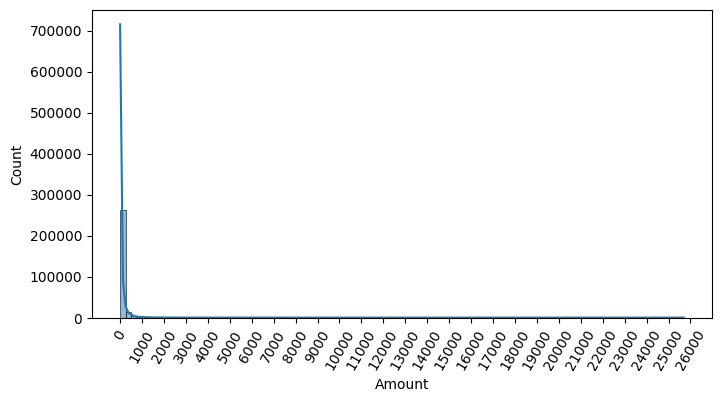

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [ ]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행. 
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,    F1: 0.8409, AUC:0.9779


In [ ]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환 
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [ ]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796


### 이상치 데이터 제거 후 모델 학습/예측/평가

<Axes: >

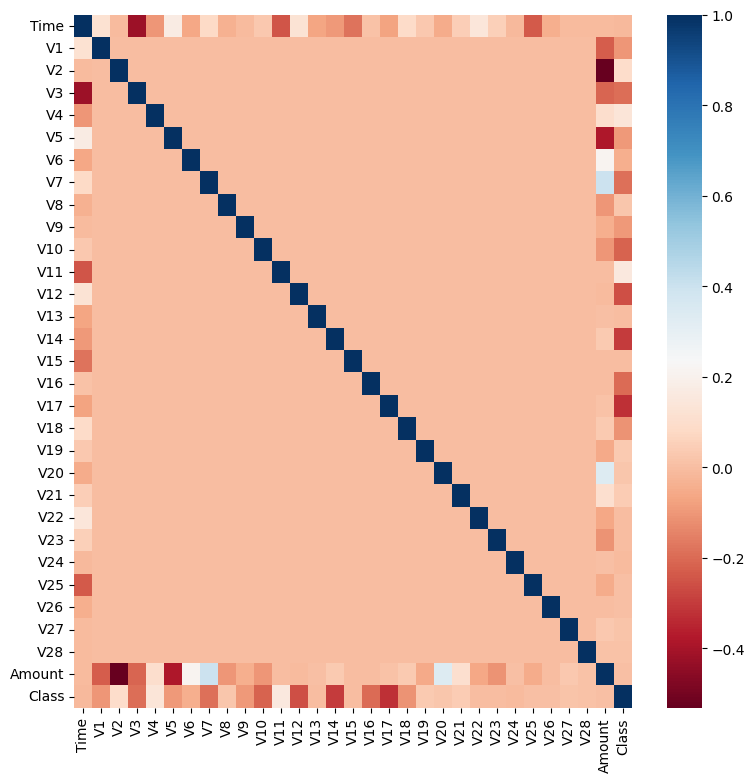

In [ ]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

* 이상치 데이터 검출

In [ ]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index
    

In [ ]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


* 이상치 데이터 제거

In [ ]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9780


### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [ ]:
#conda install -c conda-forge imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


In [ ]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)


오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    F1: 0.1023, AUC:0.9737


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    


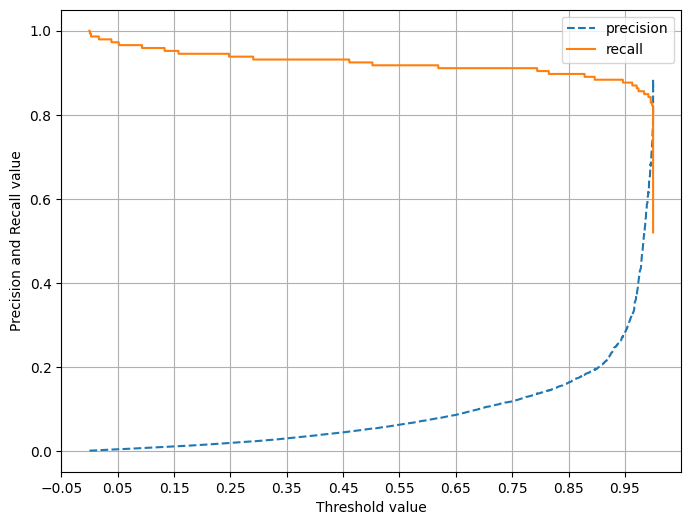

In [ ]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493,    F1: 0.8794, AUC:0.9814


In [ ]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train , X_test , y_train , y_test = train_test_split(X_data , y_label , test_size=0.2 , random_state=0)

In [ ]:
# 개별 ML 모델을 위한 Classifier 생성.
knn_clf  = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 최종 Stacking 모델을 위한 Classifier생성. 
lr_final = LogisticRegression(C=10)


In [ ]:
# 개별 모델들을 학습. 
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train , y_train)
dt_clf.fit(X_train , y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [ ]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정. 
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f} :'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9035
에이다부스트 정확도: 0.9561 :


In [ ]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦. 
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [ ]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , final)))

최종 메타 모델의 예측 정확도: 0.9649


## CV 세트 기반의 스태킹

#### 스태킹 앙상블 모델

개별 알고리즘의 예측 결과 데이터 세트를 최종적인 메타 데이터 세트로 만들어 별도의 ML 알고리즘으로 최종 학습을 수행 & 테스트 데이터를 기반으로 다시 최종 예측을 수행

\
두 종류의 모델이 필요

\
* 개별적인 기반 모델

* 이 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델

\
\- 스태킹 모델의 핵심은 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것

\- 조금이라도 성능 수치를 높여야 할 경우 자주 사용

\- 2~3개의 개별 모델만을 결합해서 쉽게 예측 성능을 향상시킬 수 없음

\- 스태킹을 적용한다고 해서 반드시 성능 향상 된다는 보장 없음

* 교차 검증 세트 기반의 스태킹

\
과적합을 개선하기 위해 최종 메타 모델을 위한 데이터 세트를 만들 때 사용
수행

\
Step1: 각 모델별로 원본 학습/테스트 데이터를 예측한 결과 값을 기반으로 메타 모델을 위한 학습/테스트 데이터를 생성

\
Step2: Step1에서 개별 모델들이 생성한 학습/테스트용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 학습할 최종 학습/테스트 데이터를 생성. 메타 모델은 최종 학습 데이터 기반으로 학습한 후, 최종 테스트 데이터를 예측하고 원본 테스트 데이터의 레이블 데이터를 기반으로 평가함

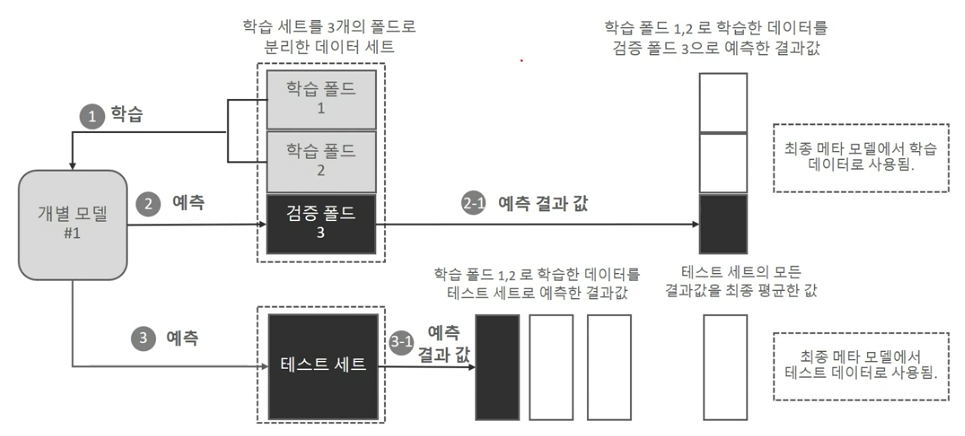

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [ ]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)    
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


In [ ]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [ ]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737
